In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning Evaluation Strategies


## 1. Introduzione alla valutazione della classificazione <a id="introduction"></a>

Quando si crea un modello di classificazione, abbiamo bisogno di metodi sistematici per determinare quanto sia efficace. I problemi di classificazione si presentano in molte forme:

- Classificazione binaria (due classi, come spam vs. non spam)
- Classificazione multi-classe (più classi distinte)
- Classificazione multi-etichetta (ogni istanza può appartenere a più classi)

In questo tutorial, ci concentreremo principalmente sulle metriche di classificazione binaria, poiché costituiscono la base per comprendere scenari di valutazione più complessi.

L'approccio di valutazione ideale dipende da diversi fattori:
- La distribuzione delle classi nei dati (bilanciata vs. sbilanciata)
- Il costo relativo dei diversi tipi di errori
- Se hai bisogno di probabilità o solo di etichette di classe
- Gli obiettivi specifici della tua applicazione

Iniziamo esplorando come impostare il nostro ambiente e creare dati per illustrare questi concetti.

## 1.1 Impostazione del nostro ambiente <a id="setup"></a>

Per prima cosa, importeremo le librerie necessarie:

In [21]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score,
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1.2 Creazione di dati campione <a id="sample-data"></a>

Per illustrare le metriche di classificazione, creeremo due set di dati:
1. Un set di dati bilanciato in cui entrambe le classi compaiono con la stessa frequenza
2. Un set di dati sbilanciato in cui una classe è molto più rara dell'altra

Questo approccio ci aiuterà a capire come si comportano le diverse metriche in base a varie distribuzioni di classi.

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a balanced dataset
X_balanced, y_balanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.5, 0.5],  # Equal class probabilities
    random_state=42
)

# Create an imbalanced dataset (10% minority class)
X_imbalanced, y_imbalanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],  # Imbalanced class probabilities
    random_state=42
)

# Split datasets into training and testing sets
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42
)

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.25, random_state=42
)

# Check class distributions
print("Balanced dataset class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))
print("\nImbalanced dataset class distribution:")
print(pd.Series(y_imbalanced).value_counts(normalize=True))

Balanced dataset class distribution:
0    0.5005
1    0.4995
Name: proportion, dtype: float64

Imbalanced dataset class distribution:
0    0.8966
1    0.1034
Name: proportion, dtype: float64


In [23]:
# Train a logistic regression model on the balanced dataset
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_bal_train, y_bal_train)

# Train a logistic regression model on the imbalanced dataset
lr_imbalanced = LogisticRegression(random_state=42)
lr_imbalanced.fit(X_imb_train, y_imb_train)

# Generate predictions and probability scores
y_bal_pred = lr_balanced.predict(X_bal_test)
y_bal_prob = lr_balanced.predict_proba(X_bal_test)[:, 1]

y_imb_pred = lr_imbalanced.predict(X_imb_test)
y_imb_prob = lr_imbalanced.predict_proba(X_imb_test)[:, 1]

# Train a second model (Random Forest) for comparison
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_bal_train, y_bal_train)
y_bal_pred_rf = rf_balanced.predict(X_bal_test)
y_bal_prob_rf = rf_balanced.predict_proba(X_bal_test)[:, 1]

rf_imbalanced = RandomForestClassifier(random_state=42)
rf_imbalanced.fit(X_imb_train, y_imb_train)
y_imb_pred_rf = rf_imbalanced.predict(X_imb_test)
y_imb_prob_rf = rf_imbalanced.predict_proba(X_imb_test)[:, 1]

## 1.3 Metriche di classificazione di base <a id="basic-metrics"></a>

Il fondamento della valutazione della classificazione è la comprensione dei quattro possibili risultati di un classificatore binario:

- **Veri positivi (TP)**: casi positivi previsti correttamente
- **Falsi positivi (FP)**: casi positivi previsti in modo errato (errore di tipo I)
- **Veri negativi (TN)**: casi negativi previsti correttamente
- **Falsi negativi (FN)**: casi negativi previsti in modo errato (errore di tipo II)

Questi quattro valori costituiscono la base per quasi tutte le metriche di classificazione che discuteremo.

#### Matrice di confusione <a id="confusion-matrix"></a>

Una matrice di confusione visualizza i quattro possibili risultati in una griglia 2×2. È la base per comprendere le prestazioni di classificazione.

La **matrice di confusione** è uno strumento fondamentale per analizzare le prestazioni di un classificatore, specialmente quando si lavora con **classificatori binari**. Mostra in modo chiaro e immediato come le **classi predette** del modello si confrontano con le **classi reali** (o effettive) per un dato set di dati.

In una **matrice di confusione 2×2** per un problema di classificazione binaria, i valori sono organizzati in una griglia con 2 righe e 2 colonne, dove ogni cella rappresenta una combinazione tra le **classi reali** e le **classi predette** dal modello.

#### Struttura della matrice di confusione 2×2

|               | **Predetto Positivo** | **Predetto Negativo** |
|---------------|-----------------------|-----------------------|
| **Reale Positivo**  | **Vero Positivo (TP)** | **Falso Negativo (FN)** |
| **Reale Negativo**  | **Falso Positivo (FP)** | **Vero Negativo (TN)** |

Ecco cosa significa ogni cella:

- **TP (True Positive - Vero Positivo)**: Questi sono i casi in cui il modello ha previsto correttamente la classe positiva (ad esempio, un "sì" predetto che è realmente un "sì").
- **FN (False Negative - Falso Negativo)**: Questi sono i casi in cui il modello ha previsto erroneamente la classe negativa (ad esempio, un "no" predetto quando il vero valore era "sì").
- **FP (False Positive - Falso Positivo)**: Questi sono i casi in cui il modello ha previsto erroneamente la classe positiva (ad esempio, un "sì" predetto quando il vero valore era "no").
- **TN (True Negative - Vero Negativo)**: Questi sono i casi in cui il modello ha previsto correttamente la classe negativa (ad esempio, un "no" predetto che è realmente un "no").

#### Perché è importante la matrice di confusione?

La matrice di confusione fornisce una visione dettagliata della performance del classificatore. Non si limita a dire se il modello ha fatto bene o male (come fa l'accuratezza), ma mostra anche i **tipi di errori** che il modello sta facendo. Questo è particolarmente utile per i seguenti motivi:

1. **Comprensione degli errori**: La matrice di confusione aiuta a capire se il modello sta facendo più **falsi positivi** o **falsi negativi**, cosa che potrebbe essere cruciale in determinati scenari. Ad esempio, in un'applicazione medica, i **falsi negativi** (non rilevare una malattia) potrebbero essere molto più gravi dei **falsi positivi** (sospettare erroneamente una malattia).

2. **Bilanciamento delle classi**: Se le classi sono **sbilanciate** (ad esempio, molte più osservazioni negative che positive), l'accuratezza da sola potrebbe non essere un buon indicatore di performance. La matrice di confusione aiuta a vedere come il modello sta trattando ciascuna classe separatamente.

3. **Calcolo di altre metriche**: Molte delle **metriche di classificazione** (come precisione, richiamo, F1-score) sono calcolate a partire dai valori della matrice di confusione. Queste metriche forniscono una visione più completa delle prestazioni del modello, in particolare in presenza di dati sbilanciati.

#### Come interpretare la matrice di confusione

- **Alto numero di TP e TN**: Questo indica che il modello sta facendo un buon lavoro nel predire correttamente sia la classe positiva che quella negativa.
- **Alto numero di FP e FN**: Questo indica che il modello sta commettendo molti errori. Un **falso positivo** significa che il modello sta erroneamente classificando le istanze come positive, mentre un **falso negativo** significa che il modello sta erroneamente classificando le istanze come negative.


  \text{Accuratezza} = \frac{TP + TN}{TP + FP + TN + FN}
  \]


#### Conclusioni

La matrice di confusione è uno strumento essenziale per comprendere il comportamento di un modello di classificazione. Non solo ti dice se il modello è preciso o meno, ma ti fornisce anche informazioni dettagliate sugli errori commessi. Le informazioni contenute nella matrice sono cruciali per calcolare altre metriche importanti e per fare aggiustamenti al modello, come il bilanciamento delle classi o la regolazione dei parametri.

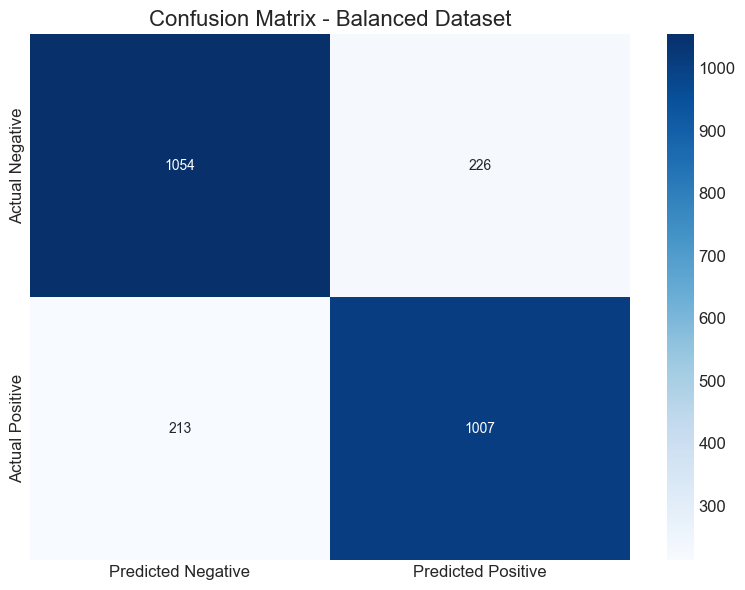

True Positives (TP): 1007
False Positives (FP): 226
True Negatives (TN): 1054
False Negatives (FN): 213


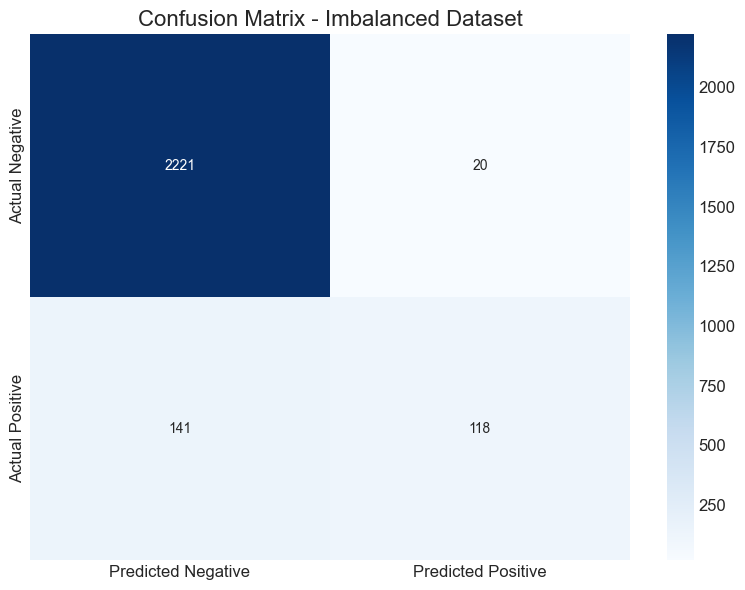

True Positives (TP): 118
False Positives (FP): 20
True Negatives (TN): 2221
False Negatives (FN): 141


In [24]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values for annotation
    tn, fp, fn, tp = cm.ravel()
    
    # Create a heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print TP, FP, TN, FN values
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")

# Plot confusion matrices for both datasets
plot_confusion_matrix(y_bal_test, y_bal_pred, "Confusion Matrix - Balanced Dataset")
plot_confusion_matrix(y_imb_test, y_imb_pred, "Confusion Matrix - Imbalanced Dataset")

### Accuratezza <a id="accuracy"></a>

L'accuratezza misura la proporzione di previsioni corrette rispetto al numero totale di previsioni. Sebbene intuitiva, può essere fuorviante per set di dati sbilanciati.

L'**accuratezza** è una delle metriche più semplici e più utilizzate per valutare le prestazioni di un modello di classificazione. Si calcola come la proporzione di previsioni corrette rispetto al totale delle previsioni fatte dal modello, ed è definita dalla seguente formula:

\[
\text{Accuratezza} = \frac{TP + TN}{TP + FP + TN + FN}
\]

Dove:
- **TP** (True Positives) sono i veri positivi (cioè le istanze correttamente classificate come positive).
- **TN** (True Negatives) sono i veri negativi (cioè le istanze correttamente classificate come negative).
- **FP** (False Positives) sono i falsi positivi (cioè le istanze erroneamente classificate come positive).
- **FN** (False Negatives) sono i falsi negativi (cioè le istanze erroneamente classificate come negative).

#### Interpretazione dell'accuratezza:
- Se l'accuratezza è alta, significa che il modello ha fatto molte previsioni corrette rispetto al numero totale di previsioni. 
- Se l'accuratezza è bassa, significa che il modello ha commesso molti errori.

#### Quando può essere fuorviante?

L'accuratezza può essere **fuorviante** quando il dataset è **sbilanciato**, cioè quando le classi nel dataset non sono distribuite equamente. Un esempio classico di un dataset sbilanciato si trova nel **problema di classificazione binaria**, in cui una delle classi è molto più frequente dell'altra (ad esempio, un dataset in cui il 95% delle istanze appartengono alla classe negativa e solo il 5% alla classe positiva).

#### Perché l'accuratezza può essere fuorviante nei set di dati sbilanciati?

1. **Quando una classe è dominante**: Se una delle classi è molto più frequente dell'altra, un modello che predice sempre la classe più frequente può ottenere una **buona accuratezza** senza mai prevedere correttamente la classe meno frequente. In questo caso, la metrica di accuratezza non riflette correttamente la capacità del modello di rilevare entrambe le classi.
   
2. **Disbilanciamento delle classi**: In scenari reali, come la **diagnosi di malattie rare** o la **previsione di frodi** (dove i "positivi" sono rari), l'accuratezza potrebbe non essere un indicatore utile delle prestazioni del modello. Ad esempio, un modello che predice sempre "no malattia" (classe negativa) può avere un'accuratezza molto alta, ma non sarebbe utile, poiché non rileverebbe mai i casi di malattia.

#### Conclusione

Sebbene l'accuratezza sia una metrica utile per modelli equilibrati, in presenza di **set di dati sbilanciati**, può essere fuorviante. Quando il dataset ha un grande disbalanciamento tra le classi, è più appropriato utilizzare altre metriche come **precisione**, **richiamo**, **F1-score** o **AUC-ROC** per ottenere una valutazione più accurata delle prestazioni del modello. Queste metriche aiutano a comprendere meglio come il modello sta gestendo ciascuna classe, senza essere influenzate dal numero di osservazioni in ciascuna classe.

In [25]:
# Calcola la precisione per entrambi i set di dati
balanced_accuracy = accuracy_score(y_bal_test, y_bal_pred)
imbalanced_accuracy = accuracy_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset accuracy: {balanced_accuracy:.4f}")
print(f"Imbalanced dataset accuracy: {imbalanced_accuracy:.4f}")

# Vediamo cosa succede se prevediamo sempre la classe di maggioranza nel set di dati sbilanciato
majority_predictions = np.zeros_like(y_imb_test)  # Assuming 0 is the majority class
minority_predictions = np.ones_like(y_imb_test)  # Assuming 0 is the majority class

majority_accuracy = accuracy_score(y_imb_test, majority_predictions)
minority_accuracy = accuracy_score(y_imb_test, minority_predictions)

print(f"Imbalanced dataset - majority class baseline accuracy: {majority_accuracy:.4f}")
print(f"Imbalanced dataset - minority class baseline accuracy: {minority_accuracy:.4f}")

Balanced dataset accuracy: 0.8244
Imbalanced dataset accuracy: 0.9356
Imbalanced dataset - majority class baseline accuracy: 0.8964
Imbalanced dataset - minority class baseline accuracy: 0.1036


Come possiamo vedere, l'accuratezza può essere fuorviante con dati sbilanciati, poiché un modello che prevede sempre la classe di maggioranza otterrà comunque un'accuratezza apparentemente elevata. Questo mostra perché abbiamo bisogno di metriche più sfumate per problemi di classificazione sbilanciati.

### Precisione <a id="precisione"></a>

La precisione misura quante delle istanze positive previste sono effettivamente positive. È fondamentale quando il costo dei falsi positivi è elevato.

$$\text{Precisione} = \frac{TP}{TP + FP}$$

La **precisione** è una metrica fondamentale nelle classificazioni binarie e rappresenta la proporzione di **previsioni positive corrette** rispetto al totale delle previsioni positive effettuate dal modello. In altre parole, indica quante delle istanze classificate come "positive" sono effettivamente corrette. La formula della precisione è:

\[
\text{Precisione} = \frac{TP}{TP + FP}
\]

Dove:
- **TP (True Positives)**: sono i casi positivi che sono stati correttamente previsti come positivi dal modello.
- **FP (False Positives)**: sono i casi negativi che sono stati erroneamente previsti come positivi dal modello.

#### Quando è importante la precisione?
La **precisione** è particolarmente utile in scenari in cui **i falsi positivi sono costosi o problematici**. Ad esempio, in contesti come:

1. **Rilevamento di frodi**: Se un sistema di rilevamento delle frodi predice erroneamente che una transazione è fraudolenta (falso positivo), il risultato potrebbe essere che un cliente viene bloccato ingiustamente o subisce un'azione di recupero del denaro. In questi casi, è essenziale ridurre il numero di **falsi positivi**.
  
2. **Diagnosi mediche (ad esempio, rilevamento di malattie)**: Se un modello diagnostico predice erroneamente che un paziente è malato (falso positivo), ciò potrebbe comportare trattamenti inutili, esami aggiuntivi, o ansia non necessaria. In queste situazioni, la precisione aiuta a capire quante delle persone identificate come malate siano effettivamente malate, riducendo così il rischio di trattamenti inutili.

3. **Spamming e filtraggio delle email**: Se un sistema di rilevamento dello spam etichetta erroneamente email legittime come spam (falso positivo), l'utente potrebbe perdere informazioni importanti. In questo caso, una **alta precisione** significa che la maggior parte delle email etichettate come spam sono effettivamente spam.

#### Come interpretare la precisione?
- **Alta precisione**: Un valore elevato di precisione significa che il modello è molto accurato nel classificare correttamente le istanze positive e ha un basso numero di falsi positivi. In altre parole, quando il modello predice un caso come positivo, è altamente probabile che lo sia davvero. Tuttavia, potrebbe esserci il rischio che il modello manchi alcuni veri positivi (basso richiamo).
  
- **Bassa precisione**: Una bassa precisione indica che il modello tende a fare molti **falsi positivi**. Questo significa che predice erroneamente come positivi molti casi che in realtà sono negativi. Un basso valore di precisione può essere problematico quando il costo dei falsi positivi è elevato.

#### Precisione vs. Richiamo
La precisione è spesso messa in relazione con il **richiamo**. Mentre la precisione misura **quante previsioni positive sono corrette**, il richiamo misura **quante istanze positive sono correttamente rilevate dal modello**. Queste due metriche sono in genere in un trade-off, nel senso che:
- Aumentando la **precisione**, il modello potrebbe ignorare alcuni veri positivi (cioè abbassare il richiamo).
- Aumentando il **richiamo**, il modello potrebbe iniziare a prevedere più falsi positivi (cioè abbassare la precisione).

Un buon modello dovrebbe bilanciare precisione e richiamo, ma la priorità tra le due dipende dal **contesto** specifico. 

#### Quando usare la precisione?

La precisione è una metrica importante nei seguenti casi:
1. Quando **il costo dei falsi positivi è alto** (ad esempio, in diagnostica medica o rilevamento delle frodi).
2. Quando non ci si preoccupa di trascurare qualche caso positivo, ma si vuole essere certi che i positivi previsti siano effettivamente positivi (ad esempio, nell'identificazione di oggetti in un'immagine).
3. Quando il modello è **molto incline a fare previsioni positive** e si vuole ridurre al minimo il numero di errori relativi a tali previsioni.

#### In conclusione
La **precisione** è una metrica utile quando vogliamo minimizzare il numero di **falsi positivi** e assicurarci che ogni previsione positiva sia corretta. Tuttavia, è importante considerare anche altre metriche, come il **richiamo** o l'**F1-score**, soprattutto nei casi in cui si vuole bilanciare l'importanza di rilevare tutte le istanze positive, non solo evitare falsi positivi.

In [1]:
# Calcola la precisione per entrambi i set di dati
balanced_precision = precision_score(y_bal_test, y_bal_pred)
imbalanced_precision = precision_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset precision: {balanced_precision:.4f}")
print(f"Imbalanced dataset precision: {imbalanced_precision:.4f}")

NameError: name 'precision_score' is not defined

### Richiamo <a id="recall"></a>

Il richiamo (chiamato anche sensibilità) misura quanti dei casi positivi effettivi sono stati correttamente identificati dal nostro modello. È importante quando perdere casi positivi è costoso.

$$\text{Richiamo} = \frac{TP}{TP + FN}$$

Il **richiamo**, noto anche come **sensibilità** o **true positive rate (TPR)**, è una metrica che misura la capacità del modello di **identificare correttamente i casi positivi**. In altre parole, il richiamo indica quanti dei veri positivi (casi positivi effettivi) sono stati **correttamente identificati dal modello**.

La formula del richiamo è la seguente:

\[
\text{Richiamo} = \frac{TP}{TP + FN}
\]

Dove:
- **TP (True Positives)**: sono i casi positivi correttamente previsti come positivi dal modello.
- **FN (False Negatives)**: sono i casi positivi che il modello ha erroneamente classificato come negativi.

#### Interpretazione del richiamo

Il richiamo ci dice quante delle istanze positive effettive sono state correttamente previste dal modello. Un valore elevato di richiamo implica che il modello è molto bravo a **non perdere** i casi positivi, cioè a riconoscere quante più istanze positive possibili. 

Al contrario, un basso valore di richiamo indica che il modello ha un alto numero di **falsi negativi** (casi positivi che sono stati classificati erroneamente come negativi). In altre parole, il modello sta perdendo **importanti casi positivi**.

#### Quando è importante il richiamo?

Il **richiamo** è particolarmente utile in scenari in cui **perdere casi positivi è costoso o problematico**. Ecco alcuni esempi di situazioni in cui il richiamo è fondamentale:

1. **Diagnosi medica (ad esempio, rilevamento di malattie)**: Se un medico diagnostica erroneamente un paziente sano come non malato (falso negativo), può non somministrare un trattamento salvavita. In questo caso, è fondamentale ridurre i falsi negativi, quindi massimizzare il richiamo. Un alto richiamo significa che la maggior parte dei pazienti malati è identificata correttamente.

2. **Rilevamento delle frodi**: Se un sistema di rilevamento delle frodi non rileva una transazione fraudolenta (falso negativo), questa potrebbe passare inosservata e causare danni finanziari. In questo caso, un alto richiamo è cruciale, in quanto vogliamo essere certi di rilevare **tutti i casi di frode**, anche a costo di alcuni falsi positivi.

3. **Rilevamento di spam**: Se un sistema di filtro delle email non rileva una email di spam (falso negativo), l'utente potrebbe essere esposto a contenuti indesiderati o dannosi. In questo caso, aumentare il richiamo aiuta a identificare correttamente la maggior parte delle email di spam.

#### Richiamo vs. Precisione
Il richiamo è spesso messo in relazione con la **precisione**. Mentre la precisione misura quante delle previsioni positive sono corrette, il richiamo misura quante delle istanze effettivamente positive sono state correttamente previste.

Queste due metriche sono **in un trade-off**, ovvero un aumento di una tende a ridurre l'altra. Se, per esempio, si aumenta la soglia per classificare una previsione come positiva (rendendo il modello più severo), si potrebbe ottenere un aumento della **precisione** ma una riduzione del **richiamo**, e viceversa.

- **Precisione alta e richiamo basso**: il modello è molto selettivo nel prevedere le istanze come positive, ma potrebbe perdere alcuni veri positivi.
- **Richiamo alto e precisione bassa**: il modello tende a classificare molte più istanze come positive, ma di queste molte potrebbero non essere effettivamente corrette.

In contesti in cui è più importante **non perdere veri positivi** (come in diagnosi mediche o rilevamento di frodi), il richiamo diventa una metrica critica, mentre la precisione può passare in secondo piano.


### Quando utilizzare il richiamo

Il richiamo è utile quando:
1. **Non vuoi perdere nessun caso positivo**, anche a costo di includere alcuni falsi positivi.
2. **Perdere veri positivi è costoso o dannoso**, come in scenari di salute, frodi finanziarie o sicurezza.
3. Vuoi garantire che il modello **rilevi tutte le istanze positive** possibili, senza sottovalutare la prevalenza di una classe importante.

#### Esempi di utilizzo

- **Medicina**: Nella diagnosi di malattie rare, un basso richiamo potrebbe significare che molte persone malate non vengono identificate e quindi non ricevono il trattamento adeguato.
- **Sicurezza**: In un sistema di rilevamento di attacchi informatici, un basso richiamo potrebbe implicare che molti attacchi non vengono rilevati, lasciando il sistema vulnerabile.
- **Rilevamento frodi**: Un sistema di rilevamento frodi che ha un alto richiamo è in grado di identificare un numero maggiore di transazioni fraudolente, riducendo il rischio di danni finanziari.

#### Conclusione

Il **richiamo** è una metrica cruciale quando si vuole ridurre al minimo il numero di **falsi negativi**, ossia quando è importante **non perdere i veri positivi**. È essenziale in settori come la medicina, la sicurezza e il rilevamento delle frodi, dove le conseguenze di perdere casi positivi potrebbero essere gravi. Come con altre metriche, il richiamo deve essere bilanciato con altre misure, come la precisione, per ottenere una valutazione complessiva delle prestazioni del modello.

In [27]:
# Calcola il richiamo per entrambi i set di dati
balanced_recall = recall_score(y_bal_test, y_bal_pred)
imbalanced_recall = recall_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset recall: {balanced_recall:.4f}")
print(f"Imbalanced dataset recall: {imbalanced_recall:.4f}")

Balanced dataset recall: 0.8254
Imbalanced dataset recall: 0.4556


### Punteggio F1 <a id="f1-score"></a>

Il punteggio F1 è la media armonica di precisione e richiamo, che fornisce un equilibrio tra di essi. È particolarmente utile per set di dati non bilanciati.

$$F1 = 2 \times \frac{\text{Precisione} \times \text{Richiamo}}{\text{Precisione} + \text{Richiamo}}$$

Il **punteggio F1** è una metrica combinata che unisce la **precisione** e il **richiamo** in un'unica misura. È particolarmente utile quando i dati sono **sbilanciati**, cioè quando le classi positive e negative non sono rappresentate in modo equilibrato nel dataset.

Dove:
- **Precisione** è la proporzione di veri positivi (TP) tra tutte le previsioni positive fatte dal modello (\( \frac{TP}{TP + FP} \)).
- **Richiamo** è la proporzione di veri positivi tra tutti i casi positivi effettivi (\( \frac{TP}{TP + FN} \)).

#### Interpretazione del punteggio F1

Il punteggio F1 cerca di bilanciare la precisione e il richiamo in un'unica metrica. Il valore F1 può variare tra 0 e 1:
- **F1 = 1**: indica un modello perfetto, con sia precisione che richiamo pari a 1. In altre parole, il modello ha rilevato correttamente tutti i positivi e ha fatto nessun errore nelle sue previsioni positive.
- **F1 = 0**: indica un modello che non è stato in grado di fare previsioni positive corrette, con precisione e richiamo uguali a 0.

#### Quando utilizzare il punteggio F1

Il punteggio F1 è particolarmente utile in scenari in cui si ha un **dataset sbilanciato**. In questi casi, la precisione e il richiamo possono variare significativamente, e uno potrebbe essere più importante dell'altro. Tuttavia, il punteggio F1 è un buon compromesso tra le due misure e aiuta a bilanciare la performance del modello quando c'è un trade-off tra precisione e richiamo.

##### Ad esempio:
- Se il tuo dataset ha molte più istanze negative rispetto a quelle positive (ad esempio, un sistema di rilevamento frodi dove le transazioni fraudolente sono rare), il modello potrebbe raggiungere una buona **precisione** senza essere in grado di rilevare molte delle istanze **positive** (frodi). Il punteggio F1 in questo caso sarà utile perché tiene conto sia dei veri positivi che dei falsi positivi.
  
- Se, invece, un'alta **precisione** è critica per il tuo caso d'uso, ma anche avere un buon **richiamo** è necessario, il punteggio F1 ti fornirà un'indicazione equilibrata delle prestazioni complessive del modello.

#### F1 vs. Precisione e Richiamo

Anche se precisione e richiamo sono metriche utili, sono parziali e potrebbero non rappresentare un'immagine completa delle prestazioni del modello, soprattutto nei casi in cui:
- Un valore molto elevato di precisione potrebbe venire a scapito del richiamo (o viceversa), il che potrebbe non essere ideale quando entrambe le metriche sono importanti.
  
Il punteggio F1 bilancia questi due aspetti, penalizzando i modelli che eccellono in uno dei due ma non nell'altro. Quando il dataset è sbilanciato, un buon punteggio F1 è un segnale che il modello sta ottenendo buoni risultati sia nel rilevare correttamente le istanze positive (richiamo), sia nell'essere selettivo nelle sue previsioni (precisione).

#### Perché il punteggio F1 è importante per set di dati sbilanciati?

In un **dataset sbilanciato**, dove una delle classi (ad esempio, la classe positiva) è molto meno rappresentata rispetto all'altra (ad esempio, la classe negativa), un modello potrebbe **ignorare completamente la classe meno rappresentata** (predicendo tutto come negativo). In questo caso, il punteggio F1 è particolarmente utile perché:
- Si assicura che il modello non sia troppo focalizzato su una sola classe.
- Penalizza i modelli che non fanno bene nel riconoscere le istanze della classe meno rappresentata, bilanciando le prestazioni tra precisione e richiamo.

#### In sintesi:
Il **punteggio F1** è un indicatore robusto delle prestazioni di un modello di classificazione, in particolare quando le classi sono sbilanciate o quando si vuole trovare un buon compromesso tra precisione e richiamo. A differenza di altre metriche, come l'accuratezza, il punteggio F1 non è influenzato dalla classe dominante (negativa) in un dataset sbilanciato, rendendolo una metrica migliore quando le classi positive sono più importanti.

In [28]:
# Calculate F1 score for both datasets
balanced_f1 = f1_score(y_bal_test, y_bal_pred)
imbalanced_f1 = f1_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset F1 score: {balanced_f1:.4f}")
print(f"Imbalanced dataset F1 score: {imbalanced_f1:.4f}")

Balanced dataset F1 score: 0.8210
Imbalanced dataset F1 score: 0.5945


### Specificità <a id="specificity"></a>

La specificità misura quanto bene il modello identifica i casi negativi. È il complemento del tasso di falsi positivi.

$$\text{Specificità} = \frac{TN}{TN + FP}$$

La **specificità** è una misura di prestazione di un modello di classificazione, utilizzata per valutare la capacità del modello di identificare correttamente i **casi negativi** (cioè, i campioni che appartengono alla classe negativa). Essa indica quindi quante volte il modello ha correttamente predetto l'assenza di una condizione (ad esempio, che una persona non abbia una malattia) rispetto al totale delle vere condizioni negative.

- **TN** (True Negatives): è il numero di **casi negativi veri**, ovvero i campioni correttamente classificati come appartenenti alla classe negativa.
- **FP** (False Positives): è il numero di **falsi positivi**, cioè i campioni che sono stati erroneamente classificati come positivi (quando in realtà appartengono alla classe negativa).

#### Interpretazione della Specificità:
- Una **specificità alta** significa che il modello è molto bravo a evitare falsi positivi. In altre parole, è molto preciso nel rilevare correttamente i **casi negativi**.
- Una **specificità bassa** indica che il modello tende a classificare erroneamente come positivi molti esempi negativi, aumentando i **falsi positivi**.

#### In relazione al contesto medico:
Immagina un test diagnostico per una malattia:
- Se il test ha **alta specificità**, significa che i pazienti **sani** sono raramente diagnosticati come malati (ovvero, pochi falsi positivi).
- Se la **specificità è bassa**, molte persone sane potrebbero essere erroneamente diagnosticate come malate, causando ansia o trattamenti inutili.

#### Complementarità con la Sensibilità:
La **specificità** è complementare alla **sensibilità** (o recall), che misura la capacità del modello di identificare correttamente i **casi positivi**. La relazione tra le due è importante, poiché migliorare una potrebbe ridurre l'altra (per esempio, ridurre i falsi negativi potrebbe portare ad aumentare i falsi positivi e viceversa).

In un test diagnostico, ad esempio, si cerca spesso di bilanciare la **sensibilità** e la **specificità** a seconda dell'applicazione pratica:
- Se è più importante non perdere nessun caso positivo (come in alcune malattie gravi), si privilegia la sensibilità.
- Se invece è cruciale evitare diagnosi errate di malattia (come in malattie gravi ma rare), si privilegia la specificità.

#### Conclusioni:
La **specificità** è un importante indicatore della **precisione del modello** nel predire correttamente i negativi. Viene utilizzata soprattutto in ambiti in cui i falsi positivi sono problematici, come nel rilevamento di malattie o in modelli di sicurezza (ad esempio, nel rilevamento di frodi).

In [29]:
# Calculate specificity manually (not directly available in sklearn)
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

balanced_specificity = specificity_score(y_bal_test, y_bal_pred)
imbalanced_specificity = specificity_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset specificity: {balanced_specificity:.4f}")
print(f"Imbalanced dataset specificity: {imbalanced_specificity:.4f}")

Balanced dataset specificity: 0.8234
Imbalanced dataset specificity: 0.9911


## Metriche di valutazione della classificazione multiclasse

### Accuratezza
L'accuratezza misura la proporzione di istanze classificate correttamente tra tutte le istanze. Sebbene sia semplice da capire, può essere fuorviante quando le classi sono sbilanciate.

```
Accuratezza = Numero di previsioni corrette / Numero totale di previsioni
```

### Matrice di confusione
Una visualizzazione tabulare che mostra le classi previste rispetto alle classi effettive. Per i problemi multiclasse, questa diventa una matrice N×N dove N è il numero di classi.

### Precisione, richiamo e punteggio F1
Queste metriche possono essere calcolate separatamente per ogni classe:

- **Precisione**: la capacità del modello di non etichettare un campione negativo come positivo.
```
Precisione per la classe i = TP_i / (TP_i + FP_i)
```

- **Richiamo**: la capacità del modello di trovare tutti i campioni positivi. ```
Richiamo per la classe i = TP_i / (TP_i + FN_i)


- **F1-Score**: la media armonica di precisione e richiamo.


### Macro-media e micro-media
Per le impostazioni multiclasse, abbiamo bisogno di modi per aggregare le metriche tra le classi:

- **Macro-media**: calcola la metrica in modo indipendente per ogni classe e quindi prendi la media. Questo tratta tutte le classi allo stesso modo.

Macro-Precisione = (Precision_1 + Precision_2 + ... + Precision_N) / N


- **Micro-media**: aggrega i contributi di tutte le classi per calcolare la metrica media. Questo tiene conto dello squilibrio di classe. ```
Micro-Precisione = TP totale / (TP totale + FP totale)


- **Media ponderata**: simile alla media macro, ma ponderata in base al numero di istanze reali per ogni classe.

### Curve ROC e AUC
Per i problemi multiclasse, le curve ROC possono essere generate in modalità one-vs-rest (una curva per classe). L'AUC (Area sotto la curva) riassume la capacità del modello di discriminare tra le classi.


### Metriche di valutazione della classificazione multietichetta

### Accuratezza del sottoinsieme (rapporto di corrispondenza esatta)
Una metrica rigorosa che richiede che il set di etichette previsto corrisponda esattamente al set di etichette reale.
```
Accuratezza del sottoinsieme = Numero di campioni con tutte le etichette previste correttamente / Numero totale di campioni
```

### Perdita di Hamming
La frazione di etichette previste in modo errato (valori più piccoli sono migliori).
```
Perdita di Hamming = (1/N) * Σ(1/L) * |y_i ⊕ h(x_i)|
```
dove ⊕ rappresenta l'operazione XOR, N è il numero di campioni e L è il numero di etichette.

### Indice di Jaccard (coefficiente di similarità di Jaccard)
Misura la similarità tra i set di etichette previsti e quelli reali.
```
Indice di Jaccard = |Y ∩ Ŷ| / |Y ∪ Ŷ|
```
dove Y è il set di etichette reale e Ŷ è il set di etichette previsto.

### Precisione, richiamo e punteggio F1 per multietichetta
Questi possono essere calcolati in diversi modi:

- **Media campione**: calcola le metriche per ogni istanza e poi la media.
- **Micro-media**: calcola le metriche globalmente contando il totale di veri positivi, falsi negativi e falsi positivi.
- **Macro-media**: calcola le metriche per ogni etichetta e poi la media.

### Metriche di classificazione delle etichette
Quando il modello genera probabilità per ogni etichetta:

- **Errore di copertura**: quanto in media dobbiamo scendere nell'elenco delle etichette classificate per coprire tutte le etichette vere.
- **Perdita di classificazione**: il numero medio di coppie di etichette ordinate in modo errato. - **Precisione media**: la precisione media nelle posizioni di tutte le etichette vere.



Le **metriche di valutazione della classificazione multietichetta** sono fondamentali per analizzare modelli che assegnano più di una etichetta a ciascun campione, come nel caso di rilevamento di oggetti in immagini, classificazione di testo in più categorie, o analisi di sentimenti con diverse emozioni. Ogni metrica fornisce una visione diversa delle prestazioni del modello, quindi è importante comprenderle nel contesto dell'applicazione.

#### Accuratezza del sottoinsieme (rapporto di corrispondenza esatta)

L'accuratezza del sottoinsieme è una metrica rigorosa che richiede che **tutte le etichette** per un dato campione siano previste correttamente. In altre parole, se un campione ha più etichette, tutte devono essere correttamente identificate affinché il campione venga conteggiato come "giusto."

**Formula:**
\[
\text{Accuratezza del sottoinsieme} = \frac{\text{Numero di campioni con tutte le etichette previste correttamente}}{\text{Numero totale di campioni}}
\]

Questa metrica è particolarmente severa, perché anche una sola etichetta errata fa fallire la previsione per quel campione. Viene usata quando è molto importante che tutte le etichette siano previste correttamente.

#### Perdita di Hamming

La **perdita di Hamming** misura la frazione di etichette previste in modo errato, in modo simile alla **distanza di Hamming** che viene usata per misurare le differenze tra sequenze binarie. È una metrica utile in scenari dove l'importanza di errori su ciascuna etichetta è simile.

**Formula:**
\[
\text{Perdita di Hamming} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{L} \left| y_i \oplus h(x_i) \right|
\]

dove:
- \( N \) è il numero di campioni.
- \( L \) è il numero di etichette.
- \( y_i \) è il vettore delle etichette reali per il campione \( i \).
- \( h(x_i) \) è il vettore delle etichette previste per il campione \( i \).
- \( \oplus \) è l'operazione XOR, che conta le differenze tra i vettori.

In altre parole, la **perdita di Hamming** penalizza il numero di errori per etichetta, calcolando la differenza tra la previsione e la verità di terreno per ogni etichetta.

#### Indice di Jaccard (coefficiente di similarità di Jaccard)

L'indice di Jaccard misura la **somiglianza** tra il set di etichette reali \( Y \) e il set di etichette previste \( Ŷ \), ed è particolarmente utile quando vogliamo capire quanto overlap c'è tra le etichette previste e quelle effettive.

**Formula:**
\[
\text{Indice di Jaccard} = \frac{|Y \cap Ŷ|}{|Y \cup Ŷ|}
\]

dove:
- \( |Y \cap Ŷ| \) è il numero di etichette comuni (ovvero le etichette correttamente previste).
- \( |Y \cup Ŷ| \) è il numero totale di etichette uniche presenti in entrambi i set (cioè le etichette previste più quelle reali, senza ripetizioni).

L'indice di Jaccard restituisce un valore tra 0 e 1, dove:
- 1 significa che il set di etichette previste è identico al set di etichette reali.
- 0 significa che non ci sono etichette comuni.

#### Precisione, Richiamo e Punteggio F1 per Multietichetta

Queste metriche vengono utilizzate per valutare la capacità di un modello di classificazione di identificare correttamente le etichette **positivi**. Nella classificazione multietichetta, possono essere calcolate in vari modi:

1. **Media campione (Sample-based)**: calcola la precisione, il richiamo e il punteggio F1 per ogni campione e poi prende la media dei valori.
2. **Micro-media (Micro-average)**: calcola le metriche globalmente, sommando il numero di veri positivi, falsi negativi e falsi positivi su tutti i campioni, e poi calcola precisione, richiamo e F1.
3. **Macro-media (Macro-average)**: calcola le metriche separatamente per ciascuna etichetta e poi prende la media dei valori per tutte le etichette.

#### Precisione, Richiamo e Punteggio F1:

- **Precisione** misura la frazione di etichette previste come positive che sono effettivamente corrette:
  \[
  \text{Precisione} = \frac{\text{Vero Positivo}}{\text{Vero Positivo} + \text{Falso Positivo}}
  \]

- **Richiamo** (o Sensibilità) misura la frazione di etichette reali positive che sono correttamente previste:
  \[
  \text{Richiamo} = \frac{\text{Vero Positivo}}{\text{Vero Positivo} + \text{Falso Negativo}}
  \]

- **Punteggio F1** è la media armonica di precisione e richiamo, utile quando c'è un bilanciamento tra i falsi positivi e i falsi negativi:
  \[
  \text{Punteggio F1} = \frac{2 \cdot \text{Precisione} \cdot \text{Richiamo}}{\text{Precisione} + \text{Richiamo}}
  \]

#### Metriche di Classificazione delle Etichette

Quando il modello genera **probabilità** per ciascuna etichetta, le seguenti metriche sono utili:

1. **Errore di copertura**:
   Misura la posizione media nell'elenco delle etichette previste per il campione in cui tutte le etichette vere sono classificate correttamente. In pratica, quanti elementi dobbiamo considerare delle etichette previste per coprire tutte quelle effettive.
   - Un valore basso è desiderabile perché significa che possiamo trovare tutte le etichette vere in una posizione alta nella lista.

2. **Perdita di classificazione**:
   Calcola il numero medio di coppie di etichette ordinate in modo errato, ossia la posizione in cui le etichette previste sono classificate erroneamente rispetto alla verità di terreno.

3. **Precisione media**:
   È la **precisione** media per le posizioni di tutte le etichette vere. Essa indica quanto è preciso il modello nelle posizioni in cui le etichette reali appaiono nella lista delle etichette previste.

#### Conclusione

Le metriche di classificazione multietichetta sono diverse dalle tradizionali metriche binarie o multiclasse e riflettono la complessità di predire molte etichette per ogni campione. Le metriche come l'accuratezza del sottoinsieme e la perdita di Hamming sono severi, mentre l'indice di Jaccard e il punteggio F1 forniscono misure più sfumate e robuste. La scelta della metrica dipende sempre dal contesto specifico dell'applicazione.

## Scelta della metrica giusta

La scelta della metrica di valutazione dipende dal tuo problema specifico:

- Usa **accuratezza** quando le classi sono bilanciate e i costi di classificazione errata sono simili.
- Usa **macro-media** quando tieni in egual modo a tutte le classi indipendentemente dalla loro frequenza.
- Usa **micro-media** quando tieni di più alle classi frequenti.
- Per problemi multietichetta, considera l'**indice di Jaccard** per una misura di similarità complessiva.
- Usa **perdita di Hamming** quando la correttezza parziale è preziosa in contesti multietichetta.

## 1.4 Valutazione basata sulla soglia <a id="threshold-evaluation"></a>

La maggior parte degli algoritmi di classificazione non si limita a prevedere le classi; generano punteggi di probabilità che vengono convertiti in etichette di classe utilizzando una soglia (in genere 0,5). Regolando questa soglia, possiamo effettuare un compromesso tra diversi tipi di errori.

### Curva ROC e AUC <a id="roc-curve"></a>

La curva Receiver Operating Characteristic (ROC) traccia il tasso di veri positivi (richiamo) rispetto al tasso di falsi positivi a varie impostazioni di soglia. L'area sotto la curva (AUC) fornisce una metrica singola che misura le prestazioni complessive su tutte le soglie.

La **ROC Curve** (Receiver Operating Characteristic Curve) e l'**AUC** (Area Under the Curve) sono due metriche molto utili per valutare le prestazioni di un modello di classificazione, in particolare per modelli che restituiscono probabilità invece di previsioni discrete.

### 1. **ROC Curve**

La **ROC Curve** è un grafico che visualizza la relazione tra il **tasso di veri positivi** (true positive rate, TPR, anche chiamato **richiamo**) e il **tasso di falsi positivi** (false positive rate, FPR). Ogni punto sulla curva rappresenta un **cambio di soglia** per decidere quando una previsione debba essere classificata come positiva.

#### Componenti della ROC Curve

- **True Positive Rate (TPR)** o **Richiamo**: è la proporzione di veri positivi rispetto a tutti i casi positivi effettivi:
  \[
  \text{TPR} = \frac{TP}{TP + FN}
  \]
  dove:
  - **TP (True Positives)**: i casi positivi correttamente identificati.
  - **FN (False Negatives)**: i casi positivi erroneamente etichettati come negativi.

- **False Positive Rate (FPR)**: è la proporzione di falsi positivi rispetto a tutti i casi negativi effettivi:
  \[
  \text{FPR} = \frac{FP}{FP + TN}
  \]
  dove:
  - **FP (False Positives)**: i casi negativi erroneamente etichettati come positivi.
  - **TN (True Negatives)**: i casi negativi correttamente identificati.

La **ROC curve** viene tracciata come segue:
- **Asse X**: il tasso di falsi positivi (FPR).
- **Asse Y**: il tasso di veri positivi (TPR, richiamo).
  
La curva mostra come varia il compromesso tra **veri positivi** e **falsi positivi** al variare della soglia di classificazione. Man mano che abbassiamo la soglia, classifichiamo sempre più istanze come positive, il che aumenta il TPR ma anche il FPR.

#### Interpretazione della ROC Curve:
- **Curva vicino all'angolo in alto a sinistra**: una curva che si avvicina all'angolo in alto a sinistra (ovvero un TPR vicino a 1 e un FPR vicino a 0) indica un modello che è molto bravo a distinguere le classi, con un basso tasso di falsi positivi e un alto tasso di veri positivi.
- **Curva vicino alla diagonale**: una curva che segue la diagonale (dalla parte inferiore sinistra alla parte superiore destra) suggerisce che il modello sta facendo previsioni casuali (equivale al caso in cui il modello non riesce a fare distinzioni utili tra le classi).
- **Curva sotto la diagonale**: una curva che si trova sotto la diagonale indica che il modello sta predicendo in modo peggiore rispetto a un modello casuale.

### 2. **AUC (Area Under the Curve)**

**AUC** sta per **Area Under the Curve** ed è una misura scalare che rappresenta l'area sotto la curva ROC. L'AUC fornisce una valutazione complessiva delle prestazioni del modello, tenendo conto di tutti i possibili valori di soglia.

#### Come calcolare l'AUC

L'AUC è una metrica che varia tra **0 e 1**:
- **AUC = 1**: significa che il modello è perfetto, riuscendo a distinguere perfettamente tra le classi positive e negative.
- **AUC = 0.5**: il modello non ha alcuna capacità discriminativa, come se stesse facendo previsioni casuali.
- **AUC < 0.5**: indica che il modello sta facendo peggio di un modello casuale.

#### Interpretazione dell'AUC

- **AUC vicino a 1**: il modello è molto buono nel classificare le istanze positive e negative. Rappresenta una buona separazione tra le classi.
- **AUC tra 0.7 e 0.8**: il modello ha una **discriminazione accettabile** e potrebbe essere considerato valido per l'uso in alcune applicazioni.
- **AUC tra 0.5 e 0.7**: il modello ha una **capacità discriminativa limitata**. Potrebbe essere necessario migliorare il modello.
- **AUC vicino a 0.5**: il modello è simile a un modello casuale. Non è utile per la classificazione.

### 3. **Perché utilizzare la ROC Curve e l'AUC?**

La ROC curve e l'AUC sono particolarmente utili in **set di dati sbilanciati** (dove una delle classi è molto meno rappresentata rispetto all'altra). In un caso sbilanciato, metriche come l'accuratezza potrebbero essere fuorvianti. Ad esempio, se un modello predice sempre la classe negativa (la classe dominante), potrebbe ottenere un'alta accuratezza anche senza fare previsioni corrette sulla classe positiva. La ROC curve e l'AUC, al contrario, forniscono una misura più accurata delle prestazioni del modello, poiché considerano la **capacità del modello di discriminare tra le classi** a vari livelli di soglia.

### 4. **Vantaggi della ROC Curve e AUC**

- **Valuta le prestazioni su tutte le soglie**: una delle principali forze della ROC curve è che permette di valutare il modello **senza dover scegliere una soglia di classificazione specifica**. Il modello è valutato a tutte le possibili soglie, il che fornisce una visione globale delle sue prestazioni.
  
- **Meno influenzata dallo sbilanciamento delle classi**: a differenza di altre metriche come l'accuratezza, la ROC curve e l'AUC non sono sensibili all'imbilanciamento delle classi. Se ci sono molte più istanze della classe negativa, un modello che predice sempre la classe negativa potrebbe comunque avere un'alta accuratezza, ma una bassa AUC.

- **Confronto tra modelli**: l'AUC può essere utilizzata per confrontare diversi modelli di classificazione. Un modello con un'AUC più alta avrà una capacità migliore di distinguere tra le classi rispetto a un modello con un'AUC inferiore.

### 5. **Esempio pratico della ROC Curve e AUC**

Supponiamo di avere un modello di classificazione per la rilevazione di frodi bancarie, con la classe positiva che rappresenta le transazioni fraudolente. Se il modello predice sempre "non frode", il tasso di veri positivi sarà 0, quindi la curva ROC si troverà sulla parte inferiore sinistra del grafico. Se il modello predice "frode" solo per alcune transazioni, vedremo una curva che si avvicina alla diagonale, con un AUC inferiore a 0.5. Se il modello predice correttamente la maggior parte delle frodi, la curva sarà molto vicina all'angolo in alto a sinistra, con un AUC vicino a 1.

### In sintesi:
- **ROC Curve**: è un grafico che traccia il tasso di veri positivi (richiamo) contro il tasso di falsi positivi per diversi valori di soglia, ed è utile per visualizzare le prestazioni di un modello di classificazione.
- **AUC**: è una singola metrica che quantifica la capacità complessiva del modello di discriminare tra le classi, calcolando l'area sotto la curva ROC. Un AUC elevato indica un modello che distingue bene tra le classi, mentre un AUC basso indica una performance scadente.

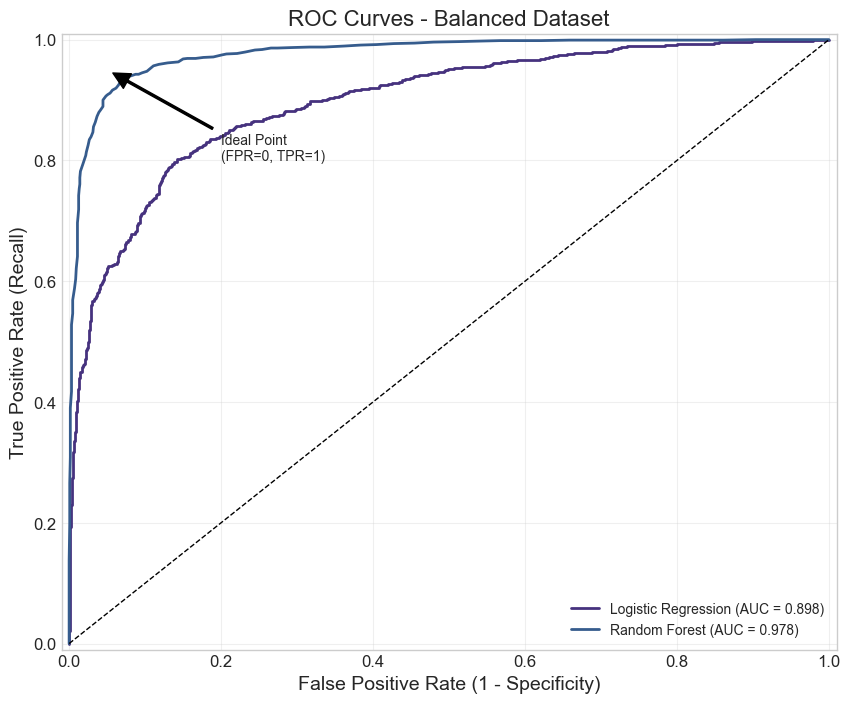

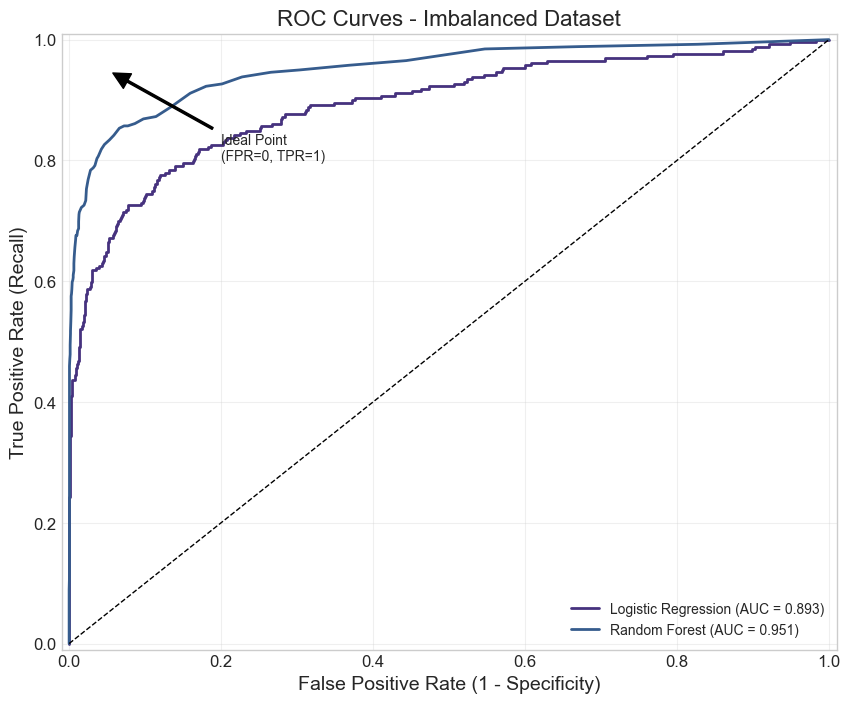

In [30]:
def plot_roc_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC = {auc:.3f})")
    
    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    
    # Add labels and legend
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(FPR=0, TPR=1)', xy=(0.05, 0.95), xytext=(0.2, 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Compare logistic regression and random forest on both datasets
balanced_models = {
    'Logistic Regression': (y_bal_test, y_bal_prob),
    'Random Forest': (y_bal_test, y_bal_prob_rf)
}

imbalanced_models = {
    'Logistic Regression': (y_imb_test, y_imb_prob),
    'Random Forest': (y_imb_test, y_imb_prob_rf)
}

plot_roc_curves(balanced_models, "ROC Curves - Balanced Dataset")
plot_roc_curves(imbalanced_models, "ROC Curves - Imbalanced Dataset")

### Curva Precision-Recall <a id="pr-curve"></a>

La curva Precision-Recall (PR) traccia la precisione rispetto al recall a diverse impostazioni di soglia. È particolarmente utile per set di dati sbilanciati in cui la curva ROC potrebbe essere eccessivamente ottimistica.



La **Curva Precision-Recall (PR)** è una visualizzazione utile per valutare le prestazioni di un modello di classificazione, in particolare quando si lavora con **set di dati sbilanciati**. La curva traccia la **precisione** rispetto al **richiamo** (recall) a diverse impostazioni di soglia, e viene spesso utilizzata come alternativa alla **curva ROC**.

#### 1. **Precisione e Richiamo**

Per comprendere la curva Precision-Recall, è utile ripassare prima cosa rappresentano **precisione** e **richiamo**:

- **Precisione**: La precisione è la frazione di predizioni positive corrette rispetto a tutte le predizioni positive fatte dal modello. In altre parole, di tutte le istanze che il modello ha classificato come positive, quante erano effettivamente positive?
  \[
  \text{Precisione} = \frac{TP}{TP + FP}
  \]
  dove:
  - **TP (True Positives)**: i casi positivi correttamente identificati dal modello.
  - **FP (False Positives)**: i casi negativi erroneamente etichettati come positivi.

- **Richiamo (Recall)**: Il richiamo è la frazione di istanze positive effettive correttamente identificate dal modello. In altre parole, di tutte le istanze che sono effettivamente positive, quante il modello ha classificato correttamente come positive?
  \[
  \text{Richiamo} = \frac{TP}{TP + FN}
  \]
  dove:
  - **FN (False Negatives)**: i casi positivi erroneamente etichettati come negativi.

#### 2. **Perché la Curva Precision-Recall è utile?**

La **curva Precision-Recall** è particolarmente utile quando si lavora con **set di dati sbilanciati**, ovvero quando una delle classi (di solito la classe negativa) è molto più rappresentata rispetto all'altra (la classe positiva). 

Nel caso di set di dati sbilanciati, la **curva ROC** potrebbe non essere sufficientemente informativa. Infatti, in un set di dati sbilanciato, anche un modello che fa molte previsioni errate per la classe positiva potrebbe comunque apparire molto buono sulla curva ROC, perché potrebbe riuscire a classificare correttamente la maggior parte degli esempi della classe negativa (che è la classe maggioritaria).

Invece, la curva Precision-Recall si concentra esclusivamente sulla **classe positiva**, ed è quindi più adatta per problemi dove l'accuratezza nella previsione della classe positiva è importante, come nelle situazioni in cui:
- La classe positiva è quella di interesse (ad esempio, rilevare frodi, malattie, o altri eventi rari).
- Le **predizioni false negative** (FN) sono particolarmente costose o problematiche (ad esempio, non rilevare una frode o una malattia).

#### 3. **Interpretazione della Curva Precision-Recall**

La curva Precision-Recall mostra come varia la **precisione** e il **richiamo** al variare della soglia di decisione del modello. La soglia è il valore sopra il quale il modello classifica una previsione come positiva. Se la soglia è bassa, il modello sarà più incline a classificare le istanze come positive (aumentando il richiamo), ma la precisione potrebbe diminuire poiché ci saranno più falsi positivi. Se la soglia è alta, il modello farà meno previsioni positive (riducendo il richiamo), ma potrebbe aumentare la precisione poiché le previsioni positive saranno più sicure (meno falsi positivi).

**Caratteristiche da notare nella Curva PR**:
- **Precisione alta e richiamo basso**: Quando la soglia è alta, il modello farà meno previsioni positive, aumentando la precisione (poiché le previsioni positive saranno più accurate), ma riducendo il richiamo.
- **Precisione bassa e richiamo alto**: Quando la soglia è bassa, il modello classificherà molte più istanze come positive, aumentando il richiamo (poiché si riduce il numero di falsi negativi), ma riducendo la precisione (poiché ci saranno più falsi positivi).

La **curva PR** permette quindi di valutare **quale compromesso** il modello fa tra **precisione** e **richiamo** a diverse soglie.

#### 4. **Vantaggi della Curva Precision-Recall**

- **Semplice da interpretare**: la curva Precision-Recall fornisce una valutazione chiara di quanto il modello stia identificando correttamente la classe positiva e quanto stia evitando di fare errori di tipo falso positivo.
- **Migliore per set di dati sbilanciati**: quando ci sono molte più istanze della classe negativa rispetto alla classe positiva, la curva Precision-Recall fornisce una valutazione più accurata delle prestazioni del modello sulla classe di interesse (la classe positiva).
- **Focalizzata sulla classe positiva**: mentre la curva ROC tiene conto sia dei veri positivi che dei falsi positivi (e quindi può essere influenzata dalla classe negativa), la curva PR si concentra solo sulla classe positiva, che spesso è l'oggetto principale del nostro interesse.

#### 5. **AUC della Precision-Recall Curve**

Esattamente come l'AUC della curva ROC, anche l'AUC della Precision-Recall Curve fornisce una singola metrica per sintetizzare le prestazioni del modello. Un AUC più alto indica che il modello sta distinguendo meglio tra le classi.

- **AUC PR alto**: un valore più alto dell'AUC della PR curve suggerisce che il modello ha una buona capacità di identificare le istanze positive mentre evita di classificare erroneamente istanze negative come positive.
- **AUC PR basso**: un valore basso dell'AUC indica che il modello ha difficoltà a identificare correttamente le istanze positive e/o a evitare falsi positivi.

#### 6. **Differenze tra Curva ROC e PR Curve**

- **Curva ROC**: La curva ROC è più utile quando le classi sono bilanciate, in quanto considera sia i veri positivi che i falsi positivi. È anche più sensibile al numero di veri negativi, il che potrebbe renderla fuorviante per i set di dati sbilanciati.
  
- **Curva PR**: La curva Precision-Recall è preferibile per **set di dati sbilanciati**, poiché si concentra esclusivamente sulle prestazioni relative alla classe positiva. Non è influenzata dal numero di veri negativi ed è quindi più affidabile quando le classi sono sbilanciate.

### In sintesi:
- La **curva Precision-Recall** è una visualizzazione fondamentale per valutare un modello di classificazione quando le classi sono sbilanciate.
- Traccia la **precisione** rispetto al **richiamo** per diverse soglie di classificazione.
- È particolarmente utile per applicazioni in cui la **classe positiva** è rara ma di grande interesse (es. rilevamento di frodi, diagnosi di malattie rare, etc.).
- A differenza della **curva ROC**, la **PR curve** non è influenzata dal numero di veri negativi, quindi fornisce una misura più robusta delle prestazioni per set di dati sbilanciati.

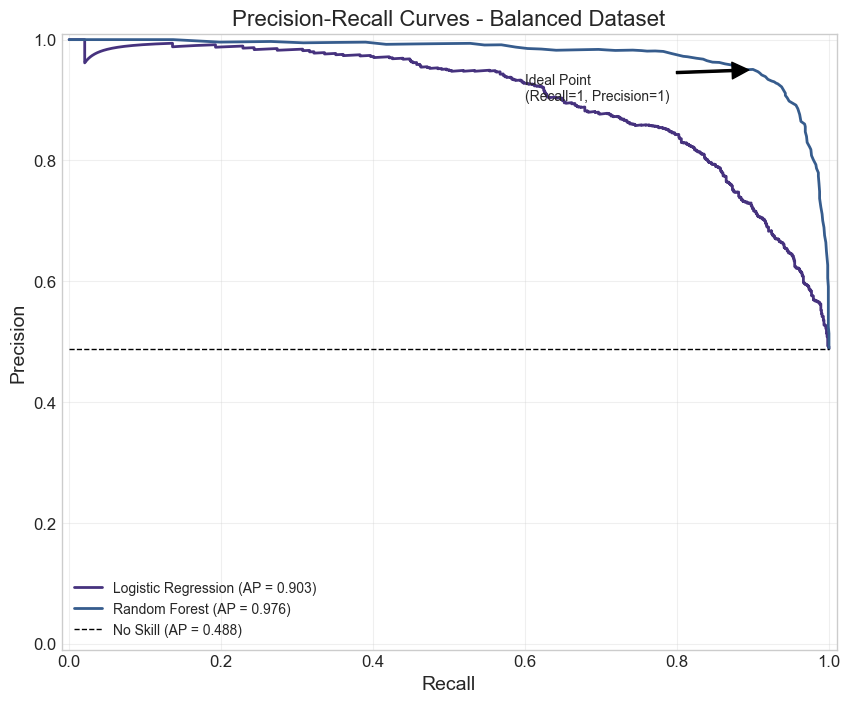

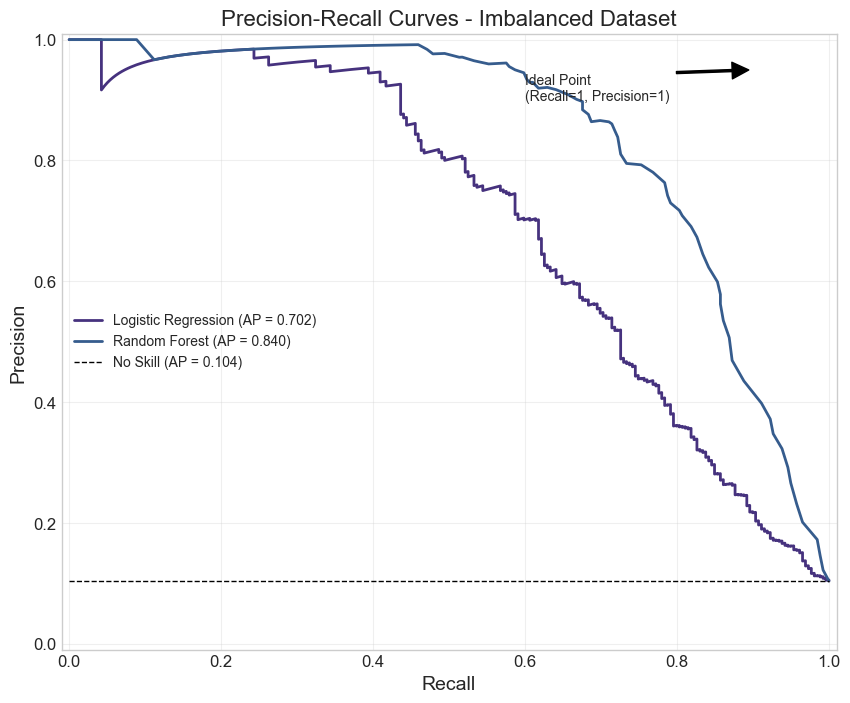

In [31]:
def plot_pr_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate PR curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        
        # Plot PR curve
        plt.plot(recall, precision, linewidth=2, label=f"{label} (AP = {ap:.3f})")
    
    # Add baseline (no-skill classifier)
    no_skill = sum(y_true) / len(y_true)  # Frequency of positive class
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=1, label=f'No Skill (AP = {no_skill:.3f})')
    
    # Add labels and legend
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(Recall=1, Precision=1)', xy=(0.9, 0.95), xytext=(0.6, 0.9),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot PR curves for both datasets
plot_pr_curves(balanced_models, "Precision-Recall Curves - Balanced Dataset")
plot_pr_curves(imbalanced_models, "Precision-Recall Curves - Imbalanced Dataset")

## 1.5 Compromessi nella valutazione della classificazione <a id="tradeoffs"></a>

Approfondiamo i compromessi tra diverse metriche di performance e concentriamoci in particolare su quando utilizzare le curve ROC rispetto a quelle PR.


Usa la curva ROC quando:

Il set di dati è bilanciato, con una distribuzione simile delle classi positive e negative.
Vuoi avere una visione generale delle prestazioni del modello su entrambe le classi.
Sei interessato a come il modello bilancia i tassi di falsi positivi e veri positivi in generale.

Usa la curva Precision-Recall quando:

Il set di dati è sbilanciato, con una classe molto più numerosa rispetto all'altra.
Sei principalmente interessato a classificare correttamente la classe positiva e a minimizzare i falsi positivi o i falsi negativi per questa classe.
La classe positiva è di particolare interesse (ad esempio, la diagnosi di malattie rare o il rilevamento di frodi).

In definitiva, se stai lavorando con classi sbilanciate, la curva PR è solitamente la scelta migliore per ottenere una valutazione accurata delle prestazioni del tuo modello sulla classe di interesse. Se invece le classi sono equilibrate, la curva ROC può fornirti una panoramica completa delle prestazioni del modello.


In [32]:
def analyze_thresholds(y_true, y_prob, thresholds, model_name, dataset_name, num_points=10):
    # Select a subset of thresholds to analyze
    indices = np.linspace(0, len(thresholds) - 1, num_points, dtype=int)
    selected_thresholds = thresholds[indices]
    
    # Calculate metrics for each threshold
    results = []
    for threshold in selected_thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/Sensitivity
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * precision * tpr / (precision + tpr) if (precision + tpr) > 0 else 0
        
        results.append({
            'Threshold': threshold,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
            'Precision': precision,
            'Recall (TPR)': tpr,
            'Specificity (TNR)': tnr,
            'FPR': fpr,
            'F1 Score': f1
        })
    
    # Convert to DataFrame for better display
    results_df = pd.DataFrame(results)
    print(f"Threshold analysis for {model_name} on {dataset_name}:")
    return results_df

# Analyze thresholds for Logistic Regression on imbalanced dataset
precision, recall, thresholds = precision_recall_curve(imbalanced_models['Logistic Regression'][0], imbalanced_models['Logistic Regression'][1])

log_reg_imb_thresholds = analyze_thresholds(
    y_imb_test, 
    imbalanced_models['Logistic Regression'][1],
    thresholds,
    'Logistic Regression',
    'Imbalanced Dataset'
)

# Display the results
pd.set_option('display.precision', 3)
display(log_reg_imb_thresholds[['Threshold', 'Precision', 'Recall (TPR)', 'Specificity (TNR)', 'F1 Score']])

Threshold analysis for Logistic Regression on Imbalanced Dataset:


,Threshold,Precision,Recall (TPR),Specificity (TNR),F1 Score
0,2.186e-04,0.104,1.000,0.000,0.188
1,4.931e-03,0.114,0.981,0.121,0.205
2,9.824e-03,0.129,0.969,0.244,0.228
3,1.660e-02,0.150,0.965,0.368,0.260
4,2.563e-02,0.173,0.927,0.487,0.291
5,3.899e-02,0.210,0.903,0.608,0.341
6,6.171e-02,0.267,0.861,0.727,0.408
7,1.103e-01,0.370,0.795,0.843,0.505
8,2.413e-01,0.602,0.649,0.950,0.625
9,9.991e-01,1.000,0.004,1.000,0.008


In [ ]:
def plot_threshold_tradeoffs(threshold_df):
    plt.figure(figsize=(12, 7))
    
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Recall (TPR)'], 'r-', label='Recall (TPR)')
    plt.plot(threshold_df['Threshold'], threshold_df['Specificity (TNR)'], 'g-', label='Specificity (TNR)')
    plt.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 'y-', label='F1 Score')
    
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3, label='Default Threshold (0.5)')
    
    plt.xlabel('Classification Threshold')
    plt.ylabel('Metric Value')
    plt.title('How Classification Metrics Change with Threshold')
    plt.legend(loc='center right')
    plt.grid(True, alpha=0.3)
    
    # Add annotation about the decision point
    f1_max_idx = threshold_df['F1 Score'].argmax()
    optimal_threshold = threshold_df.iloc[f1_max_idx]['Threshold']
    
    plt.scatter(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score'], 
                s=100, c='black', marker='*')
    plt.annotate(f'Optimal F1 Threshold: {optimal_threshold:.3f}', 
                 xy=(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score']),
                 xytext=(optimal_threshold+0.2, threshold_df.iloc[f1_max_idx]['F1 Score']-0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot the threshold tradeoffs
plot_threshold_tradeoffs(log_reg_imb_thresholds)

### Approfondimenti chiave sulle curve ROC

1. **Interpretazione della curva ROC**:
- La linea diagonale rappresenta un classificatore casuale (AUC = 0,5)
- Le curve più vicine all'angolo in alto a sinistra indicano prestazioni migliori (AUC più vicina a 1,0)
- L'area sotto la curva (AUC) fornisce un singolo numero per confrontare i modelli

2. **Compromessi nella selezione della soglia**:
- Soglie più basse: maggiore richiamo (TPR), ma anche maggiori falsi positivi (FPR)
- Soglie più alte: minori falsi positivi, ma anche minore richiamo
- La soglia "migliore" dipende dai costi specifici dei falsi positivi rispetto ai falsi negativi nella tua applicazione

3. **Limitazioni delle curve ROC**:
- Possono essere fuorvianti per set di dati sbilanciati
- Non mostrano direttamente la precisione, che è spesso importante in scenari sbilanciati


Approfondiamo ogni punto per una comprensione più dettagliata:

#### 1. **Interpretazione della curva ROC**:

- **Linea diagonale (AUC = 0,5)**: La linea diagonale nella curva ROC rappresenta il comportamento di un **classificatore casuale**, che non ha alcuna capacità di distinguere tra le classi positive e negative. In altre parole, un modello che sceglie casualmente tra classi avrà un AUC di **0,5**, che indica una **performance nulla**.
  
- **Curve più vicine all'angolo in alto a sinistra**: L'angolo in alto a sinistra rappresenta il punto ideale della curva ROC, dove il **tasso di veri positivi** (recall) è massimo e il **tasso di falsi positivi** è minimo. Se la curva si avvicina a questo angolo, significa che il modello è in grado di separare bene le classi positiva e negativa, con pochi falsi positivi e un buon numero di veri positivi.
  
- **AUC (Area Under the Curve)**: L'AUC è una singola misura che fornisce un'indicazione complessiva delle prestazioni di un modello su tutte le possibili soglie di classificazione. 
  - Un AUC di **1,0** significa che il modello è perfetto, separando perfettamente le classi.
  - Un AUC di **0,5** indica che il modello è equivalente a un classificatore casuale.
  - Un AUC inferiore a **0,5** suggerisce che il modello sta effettivamente classificando le osservazioni in modo peggiore di un classificatore casuale.

#### 2. **Compromessi nella selezione della soglia**:

- **Soglie più basse**:
  - Quando imposti una **soglia bassa** per predire la classe positiva, il modello tende a classificare più esempi come positivi, aumentando così il **tasso di veri positivi (TPR)**, cioè il **richiamo**.
  - Tuttavia, questo porta anche a un aumento dei **falsi positivi (FPR)**, cioè a classificare erroneamente alcune osservazioni negative come positive. 
  - Quindi, con una soglia bassa, avrai un buon **richiamo**, ma la **precisione** potrebbe scendere.

- **Soglie più alte**:
  - Se alzi la **soglia**, il modello diventa più esigente nel classificare un esempio come positivo, il che riduce i **falsi positivi** (migliora la precisione).
  - Tuttavia, questo riduce anche il **tasso di veri positivi (TPR)**, ossia il **richiamo**, poiché alcuni veri positivi non verranno più classificati come positivi.
  - In altre parole, avrai una **precisione maggiore**, ma a scapito di una minore capacità di identificare tutti i casi positivi.

- **La soglia "migliore"** dipende dai **costi specifici** di errori di tipo **falso positivo** (FP) e **falso negativo** (FN) nella tua applicazione. Ad esempio:
  - Se un **falso negativo** (ad esempio, non identificare una frode) è molto costoso, è meglio scegliere una **soglia bassa** per massimizzare il richiamo.
  - Se un **falso positivo** (ad esempio, segnalare erroneamente una persona sana come malata) ha un costo elevato, allora è meglio scegliere una **soglia più alta** per massimizzare la precisione.

#### 3. **Limitazioni delle curve ROC**:

- **Set di dati sbilanciati**:
  - La curva ROC può essere **fuorviante** in presenza di **set di dati sbilanciati** (dove una delle classi è molto più rappresentata dell'altra). In tali casi, la curva ROC potrebbe dare l'impressione che il modello stia performando molto bene, anche se sta trascurando completamente la classe minoritaria. Ad esempio, se hai un dataset in cui il 95% delle osservazioni sono negative, un modello che classifica tutte le osservazioni come negative avrà comunque un AUC alto, ma non sta identificando la classe positiva (la minoritaria).
  
- **Non mostra direttamente la precisione**:
  - La curva ROC non prende in considerazione direttamente la **precisione**, che è una metrica importante in scenari sbilanciati. La precisione misura quante delle predizioni positive siano effettivamente corrette, ed è una metrica cruciale quando il costo di falsi positivi è elevato (ad esempio, se un'azienda deve evitare falsi allarmi in un sistema di rilevamento di frodi).
  - Mentre la curva ROC mostra come variano il **tasso di veri positivi** e il **tasso di falsi positivi** al variare della soglia, non ti dice nulla sulla **precisione** (quanto sono accurate le tue previsioni per la classe positiva).

#### Conclusioni:

La curva ROC è potente e utile quando:
- Le classi sono bilanciate.
- Si desidera una panoramica delle prestazioni complessive del modello.
- Non è fondamentale distinguere tra precisione e richiamo, ma si vuole capire come il modello gestisce entrambi i tipi di errori.

Tuttavia, quando si ha un **set di dati sbilanciato**, la curva ROC può essere **meno informativa** e **fuorviante**. In questi casi, la **curva Precision-Recall (PR)** o **altri indicatori** (come precisione e richiamo) potrebbero essere più utili per una valutazione accurata del modello.

In [2]:
# Summary of key classification metrics and when to use them

metrics_summary = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 
        'F1 Score', 'AUC-ROC', 'Average Precision (AP)', 'Balanced Accuracy'
    ],
    'Description': [
        'Proportion of correct predictions (TP+TN)/(TP+TN+FP+FN)',
        'Proportion of positive predictions that are correct TP/(TP+FP)',
        'Proportion of actual positives correctly identified TP/(TP+FN)',
        'Proportion of actual negatives correctly identified TN/(TN+FP)',
        'Harmonic mean of precision and recall 2*(P*R)/(P+R)',
        'Area under the ROC curve (TPR vs FPR)',
        'Area under the precision-recall curve',
        'Average of recall and specificity (TPR+TNR)/2'
    ],
    'When to Use': [
        'Balanced datasets, equal misclassification costs',
        'When false positives are costly (spam detection, content filtering)',
        'When false negatives are costly (disease detection, fraud monitoring)',
        'When correctly identifying negatives is important (medical screening)',
        'When balance between precision and recall is needed, imbalanced datasets',
        'Model comparison, balanced datasets, ranking performance',
        'Imbalanced datasets, focus on positive class performance',
        'Imbalanced datasets, when both classes are important'
    ]
})

pd.set_option('display.max_colwidth',100)  
display(metrics_summary)

NameError: name 'pd' is not defined

## 1.6 Conclusione: punti chiave per le metriche di classificazione

1. **Nessuna metrica perfetta**: la scelta della metrica di valutazione dovrebbe essere in linea con il tuo problema specifico e i requisiti aziendali. Non esiste un approccio valido per tutti.

2. **Comprendere lo squilibrio di classe**: lo squilibrio di classe influisce in modo significativo sulle metriche più informative. L'accuratezza può essere fuorviante con dati sbilanciati.

3. **Considerare il costo degli errori**: diversi tipi di errori (falsi positivi vs. falsi negativi) hanno spesso costi reali diversi. Le tue metriche dovrebbero riflettere questi costi.

4. **Curve ROC vs. PR**:
- Le curve ROC sono migliori per set di dati bilanciati e quando entrambe le classi sono importanti
- Le curve PR sono migliori per set di dati non bilanciati e quando la classe positiva è più importante

5. **Selezione della soglia**: la scelta della soglia giusta implica la comprensione dei compromessi tra le metriche e dovrebbe basarsi sui requisiti specifici della tua applicazione.

6. **Oltre la classificazione binaria**: per problemi multi-classe, considera metriche come medie macro/micro/ponderate di metriche per classe, matrici di confusione e Kappa di Cohen.

7. **Valuta con più metriche**: usa una combinazione di metriche per ottenere una visione completa delle prestazioni del modello anziché ottimizzare per una singola metrica.

8. **Il contesto è importante**: interpreta sempre le metriche nel contesto del tuo dominio di problemi specifico e delle prestazioni di base.

Comprendendo queste metriche di valutazione e i relativi compromessi, puoi prendere decisioni più consapevoli sulla selezione del modello e sull'ottimizzazione della soglia per il tuo caso d'uso specifico.

## 1.7 Esempio di scenario reale: rilevamento delle frodi

In [3]:
# Let's create a practical example of how threshold selection impacts a real-world scenario
def threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost):
    """
    Simulates a business case to show how threshold selection impacts outcomes.
    """
    # Let's simulate a fraud detection scenario
    np.random.seed(42)
    
    # Create synthetic data for a fraud detection case
    # Assume 5% of transactions are fraudulent
    n_samples = 100000
    n_fraud = int(n_samples * 0.05)
    n_legitimate = n_samples - n_fraud
    
    # Generate probabilities for fraudulent transactions (higher scores)
    fraud_probs = np.random.beta(2, 5, n_fraud)
    # Shift to make them higher probability
    fraud_probs = 0.3 + fraud_probs * 0.7
    
    # Generate probabilities for legitimate transactions (lower scores)
    legitimate_probs = np.random.beta(2, 10, n_legitimate)
    # Shift to make them lower probability
    legitimate_probs = legitimate_probs * 0.8
    
    # Combine data
    y_true = np.array([1] * n_fraud + [0] * n_legitimate)
    y_prob = np.concatenate([fraud_probs, legitimate_probs])
    
    # Shuffle data
    idx = np.random.permutation(len(y_true))
    y_true = y_true[idx]
    y_prob = y_prob[idx]
    
    # Define function to calculate business impact
    def calculate_impact(threshold):
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate costs
        undetected_fraud_cost = fn * avg_transaction * fraud_cost_multiple
        review_cost_total = (tp + fp) * review_cost
        total_cost = undetected_fraud_cost + review_cost_total
        
        # Calculate other metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        return {
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'false_positives': fp,
            'false_negatives': fn,
            'undetected_fraud_cost': undetected_fraud_cost,
            'review_cost': review_cost_total,
            'total_cost': total_cost
        }
    
    # Calculate impact for various thresholds
    thresholds = np.linspace(0.1, 0.9, 17)
    impacts = [calculate_impact(t) for t in thresholds]
    
    # Extract values for plotting
    precision_values = [imp['precision'] for imp in impacts]
    recall_values = [imp['recall'] for imp in impacts]
    undetected_fraud_costs = [imp['undetected_fraud_cost'] for imp in impacts]
    review_costs = [imp['review_cost'] for imp in impacts]
    total_costs = [imp['total_cost'] for imp in impacts]
    
    # Find optimal threshold for minimizing total cost
    best_idx = np.argmin(total_costs)
    best_threshold = thresholds[best_idx]
    
    # Plot business impact
    plt.figure(figsize=(15, 12))


    # Plot 1: Precision and Recall vs Threshold
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, precision_values, 'g-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall_values, 'r-', label='Recall', linewidth=2)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.title('Precision and Recall vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    # Plot 2: Costs vs Threshold
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, np.array(undetected_fraud_costs)/1000, 'r-', 
             label='Undetected Fraud Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(review_costs)/1000, 'g-', 
             label='Review Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(total_costs)/1000, 'b-', 
             label='Total Cost (thousands $)', linewidth=3)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    # Highlight minimum cost point
    plt.scatter(best_threshold, total_costs[best_idx]/1000, color='blue', s=100, zorder=5)
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Cost (thousands $)', fontsize=12)
    plt.title('Business Costs vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


    # Print analysis of different thresholds
    print("\n--- Business Impact Analysis ---")
    print(f"Optimal threshold for minimizing total cost: {best_threshold:.3f}")
    
    # Compare with metrics-based thresholds
    best_f1_idx = np.argmax([2 * (p * r) / (p + r) if (p + r) > 0 else 0 
                           for p, r in zip(precision_values, recall_values)])
    best_f1_threshold = thresholds[best_f1_idx]
    
    low_threshold = 0.2
    high_threshold = 0.8
    
    # Get results for different thresholds
    low_result = calculate_impact(low_threshold)
    high_result = calculate_impact(high_threshold)
    f1_result = calculate_impact(best_f1_threshold)
    optimal_result = impacts[best_idx]
    
    # Create comparison table
    from tabulate import tabulate
    
    table_data = [
        ["Low (0.2)", f"{low_result['precision']:.3f}", f"{low_result['recall']:.3f}", 
         f"{low_result['false_positives']}", f"{low_result['false_negatives']}", 
         f"${low_result['total_cost']:,.2f}"],
        ["High (0.8)", f"{high_result['precision']:.3f}", f"{high_result['recall']:.3f}", 
         f"{high_result['false_positives']}", f"{high_result['false_negatives']}", 
         f"${high_result['total_cost']:,.2f}"],
        [f"F1-optimal ({best_f1_threshold:.2f})", f"{f1_result['precision']:.3f}", 
         f"{f1_result['recall']:.3f}", f"{f1_result['false_positives']}", 
         f"{f1_result['false_negatives']}", f"${f1_result['total_cost']:,.2f}"],
        [f"Cost-optimal ({best_threshold:.2f})", f"{optimal_result['precision']:.3f}", 
         f"{optimal_result['recall']:.3f}", f"{optimal_result['false_positives']}", 
         f"{optimal_result['false_negatives']}", f"${optimal_result['total_cost']:,.2f}"]
    ]
    
    headers = ["Threshold", "Precision", "Recall", "False Positives", "False Negatives", "Total Cost"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    print("\nKey insights:")
    print("1. The cost-optimal threshold balances the costs of manual reviews and undetected fraud")
    print("2. Using a technical metric like F1 score may not lead to the optimal business outcome")
    print(f"3. In this scenario, the cost-optimal threshold ({best_threshold:.2f}) differs from the F1-optimal threshold ({best_f1_threshold:.2f})")
    print("4. Low thresholds lead to higher recall but more false positives (higher review costs)")
    print("5. High thresholds lead to higher precision but more false negatives (higher fraud costs)")
    print("6. The optimal threshold depends on the specific business costs and should be adjusted as these costs change")



# Business impact parameters (fictional values)

avg_transaction = 200  # Average transaction amount: $100
fraud_cost_multiple = 1  # Cost of undetected fraud is 2.5x the transaction amount
review_cost = 190  # Cost to manually review a transaction: $120

threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost)

NameError: name 'np' is not defined

#### SPIEGAZIONE CODICE SOPRA
Questo codice simula l'impatto di diverse soglie (threshold) sulla classificazione di transazioni fraudolente in un contesto aziendale. L'obiettivo principale è analizzare come la selezione della soglia di classificazione influenzi le **metriche di precisione**, **richiamo** e **costo totale**, in modo da ottimizzare la scelta della soglia che minimizza i costi aziendali. Ecco un riassunto dei passaggi principali:

### 1. **Simulazione di Dati Sintetici**
   - **Transazioni fraudolente** e **legittime** vengono simulate:
     - Il 5% delle transazioni è fraudolento.
     - Le probabilità di transazioni fraudolente e legittime sono generate casualmente (usando distribuzioni Beta) per riflettere una probabilità di frode più alta e una probabilità di legittimità più bassa.
     - Le probabilità vengono "shifdate" per fare in modo che i dati fraudolenti abbiano probabilità più alte e quelli legittimi probabilità più basse.

### 2. **Calcolo dei Costi e Metriche**
   - Viene definita una funzione `calculate_impact(threshold)` che calcola:
     - **Confusion Matrix**: calcola veri positivi, falsi positivi, falsi negativi e veri negativi.
     - **Costi**: 
       - **Costi di frode non rilevata** (se una frode non viene identificata).
       - **Costi di revisione** (quando una transazione viene erroneamente classificata come fraudolenta).
     - **Precisione** e **Richiamo** per la classificazione, che sono metriche classiche di performance.
   
### 3. **Calcolo per Diverse Soglie**
   - La funzione esegue il calcolo per vari valori di soglia, tra 0.1 e 0.9, e salva i risultati per ciascuna soglia, tra cui:
     - Precisione e Richiamo.
     - Costi di frode non rilevata, costi di revisione e costo totale.
   
### 4. **Ottimizzazione della Soglia**
   - Viene trovato il valore ottimale di soglia che **minimizza il costo totale** (somma dei costi di frode non rilevata e di revisione).
   - Viene anche calcolato il valore di soglia che ottimizza la **F1-score** (media armonica di precisione e richiamo).
   
### 5. **Visualizzazione dei Risultati**
   - Il codice genera due grafici:
     - **Precisione e Recall vs Soglia**.
     - **Costi vs Soglia**, che mostra come i costi di frode non rilevata, di revisione e il costo totale variano al variare della soglia.
   - I grafici mostrano anche la soglia ottimale dal punto di vista del costo.

### 6. **Analisi dei Risultati**
   - Viene presentata una tabella che compara le metriche (Precisione, Recall, Falsi Positivi, Falsi Negativi, Costo Totale) per:
     - Una soglia bassa (0.2).
     - Una soglia alta (0.8).
     - La soglia ottimale per F1-score.
     - La soglia ottimale per minimizzare il costo.
   
   - **Insights chiave**: 
     - Viene sottolineato che **la soglia ottimale per il costo** potrebbe differire dalla soglia ottimale per il **F1-score**.
     - Si evidenzia l'importanza di bilanciare i costi di frode non rilevata e di revisione, e come i costi aziendali influenzino la scelta della soglia.

### 7. **Output Finale**
   - Il codice mostra i grafici e stampa una tabella di confronto delle diverse soglie, evidenziando come la scelta della soglia possa influire sui costi aziendali.

### Scopo del Codice
   - Questo codice è progettato per **simulare e visualizzare l'impatto della scelta della soglia** in un contesto di rilevamento delle frodi. Consente di capire come le decisioni sulla soglia di classificazione influenzano il trade-off tra precisione, richiamo e costi aziendali associati al rilevamento delle frodi e alla revisione delle transazioni.

## BREAK

## 2. Valutazione delle metriche di regressione

# BREAK

## 3. Tecniche di convalida <a id="validation"></a>

Ora che abbiamo capito come misurare le prestazioni del nostro modello, esploriamo diverse tecniche di convalida che aiutano a garantire che il nostro modello si generalizzi bene ai nuovi dati.

### Validazione Hold-Out

La forma più semplice di convalida è la convalida Hold-out, che abbiamo già implementato suddividendo i nostri dati in set di training, convalida e test.

- **Set di training**: utilizzato per addestrare il modello
- **Set di convalida**: utilizzato per ottimizzare gli iperparametri e valutare durante lo sviluppo
- **Set di test**: utilizzato solo una volta alla fine per ottenere una stima imparziale delle prestazioni del modello

Sebbene semplice, la convalida Hold-out può essere problematica se:
- Il tuo set di dati è piccolo
- La suddivisione non rappresenta la distribuzione complessiva dei dati
- Devi ottimizzare molti iperparametri, il che potrebbe portare a un overfitting del set di convalida



La **validazione Hold-Out** è un metodo semplice e comune per valutare le prestazioni di un modello di machine learning. Vediamo più nel dettaglio i concetti e i problemi che hai menzionato:

### 1. **Set di dati:**

In una tipica pipeline di machine learning, il set di dati viene suddiviso in tre parti principali:

- **Set di training**: Questo è il sottoinsieme dei dati utilizzato per addestrare il modello. Durante l'addestramento, il modello impara le relazioni e i pattern nei dati.
  
- **Set di convalida**: Viene utilizzato per valutare il modello durante il suo sviluppo, e serve anche per ottimizzare gli **iperparametri**. Gli iperparametri sono i parametri che non vengono appresi dal modello durante l'addestramento (come il tasso di apprendimento o la profondità di un albero decisionale) ma che devono essere impostati prima dell'addestramento.
  
- **Set di test**: Una volta che il modello è stato addestrato e ottimizzato, si usa il set di test per ottenere una valutazione finale e imparziale delle sue prestazioni. Il set di test è "mai visto" durante l'addestramento e l'ottimizzazione, quindi fornisce una stima realistica delle prestazioni del modello su dati che non ha mai incontrato.

### 2. **Problemi della validazione Hold-Out:**

Sebbene la validazione Hold-out sia facile da implementare, ci sono alcuni **svantaggi**, specialmente nei casi in cui il tuo set di dati presenta caratteristiche particolari, come un numero limitato di esempi o una distribuzione non omogenea. Ecco i principali problemi:

#### a. **Set di dati piccolo**:
Se il tuo set di dati è piccolo, la divisione in set di training, convalida e test potrebbe essere un problema. Infatti, ogni sottoinsieme dei dati diventa relativamente piccolo, il che riduce la quantità di dati che puoi usare per addestrare e testare il modello. Questo può portare a una **varianza maggiore nelle prestazioni** del modello, cioè il modello potrebbe essere molto sensibile alla divisione specifica dei dati in training, convalida e test. Ad esempio, se i dati sono distribuiti in modo non uniforme, un modello potrebbe essere addestrato con un campione che non è rappresentativo della distribuzione complessiva.

#### b. **Distribuzione dei dati non rappresentativa**:
La validazione Hold-out potrebbe non garantire che ogni sottoinsieme (training, convalida, test) rappresenti accuratamente la distribuzione complessiva dei dati. Ad esempio, supponiamo che il tuo set di dati contenga delle classi molto sbilanciate (cioè alcune classi sono molto più frequenti di altre). Se il set di test o quello di convalida finisce per non avere abbastanza esempi di alcune classi, il modello potrebbe ottenere un'idea distorta delle sue reali capacità di generalizzazione. In altre parole, potrebbe sembrare più preciso o più impreciso di quanto realmente sia.

#### c. **Ottimizzazione di molti iperparametri e rischio di overfitting**:
Quando ottimizzi molti **iperparametri** (come il tasso di apprendimento o la profondità dell'albero in un modello decisionale), la validazione Hold-out può portare a un problema chiamato **overfitting** del set di convalida. Questo accade quando il modello diventa troppo specifico per il set di convalida, migliorando troppo sulle sue prestazioni su di esso ma perdendo la capacità di generalizzare su dati nuovi. Più iterazioni di ottimizzazione sugli iperparametri possono fare sì che il modello "impari" dettagli specifici del set di convalida, il che non rappresenta più una valutazione imparziale.

### Soluzioni alternative:
Per mitigare questi problemi, ci sono tecniche più robuste, come:

- **Cross-validation (validazione incrociata)**: Qui il set di dati viene suddiviso in "fold" (tipicamente 5 o 10), e il modello viene allenato su diverse combinazioni di fold di training e convalida. Questo riduce il rischio di overfitting e fornisce una valutazione più stabile delle prestazioni del modello.
  
- **Shuffle e stratified splitting**: Se il set di dati è sbilanciato, si può fare un "split" stratificato per garantire che ogni sottoinsieme di training, convalida e test contenga una rappresentanza proporzionale di ogni classe, migliorando la generalizzazione del modello.

Spero che queste spiegazioni ti aiutino a comprendere meglio i concetti legati alla validazione Hold-out e ai suoi limiti! Se hai domande più specifiche, sono qui per rispondere.

### K-Fold Cross-Validation

La K-fold cross-validation risolve molti dei difetti della hold-out validation:
1. Dividendo i dati in K parti uguali (fold)
2. Addestrando il modello K volte, ogni volta utilizzando un fold diverso come set di convalida e i restanti K-1 fold come set di addestramento
3. Mediando le prestazioni su tutte le K esecuzioni

Questo approccio fornisce una stima delle prestazioni più solida, specialmente per set di dati più piccoli.


Certo! La **K-Fold Cross-Validation** è una tecnica molto più robusta rispetto alla validazione **Hold-Out** ed è spesso preferita per ottenere stime più precise delle prestazioni di un modello, soprattutto quando si ha a che fare con set di dati limitati. Approfondiamo il processo e vediamo come funziona nel dettaglio.

### Cos'è la K-Fold Cross-Validation?

La K-Fold Cross-Validation è una tecnica che suddivide il set di dati in **K parti uguali** (chiamate "fold") e utilizza ognuna di esse come set di convalida in modo ciclico, alternandosi tra addestramento e valutazione. Questo approccio aiuta a ridurre la varianza delle stime delle prestazioni del modello rispetto alla Hold-Out Validation, in quanto il modello viene testato su tutti i dati disponibili e non solo su un singolo sottoinsieme.

### Come funziona il processo di K-Fold Cross-Validation?

1. **Suddivisione dei dati**: 
   - I dati vengono suddivisi in **K** parti (fold) uguali o quasi uguali. Se hai, ad esempio, 1000 esempi di dati e scegli un valore di **K = 5**, ogni fold conterrà 200 esempi. Se il numero di dati non è perfettamente divisibile per K, si possono avere fold di dimensioni leggermente diverse.
   
2. **Addestramento e convalida**:
   - In ciascuna delle **K iterazioni**, il modello viene addestrato utilizzando **K-1** fold come set di addestramento e il **fold rimanente** come set di convalida.
   - Quindi, ogni volta che si ripete il processo, un fold diverso viene utilizzato come set di convalida, mentre gli altri K-1 fold vengono usati per l'addestramento del modello.
   
3. **Ripetizione**:
   - Il processo viene ripetuto per tutte le K possibili combinazioni di training e validation fold. Ad esempio, se hai 5 fold, avrai 5 cicli di addestramento/valutazione, e ogni fold sarà utilizzato come set di convalida esattamente una volta.
   
4. **Calcolo delle prestazioni finali**:
   - Dopo aver eseguito tutte le K iterazioni, le prestazioni del modello vengono **mediati** su tutte le K esecuzioni. Questo ti fornisce una stima più affidabile delle prestazioni del modello, riducendo l’effetto delle particolarità o delle anomalie di uno specifico set di test.

### Vantaggi della K-Fold Cross-Validation

- **Stima più stabile e robusta**: A differenza della Hold-Out, in cui il modello viene valutato solo su un sottoinsieme dei dati, con la K-Fold Cross-Validation il modello viene testato su più combinazioni di set di addestramento e convalida. Questo riduce il rischio che il modello venga ottimizzato su un particolare set di dati che non rappresenta bene la distribuzione complessiva.
  
- **Uso completo dei dati**: Ogni esempio nel set di dati viene utilizzato sia per il training che per la convalida, il che è particolarmente utile quando i dati sono limitati. In pratica, questo significa che ogni dato verrà "visto" dal modello durante il processo di addestramento e di test, riducendo la probabilità che l'addestramento dipenda troppo da un particolare sottoinsieme.

- **Riduzione dell’overfitting**: Poiché ogni fold serve come set di test almeno una volta, il modello ha meno probabilità di "imparare" troppo dai dettagli specifici di un particolare set di dati, riducendo così il rischio di overfitting rispetto alla validazione Hold-Out.

### Considerazioni aggiuntive:

- **Stratified K-Fold**: Se stai lavorando con un dataset sbilanciato (ad esempio, con classi che non sono distribuite equamente), potresti voler usare la **Stratified K-Fold Cross-Validation**. In questa variante, ogni fold avrà una distribuzione di classi simile a quella dell'intero set di dati, garantendo che le classi siano rappresentate proporzionalmente in ogni set di training e di convalida.

- **Computazione**: Sebbene la K-Fold Cross-Validation fornisca una stima robusta, può essere computazionalmente costosa, poiché richiede di addestrare il modello **K volte**.

### Conclusioni

La **K-Fold Cross-Validation** è una tecnica potente per valutare le prestazioni di un modello e ridurre il rischio di overfitting. Essa fornisce una valutazione più precisa e stabile rispetto alla Hold-Out Validation, specialmente in presenza di set di dati limitati. È anche utile per evitare che il modello dipenda troppo dalle particolarità di un particolare set di test, fornendo una valutazione complessiva più solida.

In [4]:
# Perform 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    # Get MSE scores for each fold
    mse_scores = -cross_val_score(model, X_train_val, y_train_val, 
                                 scoring='neg_mean_squared_error', 
                                 cv=kf, n_jobs=-1)
    
    # Get R² scores for each fold
    r2_scores = cross_val_score(model, X_train_val, y_train_val, 
                               scoring='r2', 
                               cv=kf, n_jobs=-1)
    
    cv_results[name] = {
        'MSE': mse_scores,
        'RMSE': np.sqrt(mse_scores),
        'R2': r2_scores
    }
    
    print(f"--- {name} Cross-Validation Results ---")
    print(f"MSE: {mse_scores.mean():.2f} (±{mse_scores.std():.2f})")
    print(f"RMSE: {np.sqrt(mse_scores).mean():.2f} (±{np.sqrt(mse_scores).std():.2f})")
    print(f"R²: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})\n")

NameError: name 'models' is not defined

#### SPIEGAZIONE CODICE SOPRA


### 1. **Inizializzazione di `k` e `KFold`**

```python
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
```

- **`k = 5`**: Imposta il numero di **fold** (partizioni) della K-Fold Cross-Validation a 5. In altre parole, il dataset sarà diviso in 5 parti e il modello verrà addestrato 5 volte, con ciascuna delle 5 parti usata una volta come set di test e le rimanenti 4 parti come set di addestramento.
  
- **`kf = KFold(n_splits=k, shuffle=True, random_state=42)`**:
  - **`n_splits=k`**: Imposta il numero di fold a 5.
  - **`shuffle=True`**: Mescola casualmente i dati prima di dividerli in fold, per evitare che l'ordinamento dei dati influisca sulla valutazione del modello.
  - **`random_state=42`**: Imposta un seme per il generatore di numeri casuali, in modo da ottenere una divisione riproducibile dei dati in fold. Cambiando il seme si ottengono divisioni diverse.

### 2. **Dizionario per memorizzare i risultati della cross-validation**

```python
cv_results = {}
```

- Crea un dizionario vuoto chiamato **`cv_results`**. Questo dizionario sarà usato per memorizzare i risultati delle performance (MSE, RMSE, R²) per ciascun modello che verrà valutato.

### 3. **Ciclo per ogni modello nel dizionario `models`**

```python
for name, model in models.items():
```

- Questo ciclo scorre ogni **modello** presente nel dizionario **`models`**. Per ogni modello, vengono eseguite le operazioni di cross-validation.
  - **`name`**: il nome del modello.
  - **`model`**: l'oggetto del modello stesso (ad esempio, una regressione lineare, un albero decisionale, ecc.).

### 4. **Calcolo dei punteggi MSE per ogni fold**

```python
mse_scores = -cross_val_score(model, X_train_val, y_train_val, 
                               scoring='neg_mean_squared_error', 
                               cv=kf, n_jobs=-1)
```

- **`cross_val_score`** è una funzione che esegue la cross-validation e restituisce un array con le prestazioni del modello per ciascun fold.
  - **`model`**: il modello da valutare.
  - **`X_train_val`** e **`y_train_val`**: i dati di addestramento e il target (etichetta) di addestramento, che sono usati per l'addestramento e la validazione del modello.
  - **`scoring='neg_mean_squared_error'`**: Imposta il tipo di punteggio da calcolare. Qui viene usato l'errore quadratico medio negativo (**MSE**). Nota che `cross_val_score` minimizza il punteggio per default, quindi viene usato **`neg_mean_squared_error`** per restituire un punteggio negativo (poiché MSE è un errore, il punteggio viene invertito per essere minimizzato).
  - **`cv=kf`**: Indica che deve essere utilizzato il generatore di fold definito prima (KFold).
  - **`n_jobs=-1`**: Esegue il calcolo in parallelo su più core del processore, accelerando l'esecuzione del codice, soprattutto quando i dati sono grandi.

- Il risultato **`mse_scores`** contiene i punteggi di MSE per ogni fold. La funzione **`cross_val_score`** restituisce un array con un valore di MSE per ciascun fold. Poiché il MSE è negativo, viene moltiplicato per **`-1`** per ripristinare il segno positivo.

### 5. **Calcolo dei punteggi R² per ogni fold**

```python
r2_scores = cross_val_score(model, X_train_val, y_train_val, 
                             scoring='r2', 
                             cv=kf, n_jobs=-1)
```

- Questa riga calcola il punteggio **R²** (coefficiente di determinazione) per ogni fold:
  - **`scoring='r2'`**: Imposta il tipo di punteggio da calcolare come **R²**, che misura quanto bene il modello si adatta ai dati.
  - Come prima, **`cv=kf`** e **`n_jobs=-1`** sono utilizzati per eseguire la cross-validation e calcolare il punteggio in parallelo.

### 6. **Memorizzazione dei risultati nel dizionario**

```python
cv_results[name] = {
    'MSE': mse_scores,
    'RMSE': np.sqrt(mse_scores),
    'R2': r2_scores
}
```

- Per ogni modello, vengono memorizzati i punteggi MSE, RMSE (Radice dell'errore quadratico medio) e R² nel dizionario **`cv_results`**. 
  - **`'MSE'`**: contiene i punteggi MSE per ogni fold.
  - **`'RMSE'`**: contiene i punteggi RMSE, che vengono calcolati come la radice quadrata dei punteggi MSE per ogni fold (`np.sqrt(mse_scores)`).
  - **`'R2'`**: contiene i punteggi R² per ogni fold.

### 7. **Stampa dei risultati per ciascun modello**

```python
print(f"--- {name} Cross-Validation Results ---")
print(f"MSE: {mse_scores.mean():.2f} (±{mse_scores.std():.2f})")
print(f"RMSE: {np.sqrt(mse_scores).mean():.2f} (±{np.sqrt(mse_scores).std():.2f})")
print(f"R²: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})\n")
```

- Viene stampato un riepilogo dei risultati per ciascun modello:
  - **`{name}`**: il nome del modello.
  - **MSE**: la media dei punteggi MSE per tutti i fold e la deviazione standard di questi punteggi.
  - **RMSE**: la media dei punteggi RMSE e la deviazione standard.
  - **R²**: la media dei punteggi R² e la deviazione standard.

- **`.mean()`** calcola la media dei punteggi ottenuti per ogni fold, mentre **`.std()`** calcola la deviazione standard, che indica quanto i punteggi variano tra i fold.

### Conclusioni

In sintesi, questo codice esegue la **K-Fold Cross-Validation** su una serie di modelli (contenuti nel dizionario `models`), calcolando per ciascun modello:
- L'**Errore Quadratico Medio (MSE)**, che misura quanto il modello è lontano dai valori reali.
- La **Radice dell'Errore Quadratico Medio (RMSE)**, che è la radice quadrata di MSE, una metrica che riporta l'errore in unità coerenti con i dati.
- Il **coefficiente di determinazione (R²)**, che misura quanto bene il modello spiega la variabilità nei dati.

Infine, i risultati di ciascun modello vengono stampati, mostrando la media e la deviazione standard delle metriche per ogni fold.

In [ ]:
cv_results

In [ ]:
# Visualize cross-validation results
plt.figure(figsize=(14, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
rmse_means = [cv_results[model]['RMSE'].mean() for model in models.keys()]
rmse_stds = [cv_results[model]['RMSE'].std() for model in models.keys()]
plt.bar(models.keys(), rmse_means, yerr=rmse_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
r2_means = [cv_results[model]['R2'].mean() for model in models.keys()]
r2_stds = [cv_results[model]['R2'].std() for model in models.keys()]
plt.bar(models.keys(), r2_means, yerr=r2_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation R² by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### SPIEGAZIONE CODICE SOPRA
Questo codice è utilizzato per visualizzare i risultati della cross-validation dei modelli, con un focus su due metriche di performance: **RMSE** (Root Mean Squared Error) e **R²** (coefficiente di determinazione). I risultati sono visualizzati in due grafici a barre affiancati. Ora vediamo cosa succede riga per riga.

### 1. **Impostazione della figura**

```python
plt.figure(figsize=(14, 6))
```

- **`plt.figure(figsize=(14, 6))`**: Questa riga imposta la figura per i grafici, creando una finestra di dimensioni **14 pollici di larghezza** e **6 pollici di altezza**. In altre parole, specifica la dimensione dell'area dove i grafici verranno disegnati.

### 2. **Creazione del primo grafico (RMSE)**

```python
plt.subplot(1, 2, 1)
```

- **`plt.subplot(1, 2, 1)`**: Questa riga crea un **grafico a sottotitoli** in una figura che contiene 1 riga e 2 colonne di grafici. **Il "1" indica una riga**, il "2" indica due colonne, e il "1" indica che questo è il **primo grafico** (quello che apparirà nella colonna di sinistra).

#### Calcolo delle medie e delle deviazioni standard per RMSE

```python
rmse_means = [cv_results[model]['RMSE'].mean() for model in models.keys()]
rmse_stds = [cv_results[model]['RMSE'].std() for model in models.keys()]
```

- **`rmse_means`**: Qui si calcola la **media** dei punteggi RMSE per ogni modello. Per ogni modello in **`models`**, viene presa la media dei valori RMSE calcolati durante la cross-validation (questi sono memorizzati in **`cv_results[model]['RMSE']`**).
  
- **`rmse_stds`**: Similmente, questa lista calcola la **deviazione standard** dei punteggi RMSE per ogni modello. La deviazione standard rappresenta la variabilità o la dispersione dei punteggi RMSE tra i vari fold della cross-validation.

#### Creazione del grafico a barre per RMSE

```python
plt.bar(models.keys(), rmse_means, yerr=rmse_stds, capsize=10, alpha=0.7)
```

- **`plt.bar(models.keys(), rmse_means, yerr=rmse_stds, capsize=10, alpha=0.7)`**:
  - **`models.keys()`**: Ritorna i nomi dei modelli (ad esempio, 'Linear Regression', 'Decision Tree', ecc.).
  - **`rmse_means`**: Le altezze delle barre sono determinate dalla media dei punteggi RMSE per ciascun modello.
  - **`yerr=rmse_stds`**: Le barre di errore **`yerr`** mostrano la deviazione standard attorno alla media, ovvero l'incertezza nei punteggi RMSE.
  - **`capsize=10`**: Imposta la lunghezza della "capsula" alle estremità delle barre di errore, che rende visibile la deviazione standard.
  - **`alpha=0.7`**: Imposta la trasparenza delle barre a 0.7, rendendole parzialmente trasparenti.

#### Etichetta e titolo per il grafico RMSE

```python
plt.title('Cross-Validation RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
```

- **`plt.title('Cross-Validation RMSE by Model')`**: Aggiunge il titolo **"Cross-Validation RMSE by Model"** sopra il grafico.
- **`plt.ylabel('RMSE')`**: Aggiunge l'etichetta sull'asse delle **ordinate** (verticale) come "RMSE", che è l'unità di misura dei punteggi che stiamo visualizzando.
- **`plt.xticks(rotation=45)`**: Ruota le etichette sull'asse delle **ascisse** (orizzontale), in modo che i nomi dei modelli siano più leggibili, ruotandoli di 45 gradi.

### 3. **Creazione del secondo grafico (R²)**

```python
plt.subplot(1, 2, 2)
```

- **`plt.subplot(1, 2, 2)`**: Qui viene creato un altro grafico nel **secondo posto** (la colonna di destra) del layout 1x2. Questo grafico conterrà i punteggi **R²** per ogni modello.

#### Calcolo delle medie e delle deviazioni standard per R²

```python
r2_means = [cv_results[model]['R2'].mean() for model in models.keys()]
r2_stds = [cv_results[model]['R2'].std() for model in models.keys()]
```

- **`r2_means`**: Calcola la **media** dei punteggi R² per ciascun modello. I punteggi R² sono contenuti in **`cv_results[model]['R2']`**.
  
- **`r2_stds`**: Calcola la **deviazione standard** dei punteggi R² per ogni modello.

#### Creazione del grafico a barre per R²

```python
plt.bar(models.keys(), r2_means, yerr=r2_stds, capsize=10, alpha=0.7)
```

- **`plt.bar(models.keys(), r2_means, yerr=r2_stds, capsize=10, alpha=0.7)`**: Similarmente al grafico RMSE, qui vengono create delle barre per i punteggi medi R², con le barre di errore che indicano la deviazione standard.

#### Etichetta e titolo per il grafico R²

```python
plt.title('Cross-Validation R² by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
```

- **`plt.title('Cross-Validation R² by Model')`**: Aggiunge il titolo **"Cross-Validation R² by Model"** sopra il grafico.
- **`plt.ylabel('R² Score')`**: Aggiunge l'etichetta sull'asse delle **ordinate** (verticale) come "R² Score", che è la metrica che stiamo visualizzando.
- **`plt.xticks(rotation=45)`**: Ruota le etichette sull'asse delle **ascisse** (orizzontale) di 45 gradi per una migliore leggibilità.

### 4. **Layout e visualizzazione del grafico**

```python
plt.tight_layout()
plt.show()
```

- **`plt.tight_layout()`**: Ottimizza la disposizione dei grafici e delle etichette per evitare sovrapposizioni. Assicura che i grafici siano ben spaziati.
- **`plt.show()`**: Visualizza la figura con i grafici. Questo è necessario per mostrare effettivamente la figura quando si esegue il codice.

### Sommario

Il codice crea due grafici affiancati:
1. **RMSE** per ciascun modello (a sinistra), con le barre che rappresentano la **media del RMSE** per ogni modello, e le barre di errore che rappresentano la **deviazione standard**.
2. **R²** per ciascun modello (a destra), con le barre che rappresentano la **media di R²** per ogni modello, e le barre di errore che rappresentano la **deviazione standard**.

Entrambi i grafici mostrano le performance dei vari modelli utilizzando i punteggi RMSE e R², aiutando a confrontare i modelli in base a queste due metriche.

### Altre tecniche di convalida

Oltre alla convalida incrociata di base k-fold, ci sono diverse tecniche specializzate per diversi scenari:

1. **K-Fold stratificato**: assicura che ogni fold abbia approssimativamente la stessa proporzione di ogni valore target. Più comunemente utilizzato per la classificazione, ma può essere adattato per la regressione mediante il binning dei valori target.

2. **Convalida incrociata di serie temporali**: per dati dipendenti dal tempo, in cui i campioni futuri non dovrebbero essere utilizzati per prevedere le osservazioni passate.

3. **Convalida incrociata leave-one-out (LOOCV)**: un caso speciale di k-fold in cui k è uguale al numero di campioni. Computazionalmente costoso ma utile per set di dati molto piccoli.

4. **Convalida incrociata nidificata**: utilizza un ciclo esterno per la stima delle prestazioni e un ciclo interno per la messa a punto degli iperparametri. Fornisce una stima imparziale delle prestazioni del modello, in particolare quando è coinvolta la messa a punto degli iperparametri.

Ecco un approfondimento sulle varie tecniche di convalida che hai menzionato. Ogni tecnica è adatta a situazioni particolari e ha i suoi vantaggi in base al tipo di dati o al modello che stai utilizzando.

### 1. **K-Fold Stratificato**

**Descrizione:**
La **convalida incrociata stratificata** è una variante del **k-fold cross-validation** che cerca di garantire che ogni fold abbia la stessa distribuzione del target, cioè la stessa proporzione di ogni classe (nel caso di classificazione) o un approccio simile nel caso della regressione. 

- **Applicazione principale:** È molto utilizzato per la **classificazione**. Per esempio, se hai una classe sbilanciata (una classe ha molti più esempi di un’altra), la stratificazione aiuta a mantenere la stessa proporzione di classi in ogni fold.
  
- **Come funziona:**
  - In **classificazione**, supponiamo che tu abbia 1000 esempi e due classi: 800 esempi della classe A e 200 della classe B. In una semplice k-fold cross-validation, alcuni fold potrebbero contenere solo esempi della classe A, mentre altri potrebbero contenere solo esempi della classe B. Con la stratificazione, ogni fold avrà approssimativamente lo stesso rapporto 80:20 tra A e B.
  - In **regressione**, la tecnica può essere adattata suddividendo i valori continui del target in **intervalli** o **buckets** (binned), cercando di bilanciare i fold in base alla distribuzione dei valori target.

- **Vantaggi:** 
  - Garantisce che ogni fold sia rappresentativo dell'intero dataset, quindi evita che un fold sia eccessivamente dominato da una classe (in classificazione) o da una certa fascia di valori target (in regressione).

**In Python (con `StratifiedKFold`):**
```python
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
```

### 2. **Convalida Incrociata di Serie Temporali**

**Descrizione:**
La **convalida incrociata per serie temporali** è specificamente progettata per i dati che dipendono dal tempo. In questi casi, non possiamo mescolare i dati in modo casuale come in altre tecniche di convalida, poiché l'ordine temporale delle osservazioni è cruciale.

- **Applicazione principale:** È usata per i **dati temporali**, come quelli provenienti da sensori, dati finanziari o qualsiasi altro tipo di sequenza temporale.

- **Come funziona:**
  - Invece di dividere casualmente i dati in fold, si crea un **set di addestramento che cresce nel tempo** e un **set di test** che segue il set di addestramento.
  - Un esempio comune è la **TimeSeriesSplit** in cui i dati vengono divisi in più fold successivi. Per ogni fold, il modello viene allenato su un segmento temporale precedente e testato su un segmento successivo.

- **Vantaggi:** 
  - Mantiene l'ordine temporale, impedendo che i dati futuri influenzino l'addestramento del modello.
  - Utilizza i dati storici per fare previsioni su dati futuri, che è l'obiettivo tipico nei modelli temporali.

**In Python (con `TimeSeriesSplit`):**
```python
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
```

### 3. **Convalida Incrociata Leave-One-Out (LOOCV)**

**Descrizione:**
La **convalida incrociata leave-one-out (LOOCV)** è una tecnica di convalida incrociata in cui ogni campione del dataset viene utilizzato come **set di test** una sola volta, mentre il modello viene addestrato su tutti gli altri campioni.

- **Applicazione principale:** È particolarmente utile quando il **dataset è molto piccolo**, poiché utilizza ogni singolo punto per testare il modello.
  
- **Come funziona:**
  - Se hai **n** campioni, verranno eseguite **n** iterazioni della cross-validation. In ogni iterazione, un solo campione viene rimosso dal set di addestramento e utilizzato come test, mentre il modello è addestrato su tutti gli altri **n-1** campioni.
  
- **Vantaggi:**
  - La stima delle prestazioni è meno influenzata dalla casualità, poiché ogni esempio è utilizzato come test.
  - È molto utile quando hai **pochi dati** a disposizione e non vuoi sacrificare nessun campione per il testing.

- **Svantaggi:**
  - È **computazionalmente costoso**, poiché richiede di addestrare il modello **n volte**, una per ogni campione.

**In Python (con `LeaveOneOut`):**
```python
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
```

### 4. **Convalida Incrociata Nidificata**

**Descrizione:**
La **convalida incrociata nidificata** è un approccio in cui esegui due cicli di cross-validation: uno per ottimizzare gli **iperparametri** e uno per stimare le **prestazioni del modello**.

- **Applicazione principale:** È particolarmente utile quando **ottimizzi gli iperparametri** (ad esempio, la profondità dell'albero in un albero decisionale o la regolarizzazione in un modello lineare) e desideri ottenere una stima imparziale delle prestazioni del modello finale.

- **Come funziona:**
  - **Ciclo esterno:** Esegui una cross-validation normale (ad esempio, k-fold) per valutare le prestazioni complessive del modello.
  - **Ciclo interno:** Per ogni fold nel ciclo esterno, esegui una seconda cross-validation (anche essa k-fold) per ottimizzare gli iperparametri del modello.
  - In questo modo, il ciclo esterno stima la performance del modello (senza sovrapporre i dati) e il ciclo interno si occupa della messa a punto degli iperparametri.

- **Vantaggi:**
  - Offre una **stima imparziale** delle prestazioni, poiché separa completamente la fase di ottimizzazione degli iperparametri dalla valutazione finale delle prestazioni.
  - Evita il problema dell'overfitting sugli iperparametri, che potrebbe accadere se si usano gli stessi dati per l'ottimizzazione e la valutazione.

**In Python (combinando `GridSearchCV` con cross-validation):**
```python
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC

# Imposta una ricerca su griglia per l'ottimizzazione degli iperparametri
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Usa la convalida incrociata nidificata
nested_score = cross_val_score(grid_search, X, y, cv=5)
```

### Conclusioni

Ogni tecnica di convalida ha il suo scopo e vantaggio a seconda del contesto e dei dati:
- **K-Fold stratificato** è utile per dati sbilanciati.
- **Convalida incrociata di serie temporali** è essenziale per dati sequenziali o temporali.
- **LOOCV** è utile per piccoli dataset ma è costoso computazionalmente.
- **Convalida incrociata nidificata** è ideale per l'ottimizzazione degli iperparametri e la stima imparziale delle prestazioni.

Scegli la tecnica che meglio si adatta ai tuoi dati e al tuo problema per ottenere stime accurate delle prestazioni del modello.

### Curve di apprendimento

Visualizzazione delle prestazioni del modello con l'aumento delle dimensioni del set di addestramento:

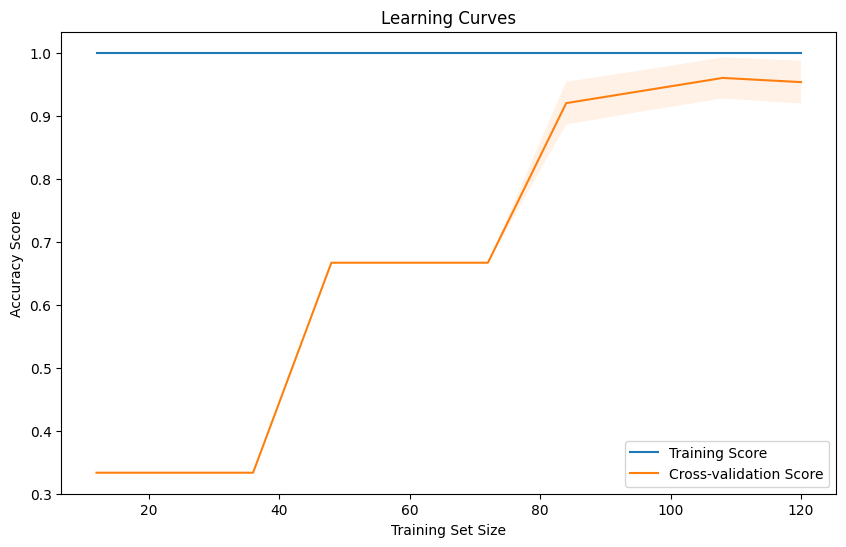

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

dt = DecisionTreeClassifier(random_state=42)
X, y = load_iris(return_X_y=True)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    dt, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curves')
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

#### SPIEGAZIONE CODICE SOPRA

Questo codice genera una **learning curve** (curva di apprendimento) per un modello di **Decision Tree** (albero decisionale) utilizzando il dataset **Iris**. La curva di apprendimento è utile per visualizzare come il modello migliora con l'aumento della dimensione del set di addestramento. Viene anche mostrata la variazione dell'accuratezza durante la validazione incrociata.

### Spiegazione del codice riga per riga

#### 1. **Importazioni e creazione del modello**

```python
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
```
- **`learning_curve`**: Importa la funzione per calcolare le learning curve.
- **`DecisionTreeClassifier`**: Importa il modello di albero decisionale dalla libreria `sklearn.tree`.
- **`load_iris`**: Importa il dataset **Iris**, che è un dataset di esempio di classificazione.

#### 2. **Inizializzazione del modello e caricamento del dataset**

```python
dt = DecisionTreeClassifier(random_state=42)
X, y = load_iris(return_X_y=True)
```
- **`dt = DecisionTreeClassifier(random_state=42)`**: Crea una **istanza del modello DecisionTreeClassifier**. Il parametro `random_state=42` serve a rendere il modello riproducibile, ovvero ottenere gli stessi risultati ogni volta che il codice viene eseguito.
- **`X, y = load_iris(return_X_y=True)`**: Carica il dataset Iris e separa le caratteristiche (**`X`**) e le etichette (**`y`**). Il parametro `return_X_y=True` restituisce **due variabili**, una per le caratteristiche e l'altra per le etichette, rendendo il codice più compatto.

#### 3. **Calcolo della learning curve**

```python
train_sizes, train_scores, test_scores = learning_curve(
    dt, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)
```
- **`learning_curve(...)`**: Questa funzione calcola le learning curves del modello **`dt`**.
  - **`dt`**: Il modello che stiamo utilizzando (DecisionTreeClassifier).
  - **`X` e `y`**: Le caratteristiche e le etichette del dataset Iris.
  - **`cv=5`**: Il numero di fold da utilizzare per la **cross-validation** (in questo caso 5-fold).
  - **`train_sizes=np.linspace(0.1, 1.0, 10)`**: Questa riga specifica che la learning curve deve essere calcolata per 10 diverse dimensioni del training set, che vanno dal 10% al 100% del dataset. La funzione **`np.linspace(0.1, 1.0, 10)`** crea una lista di 10 valori equidistanti tra 0.1 (10%) e 1.0 (100%).

La funzione **`learning_curve`** restituisce tre variabili:
- **`train_sizes`**: Le dimensioni del set di addestramento su cui è stata calcolata la learning curve.
- **`train_scores`**: I punteggi di accuratezza sui dati di addestramento per ogni dimensione del set di addestramento.
- **`test_scores`**: I punteggi di accuratezza sui dati di test (cross-validation) per ogni dimensione del set di addestramento.

#### 4. **Calcolo delle medie e deviazioni standard**

```python
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
```
- **`train_mean`**: Calcola la **media** dei punteggi di accuratezza sui dati di addestramento per ciascuna dimensione del set di addestramento.
- **`train_std`**: Calcola la **deviazione standard** dei punteggi di accuratezza sui dati di addestramento. La deviazione standard misura quanto variano i punteggi da una dimensione all'altra del set di addestramento.
- **`test_mean`**: Calcola la **media** dei punteggi di accuratezza sui dati di test (cross-validation) per ciascuna dimensione del set di addestramento.
- **`test_std`**: Calcola la **deviazione standard** dei punteggi di accuratezza sui dati di test (cross-validation).

#### 5. **Creazione del grafico della learning curve**

```python
plt.figure(figsize=(10, 6))
plt.title('Learning Curves')
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-validation Score')
```
- **`plt.figure(figsize=(10, 6))`**: Imposta la **dimensione della figura** a 10 pollici di larghezza e 6 di altezza.
- **`plt.title('Learning Curves')`**: Imposta il **titolo** del grafico come "Learning Curves".
- **`plt.plot(train_sizes, train_mean, label='Training Score')`**: Traccia la curva dell'accuratezza sui dati di addestramento (media) rispetto alle dimensioni del training set. La **`label`** "Training Score" viene utilizzata per identificare questa curva nella legenda.
- **`plt.plot(train_sizes, test_mean, label='Cross-validation Score')`**: Traccia la curva dell'accuratezza sui dati di test (media) rispetto alle dimensioni del training set. La **`label`** "Cross-validation Score" viene utilizzata per identificare questa curva nella legenda.

#### 6. **Aggiunta delle barre di errore**

```python
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
```
- **`plt.fill_between(...)`**: Questa funzione viene utilizzata per **riempire l'area** tra la media dei punteggi e la deviazione standard, creando un'area di incertezza attorno alle curve.
  - La **prima** riga riempie l'area tra la **media** e la **deviazione standard** dei punteggi di addestramento, con una trasparenza del 10% (`alpha=0.1`).
  - La **seconda** riga riempie l'area tra la **media** e la **deviazione standard** dei punteggi di test, con la stessa trasparenza.

Questo rende visibile la **variabilità** dei punteggi, indicando quanto sono stabili i risultati a diverse dimensioni del training set.

#### 7. **Impostazione delle etichette e visualizzazione**

```python
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()
```
- **`plt.xlabel('Training Set Size')`**: Aggiunge l'etichetta all'asse **x** (orizzontale), che rappresenta la dimensione del set di addestramento.
- **`plt.ylabel('Accuracy Score')`**: Aggiunge l'etichetta all'asse **y** (verticale), che rappresenta l'accuratezza (punteggio) del modello.
- **`plt.legend()`**: Mostra la **legenda** del grafico, che aiuta a identificare le due curve (Training Score e Cross-validation Score).
- **`plt.show()`**: Mostra il grafico a schermo.

### Cosa fa il codice?
1. Il codice carica il dataset Iris e crea un modello di albero decisionale.
2. Calcola la **learning curve** del modello, variando la dimensione del training set e utilizzando la **cross-validation**.
3. Calcola le medie e le deviazioni standard dei punteggi di accuratezza su training e test (cross-validation).
4. Crea un grafico con le curve di apprendimento, mostrando sia i punteggi sui dati di addestramento che sui dati di test, con le aree di incertezza.
5. Il grafico risultante mostra come l'accuratezza del modello cambia al variare della dimensione del training set, aiutando a comprendere se il modello sta overfittando o underfittando.

### In sintesi:
Questo codice è utilizzato per visualizzare il comportamento di un modello (in questo caso, un albero decisionale) con l'aumentare dei dati di addestramento, in modo da capire meglio come il modello apprende e come si comporta sui dati di test. Le learning curves sono uno strumento utile per diagnosticare problemi di **underfitting** o **overfitting**.

## 4. Strategie di selezione del modello

### 4.1 Validazione incrociata della ricerca in griglia

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Load dataset
X, y = load_iris(return_X_y=True)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1
)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation Score: 0.9800000000000001


Il codice che hai fornito utilizza **GridSearchCV** per eseguire una **ricerca su griglia** dei migliori iperparametri per un modello di **Support Vector Classifier** (SVC). La ricerca su griglia è una tecnica che esplora un'ampia gamma di combinazioni di iperparametri per trovare quella che ottimizza la performance di un modello.

### Spiegazione riga per riga:

#### 1. **Importazioni**
```python
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
```
- **`GridSearchCV`**: Questa funzione viene importata dalla libreria `sklearn.model_selection` e viene utilizzata per eseguire una ricerca su griglia, ovvero una ricerca esaustiva su un insieme di possibili combinazioni di iperparametri.
- **`SVC`**: Importa la classe **Support Vector Classifier** (SVC), che è il modello che stai ottimizzando in questo caso. SVC è utilizzato per problemi di classificazione e utilizza i Support Vector Machines (SVM).

#### 2. **Caricamento del dataset**
```python
X, y = load_iris(return_X_y=True)
```
- **`load_iris(return_X_y=True)`**: Carica il famoso dataset Iris di classificazione. **`X`** contiene le caratteristiche (features) e **`y`** contiene le etichette (target).
- L'argomento **`return_X_y=True`** restituisce due variabili direttamente: **`X`** (caratteristiche) e **`y`** (etichette).

#### 3. **Definizione della griglia dei parametri**
```python
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
```
- **`param_grid`**: Qui definisci la griglia dei parametri che desideri esplorare durante la ricerca su griglia. In particolare, stai cercando di ottimizzare i seguenti iperparametri:
  - **`C`**: Questo parametro controlla il margine di errore nel modello SVM. Un valore più alto di `C` comporta un modello più rigido (meno tollerante agli errori), mentre un valore basso rende il modello più tollerante agli errori. I valori esplorati sono `[0.1, 1, 10]`.
  - **`kernel`**: Il tipo di kernel da usare. I due valori che stai esplorando sono `'linear'` (kernel lineare) e `'rbf'` (kernel radiale, che è una funzione di base radiale).
  - **`gamma`**: Questo parametro controlla l'influenza di un singolo punto di dati. I valori `'scale'` e `'auto'` sono le opzioni esplorate:
    - **`'scale'`**: Usa 1 / (n_features * X.var()) come valore di gamma.
    - **`'auto'`**: Imposta gamma a 1 / n_features.

#### 4. **Esecuzione della ricerca su griglia**
```python
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1
)
```
- **`GridSearchCV`**: Crea un'istanza di ricerca su griglia per trovare la migliore combinazione di parametri.
  - **`SVC()`**: Il modello che stai ottimizzando. Viene creato un nuovo classificatore **Support Vector Machine** (SVC) senza specificare parametri, in modo che la ricerca su griglia esplori tutte le combinazioni di iperparametri definiti nel `param_grid`.
  - **`param_grid`**: La griglia dei parametri da esplorare.
  - **`cv=5`**: Utilizza la **cross-validation a 5 fold**. Questo significa che il dataset sarà diviso in 5 sottoinsiemi (fold), e per ogni combinazione di parametri, il modello verrà addestrato su 4 fold e testato sul fold rimanente. Questo processo sarà ripetuto 5 volte (per ciascun fold) e i risultati saranno mediati.
  - **`scoring='accuracy'`**: La metrica di valutazione per la performance del modello. In questo caso, la metrica è **accuratezza**.
  - **`n_jobs=-1`**: Esegue la ricerca su griglia utilizzando **tutti i core del processore disponibili**. `-1` significa che verranno utilizzati tutti i core per parallelizzare il processo di ricerca.

#### 5. **Addestramento della ricerca su griglia**
```python
grid_search.fit(X, y)
```
- **`grid_search.fit(X, y)`**: Avvia l'addestramento della ricerca su griglia. Questo processo:
  - Esplora tutte le combinazioni di parametri nel `param_grid`.
  - Per ogni combinazione, esegue la cross-validation a 5 fold (definita prima con `cv=5`).
  - Calcola e memorizza il punteggio di accuratezza per ciascuna combinazione di parametri.

#### 6. **Stampa dei migliori parametri e del miglior punteggio**
```python
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)
```
- **`grid_search.best_params_`**: Restituisce la **combinazione di parametri** che ha prodotto il miglior punteggio di validazione incrociata. Questi sono i parametri che il modello dovrebbe utilizzare per ottenere le migliori prestazioni.
- **`grid_search.best_score_`**: Restituisce il miglior punteggio di **accuratezza** ottenuto durante la ricerca su griglia, basato sulla **cross-validation**.

### Cosa fa questo codice?

1. **Carica il dataset Iris** e lo prepara per la classificazione.
2. **Definisce una griglia di iperparametri** (C, kernel, gamma) per l'algoritmo **Support Vector Classifier (SVC)**.
3. **Esegue la ricerca su griglia** (`GridSearchCV`) per trovare la combinazione migliore di parametri che ottimizza l'accuratezza del modello SVC, utilizzando **5-fold cross-validation**.
4. Dopo aver eseguito la ricerca, il codice **stampa i migliori parametri** trovati e il **miglior punteggio di validazione incrociata**.

### A cosa serve?

Questo codice serve per **ottimizzare** i parametri di un modello di classificazione SVM. L'idea è trovare la combinazione di iperparametri che fornisce il miglior risultato in termini di accuratezza durante la validazione incrociata. La ricerca su griglia è uno strumento potente per migliorare le prestazioni dei modelli, soprattutto quando non si conoscono a priori i valori migliori per gli iperparametri.

### 4.2 Definizione di una serie di modelli da confrontare

Definiremo una raccolta di modelli di regressione con i loro parametri predefiniti. In seguito, li confronteremo e utilizzeremo anche versioni ottimizzate.

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [13]:
# Define a dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

print(f"Number of models to compare: {len(models)}")

Number of models to compare: 9


### 4.3 Creazione di una funzione di valutazione del modello

Definiamo una funzione che valuterà ogni modello utilizzando la convalida incrociata e più metriche.

In [14]:
def evaluate_model(model, X, y, cv=5):
    """
    Evaluate a regression model using cross-validation and multiple metrics.
    
    Parameters:
    -----------
    model : estimator object
        The model to evaluate
    X : DataFrame
        Feature matrix
    y : Series
        Target vector
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict : Dictionary of evaluation results
    """
    # Create a KFold object for consistent splitting across metrics
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculate different metrics using cross-validation
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    ev_scores = cross_val_score(model, X, y, cv=kf, scoring='explained_variance')
    
    # Convert negative MSE and MAE to positive for easier interpretation
    mse_scores = -neg_mse_scores
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -mae_scores
    
    # Gather results
    results = {
        'RMSE': {
            'mean': rmse_scores.mean(),
            'std': rmse_scores.std(),
            'values': rmse_scores
        },
        'MAE': {
            'mean': mae_scores.mean(),
            'std': mae_scores.std(),
            'values': mae_scores
        },
        'R²': {
            'mean': r2_scores.mean(),
            'std': r2_scores.std(),
            'values': r2_scores
        },
        'Explained Variance': {
            'mean': ev_scores.mean(),
            'std': ev_scores.std(),
            'values': ev_scores
        }
    }
    
    return results

#### SPIEGAZIONE CODICE SOPRA

Questo codice definisce una funzione chiamata `evaluate_model`, che esegue una valutazione di un modello di regressione tramite la **cross-validation**. La funzione restituisce diverse **metriche di performance** del modello (ad esempio, RMSE, MAE, R², e Explained Variance). Ora, vediamo cosa fa il codice **riga per riga**:

### Codice:
```python
def evaluate_model(model, X, y, cv=5):
    """
    Evaluate a regression model using cross-validation and multiple metrics.
    
    Parameters:
    -----------
    model : estimator object
        The model to evaluate
    X : DataFrame
        Feature matrix
    y : Series
        Target vector
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict : Dictionary of evaluation results
    """
```
- **Definizione della funzione**: La funzione `evaluate_model` accetta quattro argomenti:
  - `model`: Il modello da valutare (ad esempio, regressore).
  - `X`: La matrice delle caratteristiche (features) del dataset.
  - `y`: Il vettore di target (valori da predire).
  - `cv`: Numero di fold per la cross-validation (di default è 5).

  Il docstring (parte tra le virgolette triple) spiega brevemente cosa fa la funzione, quali sono i parametri e cosa restituisce.

### Codice:
```python
    # Create a KFold object for consistent splitting across metrics
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
```
- **KFold**: Qui viene creato un oggetto `KFold`, che è usato per suddividere i dati in `cv` (5 di default) fold. I dati vengono suddivisi in modo casuale (`shuffle=True`) e il seme del generatore casuale è fissato (`random_state=42`) per garantire che la divisione dei dati sia sempre la stessa durante più esecuzioni.
- `cv=5`: Indica che i dati saranno divisi in 5 sottoinsiemi per la cross-validation.

### Codice:
```python
    # Calculate different metrics using cross-validation
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    ev_scores = cross_val_score(model, X, y, cv=kf, scoring='explained_variance')
```
- Qui vengono calcolate **quattro metriche** di valutazione del modello utilizzando la **cross-validation**.
  - `cross_val_score`: Esegue la cross-validation del modello e restituisce un array di punteggi per ciascun fold.
  - **Metriche utilizzate**:
    - **`neg_mean_squared_error`**: Errore quadratico medio (MSE), ma è negativo poiché la funzione `cross_val_score` restituisce punteggi positivi, quindi il MSE deve essere invertito per ottenere valori positivi.
    - **`r2`**: Coefficiente di determinazione \( R^2 \), che misura la qualità del modello (quanto bene i dati sono adattati).
    - **`neg_mean_absolute_error`**: Errore assoluto medio (MAE), anch'esso negativo, quindi successivamente invertito.
    - **`explained_variance`**: Variazione spiegata dal modello, che indica la frazione di varianza nei dati che il modello è in grado di spiegare.

### Codice:
```python
    # Convert negative MSE and MAE to positive for easier interpretation
    mse_scores = -neg_mse_scores
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -mae_scores
```
- Poiché **MSE** e **MAE** vengono restituiti come valori negativi (a causa della natura della funzione `cross_val_score`), vengono **invertiti** per ottenere valori positivi.
- Inoltre, il **RMSE** (Root Mean Squared Error) viene calcolato come la radice quadrata del MSE per riportarlo nella stessa scala dei dati.

### Codice:
```python
    # Gather results
    results = {
        'RMSE': {
            'mean': rmse_scores.mean(),
            'std': rmse_scores.std(),
            'values': rmse_scores
        },
        'MAE': {
            'mean': mae_scores.mean(),
            'std': mae_scores.std(),
            'values': mae_scores
        },
        'R²': {
            'mean': r2_scores.mean(),
            'std': r2_scores.std(),
            'values': r2_scores
        },
        'Explained Variance': {
            'mean': ev_scores.mean(),
            'std': ev_scores.std(),
            'values': ev_scores
        }
    }
```
- Qui si raccogliono i risultati delle diverse metriche in un **dizionario** chiamato `results`.
  - Per ogni metrica (RMSE, MAE, R², Explained Variance), vengono calcolate:
    - **media** (`mean`): La media dei punteggi per ogni fold.
    - **deviazione standard** (`std`): La deviazione standard dei punteggi, che misura quanto sono variabili i risultati attraverso i fold.
    - **valori** (`values`): I punteggi di ciascun fold, utili per vedere la distribuzione dei punteggi.

### Codice:
```python
    return results
```
- La funzione restituisce il dizionario `results`, che contiene le metriche calcolate con la **cross-validation**.
  - Il dizionario include per ciascuna metrica:
    - La media, la deviazione standard e i valori specifici di ciascun fold.

### Cosa fa la funzione nel complesso?
La funzione `evaluate_model` esegue la **valutazione di un modello di regressione** utilizzando la **cross-validation**. Per ogni modello, calcola le seguenti metriche:
- **RMSE (Root Mean Squared Error)**
- **MAE (Mean Absolute Error)**
- **R² (R-squared)**
- **Explained Variance**

Restituisce queste metriche sotto forma di un dizionario, che include la media, la deviazione standard e i punteggi specifici per ogni fold di cross-validation. Questo ti consente di ottenere una valutazione completa del modello da più angolazioni, tenendo conto della sua capacità di predire in modo preciso, consistente e con un buon adattamento ai dati.

### Uso della funzione
Puoi utilizzare questa funzione passando un modello, insieme ai tuoi dati di addestramento (X, y), e otterrai una valutazione completa delle prestazioni del modello in base alle metriche sopra descritte.

Esempio di utilizzo:
```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
results = evaluate_model(model, X_train, y_train)

# Stampa i risultati
print(results)
```

### 4.4 Valutazione di tutti i modelli con convalida incrociata

Ora, valutiamo tutti i nostri modelli utilizzando la funzione che abbiamo definito.

In [17]:
# Create a dictionary to store results for all models
all_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Create a pipeline that scales the data first (important for some models like SVR and KNN)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Evaluate the model pipeline
    all_results[name] = evaluate_model(pipeline, X_train, y_train, cv=5)
    
print("\nEvaluation complete!")

Evaluating Linear Regression...


NameError: name 'X_train' is not defined

#### SPIEGAZIONE CODICE SOPRA

Ecco una spiegazione **riga per riga** di ciò che fa il codice che hai fornito:

### Codice:
```python
# Create a dictionary to store results for all models
all_results = {}
```
- **Descrizione**: Qui viene creato un **dizionario vuoto** chiamato `all_results` che verrà utilizzato per memorizzare i risultati di valutazione per ogni modello. Il dizionario avrà come chiavi i nomi dei modelli (ad esempio, "Regressione Lineare", "SVR", ecc.) e come valori i risultati della valutazione per ciascun modello (ottenuti dalla funzione `evaluate_model`).

### Codice:
```python
# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
```
- **Descrizione**: Qui inizia un **ciclo for** che itera su tutti i modelli nella variabile `models`. 
  - `models` è un dizionario che contiene diversi modelli di machine learning (ad esempio, Regressore lineare, Support Vector Regressor, KNN, ecc.).
  - **`name`** è la chiave del dizionario (ad esempio, il nome del modello come stringa, "Linear Regression").
  - **`model`** è l'oggetto del modello (ad esempio, un'istanza di `LinearRegression()`, `SVR()`, ecc.).
  - Il ciclo stampa il nome del modello corrente che viene valutato.

### Codice:
```python
    # Create a pipeline that scales the data first (important for some models like SVR and KNN)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
```
- **Descrizione**: Qui viene creato un **pipeline** per ogni modello.
  - Un **pipeline** è una sequenza di operazioni che vengono eseguite sui dati prima che vengano passati al modello. In questo caso, il pipeline è composto da due fasi:
    1. **`StandardScaler`**: Questa fase esegue la **normalizzazione dei dati** (scaling). La normalizzazione è importante per alcuni modelli, come **Support Vector Regressor (SVR)** e **K-Nearest Neighbors (KNN)**, che sono sensibili alle scale delle variabili.
    2. **`model`**: Questa è la fase in cui viene applicato il modello di regressione che stai valutando (ad esempio, `LinearRegression`, `SVR`, ecc.).

  Quindi, la pipeline prima **scalerà** i dati e poi applicherà il modello di regressione. Questo è utile per garantire che i dati siano trattati correttamente prima di essere utilizzati dal modello.

### Codice:
```python
    # Evaluate the model pipeline
    all_results[name] = evaluate_model(pipeline, X_train, y_train, cv=5)
```
- **Descrizione**: Qui viene **valutato il modello** usando la funzione `evaluate_model` che abbiamo visto prima. 
  - `pipeline` è il pipeline che contiene il modello e il `StandardScaler`.
  - **`X_train`** è la matrice delle caratteristiche di addestramento.
  - **`y_train`** è il vettore dei target di addestramento.
  - `cv=5` indica che vogliamo eseguire una **cross-validation con 5 fold**.
  
  Il risultato della valutazione viene **salvato nel dizionario `all_results`** con la chiave corrispondente al nome del modello. Il risultato conterrà diverse metriche di performance (come RMSE, MAE, R², Explained Variance) per quel modello.

### Codice:
```python
print("\nEvaluation complete!")
```
- **Descrizione**: Una volta completata l'iterazione su tutti i modelli, viene stampato il messaggio `"Evaluation complete!"` per indicare che la valutazione di tutti i modelli è stata completata.

---

### Cosa fa complessivamente questo codice?

1. **Crea un dizionario vuoto** chiamato `all_results`, che conterrà i risultati di valutazione per ciascun modello.
2. **Itera su tutti i modelli** definiti nel dizionario `models`.
3. Per ogni modello:
   - Crea un **pipeline** che include il **scalatore** (StandardScaler) e il **modello**.
   - Esegue la valutazione del modello usando **cross-validation** con 5 fold, e raccoglie i risultati di diverse metriche (come RMSE, MAE, R², Explained Variance).
   - Salva i risultati nel dizionario `all_results`.
4. Una volta completata la valutazione di tutti i modelli, stampa `"Evaluation complete!"`.

### Come usare il codice?
Questo codice è utile quando vuoi confrontare più modelli di regressione per determinare quale funziona meglio. La pipeline si occupa di normalizzare i dati per modelli che ne hanno bisogno (ad esempio SVR, KNN), e la funzione `evaluate_model` raccoglie tutte le metriche di valutazione in modo sistematico. Alla fine, ottieni un dizionario (`all_results`) contenente i risultati di ciascun modello, che puoi poi esaminare per decidere quale modello ha la migliore performance.

Esempio di output che potresti ottenere nel dizionario `all_results`:
```python
{
    'Linear Regression': {
        'RMSE': {'mean': 2.5, 'std': 0.5, 'values': [2.6, 2.4, 2.7, 2.5, 2.4]},
        'MAE': {'mean': 1.2, 'std': 0.2, 'values': [1.3, 1.1, 1.2, 1.2, 1.1]},
        'R²': {'mean': 0.85, 'std': 0.04, 'values': [0.86, 0.84, 0.85, 0.87, 0.83]},
        'Explained Variance': {'mean': 0.89, 'std': 0.03, 'values': [0.88, 0.90, 0.89, 0.87, 0.90]}
    },
    'SVR': {
        'RMSE': {'mean': 2.8, 'std': 0.6, 'values': [2.9, 2.7, 2.8, 3.0, 2.6]},
        'MAE': {'mean': 1.3, 'std': 0.3, 'values': [1.4, 1.2, 1.3, 1.4, 1.2]},
        'R²': {'mean': 0.80, 'std': 0.05, 'values': [0.82, 0.79, 0.78, 0.81, 0.80]},
        'Explained Variance': {'mean': 0.83, 'std': 0.04, 'values': [0.84, 0.81, 0.82, 0.85, 0.83]}
    }
    # ... altrimenti altri modelli
}
``` 

In questo esempio, per ogni modello (`Linear Regression`, `SVR`, etc.), vengono restituite le metriche di valutazione calcolate sulla base dei 5 fold di cross-validation.

### 4.5 Confronto di modelli tramite più metriche

Creiamo visualizzazioni per confrontare le prestazioni di tutti i modelli tramite diverse metriche.

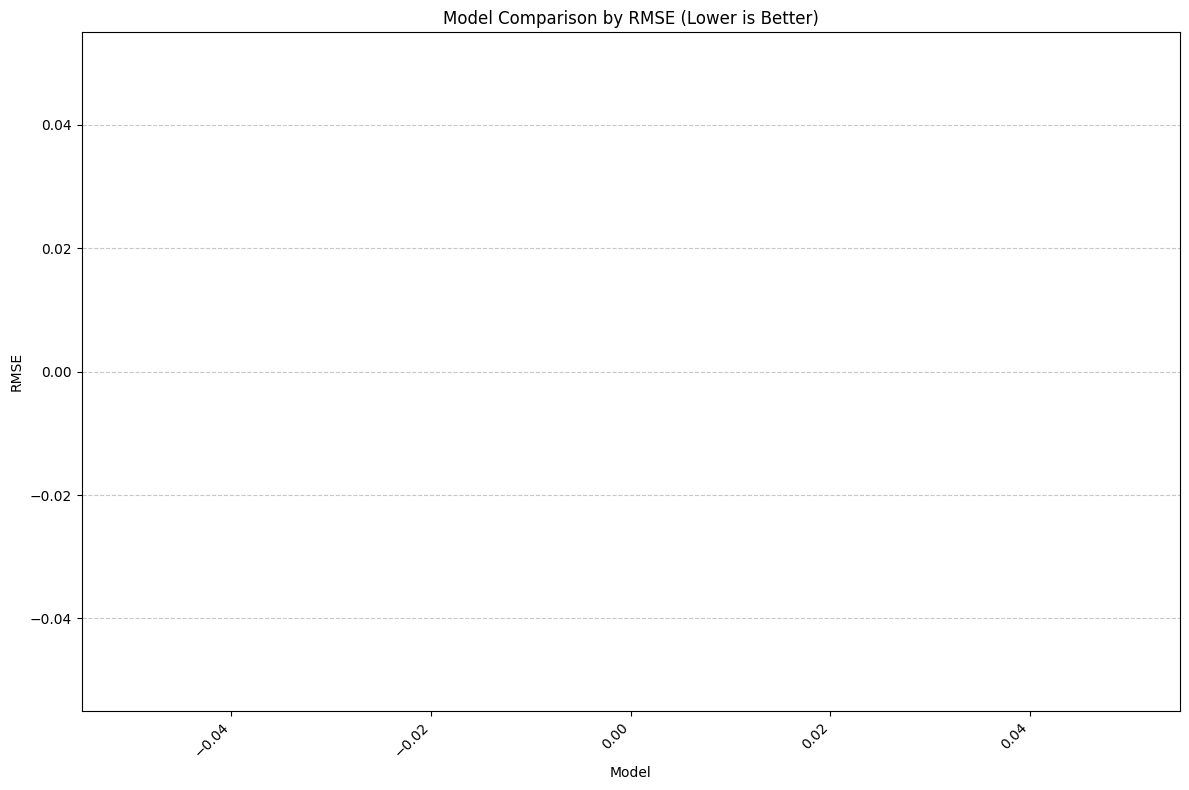

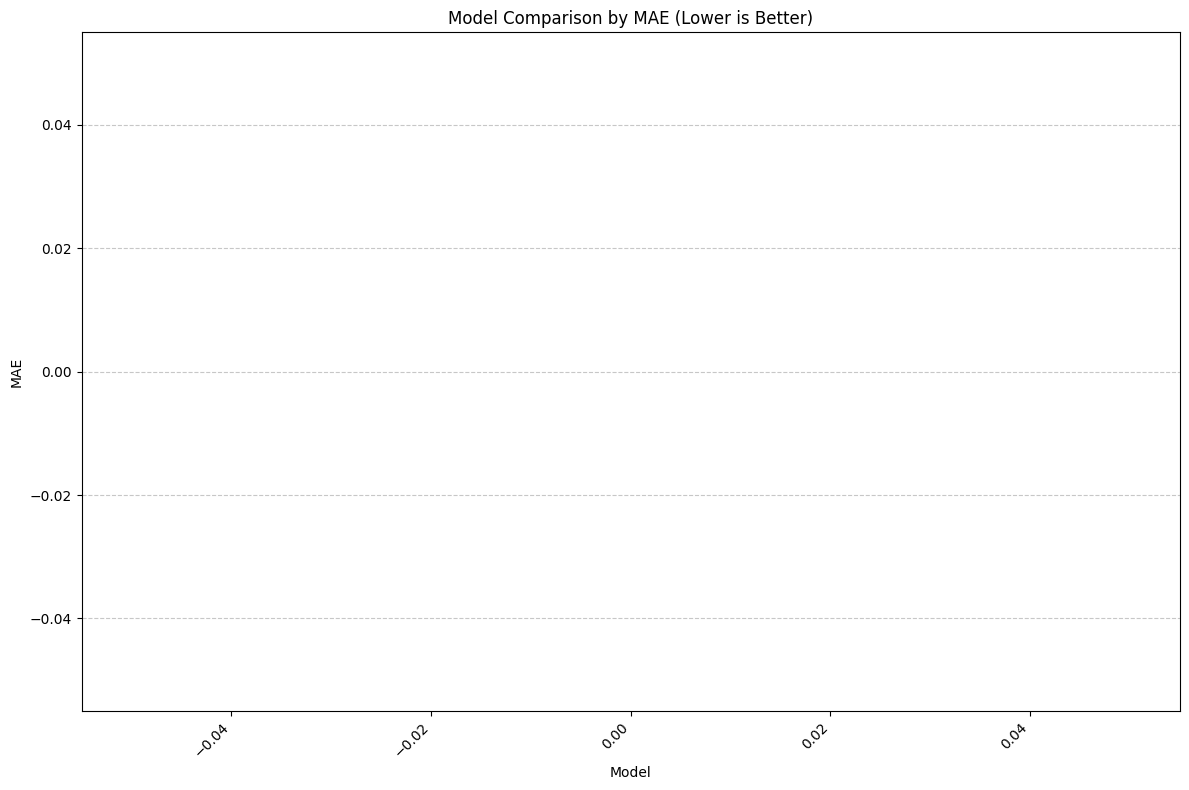

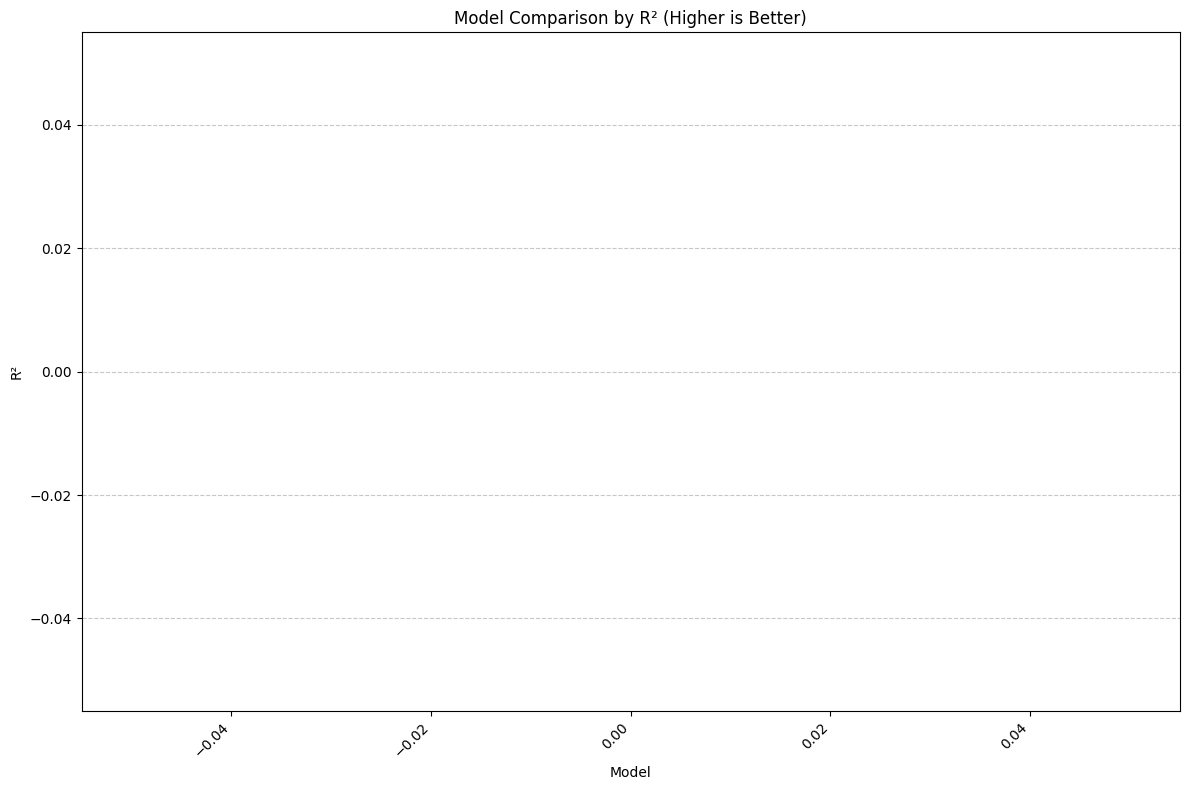

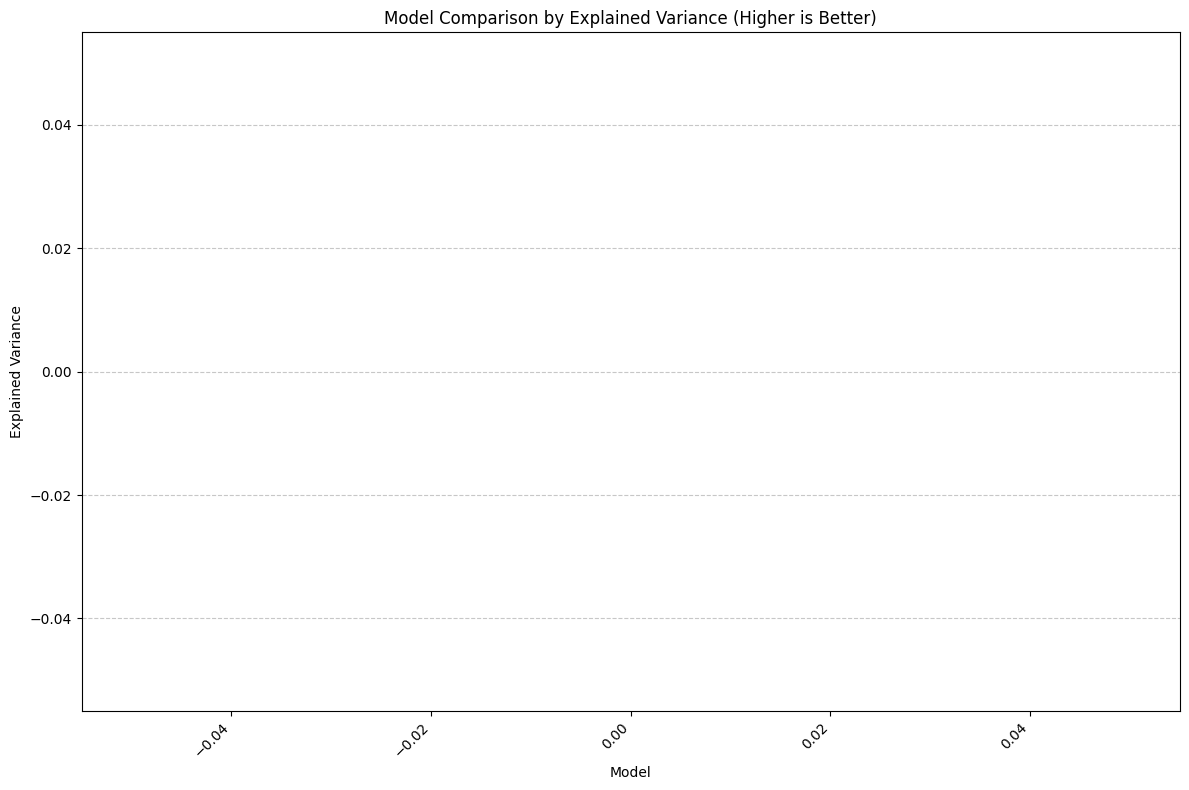

,Model,RMSE (mean),RMSE (std),MAE (mean),MAE (std),R² (mean),R² (std),Explained Variance (mean),Explained Variance (std)


In [18]:
def plot_model_comparison(results, metric):
    """
    Create a bar plot comparing models on a specific metric.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    metric : str
        The metric to plot ('RMSE', 'MAE', 'R²', or 'Explained Variance')
    """
    # Extract mean values and standard deviations for the metric
    means = [results[model][metric]['mean'] for model in results]
    stds = [results[model][metric]['std'] for model in results]
    model_names = list(results.keys())
    
    # Sort by performance (lower is better for RMSE and MAE, higher is better for R² and Explained Variance)
    if metric in ['RMSE', 'MAE']:
        sorted_indices = np.argsort(means)
        title_text = f"Model Comparison by {metric} (Lower is Better)"
    else:
        sorted_indices = np.argsort(means)[::-1]  # Reverse for higher is better
        title_text = f"Model Comparison by {metric} (Higher is Better)"
    
    sorted_means = [means[i] for i in sorted_indices]
    sorted_stds = [stds[i] for i in sorted_indices]
    sorted_names = [model_names[i] for i in sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(sorted_names, sorted_means, yerr=sorted_stds, capsize=10,
                  color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(title_text)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar, value in zip(bars, sorted_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * max(sorted_means),
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a comparison table
def create_comparison_table(results):
    """
    Create a pandas DataFrame summarizing model performance across all metrics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
        
    Returns:
    --------
    DataFrame : Summary table of model performance
    """
    # Initialize lists to store data
    models = []
    rmse_means = []
    rmse_stds = []
    mae_means = []
    mae_stds = []
    r2_means = []
    r2_stds = []
    ev_means = []
    ev_stds = []
    
    # Extract data
    for model_name, model_results in results.items():
        models.append(model_name)
        rmse_means.append(model_results['RMSE']['mean'])
        rmse_stds.append(model_results['RMSE']['std'])
        mae_means.append(model_results['MAE']['mean'])
        mae_stds.append(model_results['MAE']['std'])
        r2_means.append(model_results['R²']['mean'])
        r2_stds.append(model_results['R²']['std'])
        ev_means.append(model_results['Explained Variance']['mean'])
        ev_stds.append(model_results['Explained Variance']['std'])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Model': models,
        'RMSE (mean)': rmse_means,
        'RMSE (std)': rmse_stds,
        'MAE (mean)': mae_means,
        'MAE (std)': mae_stds,
        'R² (mean)': r2_means,
        'R² (std)': r2_stds,
        'Explained Variance (mean)': ev_means,
        'Explained Variance (std)': ev_stds
    })
    
    # Format the DataFrame for better readability
    for col in df.columns:
        if '(mean)' in col or '(std)' in col:
            df[col] = df[col].round(4)
    
    return df

# Plot comparisons for each metric
for metric in ['RMSE', 'MAE', 'R²', 'Explained Variance']:
    plot_model_comparison(all_results, metric)

# Create and display a comprehensive comparison table
comparison_table = create_comparison_table(all_results)
comparison_table.sort_values(by='RMSE (mean)')

#### SPIEGAZIONE DEL CODICE SOPRA

Questo codice serve per **valutare, confrontare e visualizzare** i risultati delle performance di più modelli di regressione in base a diversi **metriche di valutazione** (RMSE, MAE, R², Explained Variance). In particolare, il codice esegue le seguenti operazioni:

### 1. **Funzione `plot_model_comparison`**
Questa funzione crea un **grafico a barre** per confrontare diversi modelli sulla base di una metrica specifica (RMSE, MAE, R², o Explained Variance).

#### Parametri:
- **`results`**: è un dizionario che contiene i risultati di valutazione per tutti i modelli.
- **`metric`**: è la metrica (ad esempio, "RMSE", "MAE", "R²" o "Explained Variance") da utilizzare per il confronto.

#### Funzionamento:
1. **Estrazione delle medie e delle deviazioni standard** per la metrica specificata da tutti i modelli nel dizionario `results`.
2. **Ordinamento dei modelli** in base alla metrica specificata:
   - Per le metriche **RMSE** e **MAE**, l'ordinamento è fatto in modo crescente, poiché valori più bassi indicano performance migliori.
   - Per le metriche **R²** e **Explained Variance**, l'ordinamento è fatto in modo decrescente, poiché valori più alti indicano performance migliori.
3. **Creazione del grafico a barre** che mostra la performance dei modelli:
   - Le barre rappresentano la media della metrica.
   - Viene aggiunto l'errore standard (deviazione standard) come barre di errore.
4. **Aggiunta delle etichette** sopra le barre per visualizzare i valori delle metriche in modo leggibile.
5. **Visualizzazione del grafico** con titolo, etichette e griglia.

### 2. **Funzione `create_comparison_table`**
Questa funzione crea una tabella di sintesi che riassume le performance di tutti i modelli su tutte le metriche.

#### Parametri:
- **`results`**: è un dizionario che contiene i risultati di valutazione per tutti i modelli.

#### Funzionamento:
1. **Estrazione dei dati** da `results` per ogni modello, includendo le medie e le deviazioni standard di RMSE, MAE, R², e Explained Variance.
2. Creazione di un **DataFrame pandas** che contiene i risultati per ogni modello.
3. **Formattazione** dei valori nel DataFrame per una migliore leggibilità, arrotondando le medie e le deviazioni standard a 4 decimali.
4. Il DataFrame risultante viene restituito come **tabella comparativa** delle performance dei modelli.

### 3. **Esecuzione del Codice:**
1. **Plot delle comparazioni** per ciascuna delle metriche (`RMSE`, `MAE`, `R²`, `Explained Variance`):
   - Viene chiamata la funzione `plot_model_comparison` per ciascuna delle metriche, creando quindi 4 grafici distinti per ciascuna metrica.
2. **Creazione e visualizzazione della tabella comparativa**:
   - La funzione `create_comparison_table` viene utilizzata per creare una tabella riassuntiva con i risultati delle performance dei modelli, che viene poi ordinata in base al valore medio di **RMSE**.

### Risultato:
- **Grafici** che mostrano visivamente come i modelli si confrontano per ciascuna metrica di valutazione.
- Una **tabella** che riassume in modo dettagliato i risultati numerici per ciascun modello e per ciascuna metrica.


### 4.6 Classificazione dei modelli in base a più criteri

Creiamo una funzione per classificare i nostri modelli considerando più metriche contemporaneamente.

In [19]:
def rank_models(results, weights=None):
    """
    Rank models based on multiple metrics with optional weighting.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    weights : dict, optional
        Dictionary with metrics as keys and weights as values
        Default weights give equal importance to all metrics
        
    Returns:
    --------
    DataFrame : Ranked models with composite scores
    """
    # Define default weights if none provided
    if weights is None:
        weights = {'RMSE': 0.25, 'MAE': 0.25, 'R²': 0.25, 'Explained Variance': 0.25}
    
    # Check that weights sum to 1
    weight_sum = sum(weights.values())
    if abs(weight_sum - 1.0) > 1e-10:  # Allow for floating point imprecision
        raise ValueError(f"Weights must sum to 1, but they sum to {weight_sum}")
    
    # Extract model names and initialize score dictionaries
    model_names = list(results.keys())
    normalized_scores = {model: 0 for model in model_names}
    
    # For each metric, normalize scores and calculate weighted contribution
    for metric, weight in weights.items():
        # Extract metric values for all models
        metric_values = [results[model][metric]['mean'] for model in model_names]
        
        # Normalize scores (0-1 scale, 1 is best)
        if metric in ['RMSE', 'MAE']:  # Lower is better
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [1 - (val - min_val) / (max_val - min_val) for val in metric_values]
        else:  # Higher is better for R² and Explained Variance
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [(val - min_val) / (max_val - min_val) for val in metric_values]
        
        # Add weighted normalized score to each model's total
        for i, model in enumerate(model_names):
            normalized_scores[model] += weight * normalized[i]
    
    # Create a DataFrame with the results
    rank_df = pd.DataFrame({
        'Model': model_names,
        'Composite Score': [normalized_scores[model] for model in model_names]
    })
    
    # Sort by composite score in descending order
    rank_df = rank_df.sort_values('Composite Score', ascending=False).reset_index(drop=True)
    
    # Add rank column
    rank_df.index = rank_df.index + 1
    rank_df = rank_df.rename_axis('Rank').reset_index()
    
    # Round scores for display
    rank_df['Composite Score'] = rank_df['Composite Score'].round(4)
    
    return rank_df

# Let's rank our models with default weights (equal importance)
default_ranking = rank_models(all_results)
print("Model ranking with equal weighting of metrics:")
display(default_ranking)


ValueError: min() iterable argument is empty

#### SPIEGAZIONE DEL CODICE SOPRA

Questo codice definisce una funzione `rank_models` che permette di **valutare e classificare** i modelli in base a più metriche (RMSE, MAE, R², Explained Variance) con la possibilità di attribuire **pesi diversi** a ciascuna metrica. L'obiettivo di questa funzione è generare un **ranking** dei modelli basato sulle loro performance aggregate.

### Analisi del Codice Riga per Riga:

#### 1. **Definizione della funzione `rank_models`**
```python
def rank_models(results, weights=None):
```
- La funzione `rank_models` accetta due parametri:
  - **`results`**: un dizionario contenente i risultati di valutazione per ogni modello (composto da metriche come RMSE, MAE, R², e Explained Variance).
  - **`weights`**: un dizionario opzionale che permette di assegnare dei pesi personalizzati alle diverse metriche. Se non viene fornito, verranno usati pesi predefiniti (uguali per tutte le metriche).

#### 2. **Definizione dei pesi predefiniti**
```python
if weights is None:
    weights = {'RMSE': 0.25, 'MAE': 0.25, 'R²': 0.25, 'Explained Variance': 0.25}
```
- Se non vengono forniti pesi personalizzati (`weights is None`), vengono utilizzati i pesi predefiniti, assegnando uguale importanza (0.25) a ciascuna delle 4 metriche.

#### 3. **Verifica che i pesi sommino a 1**
```python
weight_sum = sum(weights.values())
if abs(weight_sum - 1.0) > 1e-10:
    raise ValueError(f"Weights must sum to 1, but they sum to {weight_sum}")
```
- Il codice verifica che la somma dei pesi sia uguale a 1. Se la somma non è 1 (comprese piccole imprecisioni numeriche), viene sollevata un'eccezione (`ValueError`).

#### 4. **Inizializzazione delle variabili per il punteggio dei modelli**
```python
model_names = list(results.keys())
normalized_scores = {model: 0 for model in model_names}
```
- **`model_names`**: crea una lista contenente i nomi di tutti i modelli da confrontare.
- **`normalized_scores`**: un dizionario che inizializza a zero i punteggi normalizzati di ogni modello.

#### 5. **Ciclo attraverso le metriche**
```python
for metric, weight in weights.items():
```
- Si itera su ogni metrica e peso nel dizionario `weights`.

#### 6. **Estrazione dei valori delle metriche per ciascun modello**
```python
metric_values = [results[model][metric]['mean'] for model in model_names]
```
- Per ciascun modello, vengono estratti i valori medi della metrica (`metric`) da `results`.

#### 7. **Normalizzazione dei punteggi**
- **Se la metrica è RMSE o MAE (minore è meglio)**:
```python
if metric in ['RMSE', 'MAE']:
    min_val = min(metric_values)
    max_val = max(metric_values)
    if max_val == min_val:
        normalized = [1.0 for _ in metric_values]
    else:
        normalized = [1 - (val - min_val) / (max_val - min_val) for val in metric_values]
```
- Per le metriche RMSE e MAE, il punteggio viene **normalizzato** su una scala da 0 a 1, dove 1 è il miglior punteggio (minore è meglio).
- La formula di normalizzazione è:  
  \[
  \text{normalized score} = 1 - \frac{\text{value} - \text{min}}{\text{max} - \text{min}}
  \]
- Se tutti i valori della metrica sono uguali (min = max), i punteggi sono impostati a 1.

- **Se la metrica è R² o Explained Variance (maggiore è meglio)**:
```python
else:  # Higher is better for R² and Explained Variance
    min_val = min(metric_values)
    max_val = max(metric_values)
    if max_val == min_val:
        normalized = [1.0 for _ in metric_values]
    else:
        normalized = [(val - min_val) / (max_val - min_val) for val in metric_values]
```
- Per le metriche R² e Explained Variance, il punteggio viene normalizzato su una scala da 0 a 1, dove 1 è il miglior punteggio (maggiore è meglio).
- La formula di normalizzazione è:  
  \[
  \text{normalized score} = \frac{\text{value} - \text{min}}{\text{max} - \text{min}}
  \]

#### 8. **Aggiornamento del punteggio normalizzato per ciascun modello**
```python
for i, model in enumerate(model_names):
    normalized_scores[model] += weight * normalized[i]
```
- Per ogni modello, il punteggio normalizzato viene aggiornato aggiungendo il **contributo ponderato** di ciascuna metrica.

#### 9. **Creazione di un DataFrame con i risultati**
```python
rank_df = pd.DataFrame({
    'Model': model_names,
    'Composite Score': [normalized_scores[model] for model in model_names]
})
```
- Un **DataFrame pandas** viene creato con i nomi dei modelli e i punteggi complessivi (sommatoria dei punteggi normalizzati ponderati).

#### 10. **Ordinamento del DataFrame**
```python
rank_df = rank_df.sort_values('Composite Score', ascending=False).reset_index(drop=True)
```
- Il DataFrame viene ordinato in base al **punteggio complessivo** in ordine decrescente (il modello con il punteggio più alto è il migliore).

#### 11. **Aggiunta di una colonna per il ranking**
```python
rank_df.index = rank_df.index + 1
rank_df = rank_df.rename_axis('Rank').reset_index()
```
- Viene aggiunto un **indice** per rappresentare la **posizione** (rank) di ciascun modello.

#### 12. **Arrotondamento dei punteggi per la visualizzazione**
```python
rank_df['Composite Score'] = rank_df['Composite Score'].round(4)
```
- I punteggi complessivi vengono arrotondati a 4 decimali per una visualizzazione più leggibile.

#### 13. **Restituzione del DataFrame**
```python
return rank_df
```
- La funzione restituisce il **DataFrame** con il ranking dei modelli.

#### 14. **Esecuzione del Ranking dei Modelli**
```python
default_ranking = rank_models(all_results)
print("Model ranking with equal weighting of metrics:")
display(default_ranking)
```
- La funzione `rank_models` viene chiamata con i risultati dei modelli (`all_results`), utilizzando i pesi predefiniti (uguale importanza per tutte le metriche). Viene poi visualizzato il **ranking** finale.

### Scopo del Codice:
Questo codice classifica i modelli in base alla loro **performance complessiva**, tenendo conto di più metriche e ponderando le metriche in base ai pesi definiti (se forniti). La **classifica finale** aiuta a determinare quale modello è il migliore in termini di combinazione delle metriche.

# Metriche di valutazione delle previsioni delle serie temporali

Capita molto raramente che nelle timeseries i data point siano indipendenti l'uno dall'altro. Le timeseries sono una compressione di datapoint in cui a priori potrei avere delle relazioni

## 1. Introduzione alla valutazione delle serie temporali <a name="introduction"></a>

La valutazione dei modelli di previsione delle serie temporali presenta sfide uniche rispetto alle normali attività di apprendimento automatico. I dati dipendenti dal tempo spesso presentano modelli stagionali, tendenze e vari gradi di stazionarietà. La scelta della metrica di valutazione ha un impatto significativo sulla selezione del modello e sulla messa a punto dei parametri.

Considerazioni chiave nella scelta delle metriche di valutazione per le serie temporali:

- **Sensibilità della scala**: la metrica è influenzata dalla scala dei dati?
- **Sensibilità dei valori anomali**: in che modo la metrica gestisce i valori estremi?
- **Valori zero/piccoli**: la metrica si interrompe con valori pari a zero o prossimi allo zero?
- **Interpretabilità**: con quale facilità le parti interessate possono comprendere la metrica?
- **Direzionalità**: la direzione della previsione è più importante della magnitudo?
- **Costi asimmetrici**: le previsioni eccessive e quelle insufficienti sono ugualmente problematiche?

Esploreremo le metriche che affrontano questi diversi aspetti della valutazione delle previsioni.


spiegazione più approfondita sulla **valutazione dei modelli di previsione delle serie temporali** e sulle **considerazioni chiave** nella scelta delle metriche.

### 1. Introduzione alla valutazione delle serie temporali

Nel contesto delle **serie temporali**, i modelli di previsione non sono valutati nello stesso modo di un modello di regressione tradizionale. Le **serie temporali** presentano caratteristiche uniche che richiedono una valutazione accurata, che vada oltre le classiche metriche usate nei modelli di machine learning. Alcuni aspetti cruciali che rendono le serie temporali speciali includono:

- **Tendenze**: un cambiamento nel tempo dei dati (ad esempio, un incremento o decremento costante dei valori).
- **Stagionalità**: i dati che seguono pattern periodici, come quelli annuali, mensili, o settimanali.
- **Stazionarietà**: la proprietà di una serie temporale dove le sue statistiche (media, varianza, ecc.) non cambiano nel tempo. Se i dati non sono stazionari, devono essere trasformati per poter essere utilizzati in alcuni modelli.

A causa di queste peculiarità, è importante scegliere metriche che possano **catturare queste caratteristiche** e fornire una valutazione efficace dei modelli di previsione.

### 2. Considerazioni chiave nella scelta delle metriche

La **scelta della metrica di valutazione** è fondamentale per la selezione del modello migliore e la messa a punto dei parametri. Ecco le **considerazioni chiave** che dovresti tener presente quando scegli una metrica per valutare i modelli di serie temporali:

#### a) **Sensibilità della scala**

- **Cos'è?** La sensibilità della scala si riferisce a quanto una metrica è influenzata dalla grandezza o scala dei dati. Alcune metriche, come il **Mean Absolute Error (MAE)** o il **Root Mean Squared Error (RMSE)**, sono sensibili alla scala dei dati. Ciò significa che se i dati sono grandi (ad esempio, un aumento del reddito in milioni), queste metriche daranno un errore maggiore rispetto a un set di dati con valori più piccoli.
  
- **Perché è importante?** Se hai dati che variano ampiamente o che hanno diverse scale, alcune metriche potrebbero risultare inappropriate. Ad esempio, se stai lavorando con serie temporali che hanno una grande variazione nel tempo, l’uso di una metrica come RMSE potrebbe dare risultati fuorvianti.

#### b) **Sensibilità dei valori anomali**

- **Cos'è?** Alcune metriche, come l'**RMSE** o l'**errore quadratico medio (MSE)**, sono molto sensibili ai valori anomali o **outlier**. Un singolo valore estremo può distorcere notevolmente il risultato della metrica.
  
- **Perché è importante?** Se la serie temporale contiene anomalie (valori che si discostano significativamente dalla tendenza normale dei dati), queste anomalie potrebbero non essere gestite correttamente se non consideri una metrica robusta. In questi casi, puoi usare metriche come **Mean Absolute Error (MAE)**, che sono meno sensibili ai valori estremi.

#### c) **Valori zero/piccoli**

- **Cos'è?** Alcune metriche potrebbero **fallire** o diventare **instabili** quando i dati contengono **valori vicini a zero** (o pari a zero). Ad esempio, se una serie temporale ha molti periodi di bassa attività (come vendite basse), potrebbe risultare problematico calcolare il **logaritmo degli errori**.
  
- **Perché è importante?** Se hai serie temporali con **zero o valori molto piccoli**, alcune metriche potrebbero non funzionare correttamente. Una metrica come **Mean Absolute Percentage Error (MAPE)** può diventare **molto grande** o **non definita** quando la previsione è vicina a zero. Per questi casi, è meglio considerare metriche che non dipendano dal valore assoluto, come **MAE** o **RMSE**.

#### d) **Interpretabilità**

- **Cos'è?** Le metriche devono essere comprensibili per le **parti interessate** (manager, analisti, esperti di dominio). Alcune metriche sono facili da interpretare (ad esempio, **RMSE** o **MAE**), mentre altre, come l'**errore quadratico medio relativo**, potrebbero essere difficili da comprendere senza una spiegazione dettagliata.

- **Perché è importante?** Se i risultati devono essere comunicati a persone che non sono esperte in machine learning, è fondamentale scegliere metriche facilmente comprensibili. L'**RMSE** e l'**MAE** sono metriche intuitive e spesso comunicate con successo alle parti interessate.

#### e) **Direzionalità**

- **Cos'è?** In alcune applicazioni, è più importante **catturare la direzione del cambiamento** piuttosto che la magnitudo esatta. Ad esempio, nelle previsioni di domanda di un prodotto, potrebbe essere più importante prevedere se la domanda aumenterà o diminuirà, piuttosto che prevedere esattamente il numero di unità vendute.
  
- **Perché è importante?** Se la direzionalità è un aspetto critico, le metriche che penalizzano gli errori di direzione (come **simulazioni di previsione direzionale**) possono essere utili. Alcune tecniche potrebbero **non penalizzare il modello** se esso fornisce una direzione corretta, anche se la magnitudo dell'errore è elevata.

#### f) **Costi asimmetrici**

- **Cos'è?** Alcuni errori possono essere **più costosi** di altri, e il costo dell'errore può variare a seconda che si tratti di una **previsione eccessiva (overforecast)** o una **previsione insufficiente (underforecast)**.
  
- **Perché è importante?** In alcune applicazioni, un errore di previsione eccessivo può essere più dannoso rispetto a un errore di previsione insufficiente, o viceversa. Ad esempio, nella **gestione dell'inventario**, un'overforecasting può portare a costi aggiuntivi di magazzino, mentre un'underforecasting potrebbe causare rotture di stock. **Metriche personalizzate**, che considerano i **costi asimmetrici**, possono essere utili per penalizzare determinati tipi di errore.

### 3. Metriche di valutazione comuni per le serie temporali

Alcune delle metriche più comuni usate per la valutazione dei modelli di previsione delle serie temporali includono:

- **Mean Absolute Error (MAE)**: misura la differenza media assoluta tra le previsioni e i valori reali. È facilmente interpretabile ed è meno sensibile agli outlier rispetto a **RMSE**.
  
- **Root Mean Squared Error (RMSE)**: misura la radice quadrata della media degli errori al quadrato. Penalizza maggiormente gli errori grandi, ed è utile quando vuoi dare più peso agli errori più gravi.
  
- **Mean Absolute Percentage Error (MAPE)**: misura l'errore in percentuale rispetto al valore reale. È utile per confrontare la performance tra diverse serie temporali con scale diverse.

- **Explained Variance Score**: misura quanto bene la varianza dei dati è spiegata dal modello. È utile per comprendere la qualità complessiva delle previsioni in relazione alla variabilità dei dati originali.

### In sintesi:
La **scelta della metrica** dipende dalle caratteristiche specifiche dei tuoi dati e dagli **obiettivi del modello**. Alcune metriche si concentrano sulla **precisione della previsione** (ad esempio, RMSE), mentre altre sulla **direzionalità** o **costi asimmetrici**. È cruciale scegliere una metrica che rifletta gli aspetti più rilevanti del problema che stai cercando di risolvere.

## 2. Impostazione e generazione di dati campione <a name="setup"></a>

Importiamo prima le librerie necessarie e generiamo alcuni dati campione con cui lavorare.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [35]:
# Generate synthetic time series data
def generate_sample_data(n=100, with_trend=True, with_seasonality=True, with_noise=True):

    # Create time index
    time_idx = pd.date_range(start='2023-01-01', periods=n, freq='D')
    
    # Base component
    base = 100
    
    # Trend component
    trend = np.linspace(0, 30, n) if with_trend else np.zeros(n)
    
    # Seasonal component (weekly pattern)
    seasonality = 15 * np.sin(2 * np.pi * np.arange(n) / 7) if with_seasonality else np.zeros(n)
    
    # Noise component
    noise = np.random.normal(0, 5, n) if with_noise else np.zeros(n)
    
    # Combine components
    actual = base + trend + seasonality + noise
    
    # Create different forecast versions with varying accuracy
    forecast1 = actual + np.random.normal(0, 10, n)  # Good forecast
    forecast2 = actual + np.random.normal(5, 15, n)  # Biased forecast
    forecast3 = base + trend + np.random.normal(0, 10, n)  # Missing seasonality
    forecast4 = actual * 1.2  # Scaled forecast (systematically higher)
    
    # Create a dataframe
    df = pd.DataFrame({
        'ds': time_idx,
        'actual': actual,
        'forecast_good': forecast1,
        'forecast_biased': forecast2,
        'forecast_no_seasonality': forecast3,
        'forecast_scaled': forecast4
    })
    
    # Add special cases for testing robustness
    df.loc[10:15, 'actual'] = 0  # Zero values
    df.loc[20, 'actual'] = 400  # Outlier
    
    return df

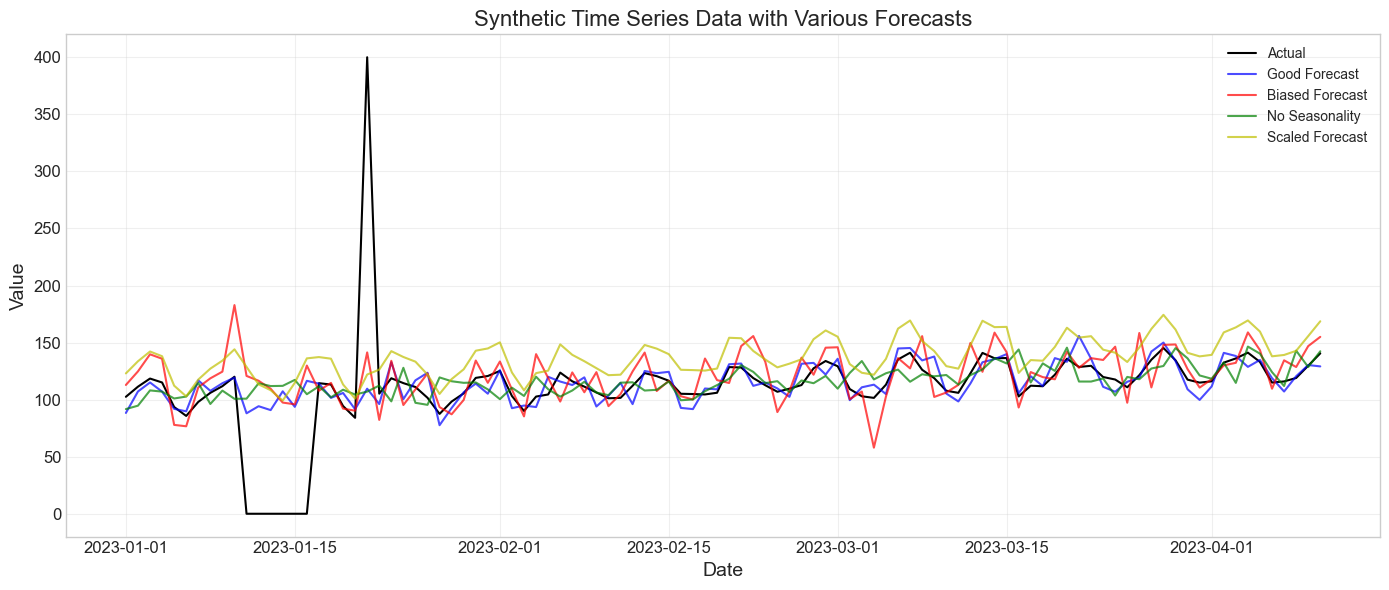

In [36]:
# Generate sample data and visualize
data = generate_sample_data(n=100)

plt.figure(figsize=(14, 6))
plt.plot(data['ds'], data['actual'], 'k-', label='Actual')
plt.plot(data['ds'], data['forecast_good'], 'b-', alpha=0.7, label='Good Forecast')
plt.plot(data['ds'], data['forecast_biased'], 'r-', alpha=0.7, label='Biased Forecast')
plt.plot(data['ds'], data['forecast_no_seasonality'], 'g-', alpha=0.7, label='No Seasonality')
plt.plot(data['ds'], data['forecast_scaled'], 'y-', alpha=0.7, label='Scaled Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data with Various Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### SPIEGAZIONE DEI CODICI SOPRA

Questo codice genera dei dati sintetici per una serie temporale, creando un set di previsioni con vari livelli di accuratezza, e visualizza questi dati. Esaminiamo il codice riga per riga per capire cosa fa.

### 1. **Importazione delle librerie**:
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
import warnings
warnings.filterwarnings('ignore')
```
- **`numpy`** e **`pandas`** sono usati per la manipolazione dei dati numerici e delle serie temporali.
- **`matplotlib.pyplot`** è utilizzato per la creazione di grafici.
- **`sklearn.metrics`** offre funzioni per calcolare errori come il MSE (Mean Squared Error) e il MAE (Mean Absolute Error).
- **`statsmodels.tsa.api`** è la libreria utilizzata per le analisi delle serie temporali, in particolare con modelli come **ARIMA** e **Exponential Smoothing**.
- **`warnings.filterwarnings('ignore')`** è usato per ignorare eventuali avvisi durante l'esecuzione del codice.

### 2. **Impostazione del seme casuale per la riproducibilità**:
```python
np.random.seed(42)
```
Questa riga garantisce che i risultati siano riproducibili. Usando un seme fisso, gli stessi numeri casuali verranno generati ogni volta che esegui il codice.

### 3. **Funzione per generare i dati sintetici**:
```python
def generate_sample_data(n=100, with_trend=True, with_seasonality=True, with_noise=True):
```
La funzione **`generate_sample_data`** crea una serie temporale sintetica, composta da più componenti:
- **`n=100`**: Numero di dati (periodi temporali) da generare.
- **`with_trend`**: Se impostato su **True**, aggiunge un componente di tendenza ai dati.
- **`with_seasonality`**: Se impostato su **True**, aggiunge un componente stagionale.
- **`with_noise`**: Se impostato su **True**, aggiunge rumore casuale ai dati.

### 4. **Creazione dell'indice temporale**:
```python
time_idx = pd.date_range(start='2023-01-01', periods=n, freq='D')
```
Questa riga crea un indice temporale con **n=100** giorni, a partire dal 1° gennaio 2023. **`freq='D'`** indica che i dati sono giornalieri.

### 5. **Componente di base e le componenti separate**:
```python
base = 100
trend = np.linspace(0, 30, n) if with_trend else np.zeros(n)
seasonality = 15 * np.sin(2 * np.pi * np.arange(n) / 7) if with_seasonality else np.zeros(n)
noise = np.random.normal(0, 5, n) if with_noise else np.zeros(n)
```
- **`base`** è un valore di partenza (100).
- **`trend`** è una componente lineare che cresce lentamente, aggiungendo una tendenza ai dati. Se **`with_trend`** è **False**, il trend è nullo.
- **`seasonality`** è una componente stagionale che segue un ciclo settimanale (ogni 7 giorni) utilizzando una funzione seno. Se **`with_seasonality`** è **False**, la stagionalità è nulla.
- **`noise`** è una componente di rumore casuale generata da una distribuzione normale. Se **`with_noise`** è **False**, il rumore è nullo.

### 6. **Combinazione delle componenti**:
```python
actual = base + trend + seasonality + noise
```
Questa riga somma tutte le componenti per ottenere la serie temporale **`actual`**, che rappresenta i dati effettivi.

### 7. **Generazione delle previsioni**:
```python
forecast1 = actual + np.random.normal(0, 10, n)  # Good forecast
forecast2 = actual + np.random.normal(5, 15, n)  # Biased forecast
forecast3 = base + trend + np.random.normal(0, 10, n)  # Missing seasonality
forecast4 = actual * 1.2  # Scaled forecast (systematically higher)
```
Vengono generate diverse versioni della previsione:
- **`forecast1`**: Buona previsione, con un errore casuale attorno ai dati effettivi (basso rumore).
- **`forecast2`**: Previsione con un bias, cioè un errore sistematico (più rumore e maggiore deviazione).
- **`forecast3`**: Previsione senza stagionalità, cioè solo base e trend, ma manca la stagionalità.
- **`forecast4`**: Previsione scalata, cioè una previsione sistematicamente più alta rispetto ai dati reali (moltiplicata per 1.2).

### 8. **Creazione del DataFrame**:
```python
df = pd.DataFrame({
    'ds': time_idx,
    'actual': actual,
    'forecast_good': forecast1,
    'forecast_biased': forecast2,
    'forecast_no_seasonality': forecast3,
    'forecast_scaled': forecast4
})
```
Questa riga crea un DataFrame **`df`** che contiene:
- **`ds`**: L'indice temporale (data).
- **`actual`**: I dati reali generati.
- **`forecast_good`**: La buona previsione.
- **`forecast_biased`**: La previsione con bias.
- **`forecast_no_seasonality`**: La previsione senza stagionalità.
- **`forecast_scaled`**: La previsione scalata.

### 9. **Aggiunta di casi speciali per testare la robustezza**:
```python
df.loc[10:15, 'actual'] = 0  # Zero values
df.loc[20, 'actual'] = 400  # Outlier
```
- Vengono aggiunti dei **valori zero** tra gli indici 10 e 15 (per testare come i modelli gestiscono i valori nulli).
- Viene inserito un **outlier** al valore 400 (indice 20), per vedere come i modelli reagiscono a valori anomali.

### 10. **Generazione del grafico**:
```python
plt.figure(figsize=(14, 6))
plt.plot(data['ds'], data['actual'], 'k-', label='Actual')
plt.plot(data['ds'], data['forecast_good'], 'b-', alpha=0.7, label='Good Forecast')
plt.plot(data['ds'], data['forecast_biased'], 'r-', alpha=0.7, label='Biased Forecast')
plt.plot(data['ds'], data['forecast_no_seasonality'], 'g-', alpha=0.7, label='No Seasonality')
plt.plot(data['ds'], data['forecast_scaled'], 'y-', alpha=0.7, label='Scaled Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data with Various Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
```
Infine, viene creato un grafico che visualizza:
- I **dati effettivi** (**`actual`**) in nero.
- Le diverse **previsioni** in vari colori:
  - Previsione buona (**`forecast_good`**) in blu.
  - Previsione con bias (**`forecast_biased`**) in rosso.
  - Previsione senza stagionalità (**`forecast_no_seasonality`**) in verde.
  - Previsione scalata (**`forecast_scaled`**) in giallo.

Il grafico mostra come i vari modelli di previsione si confrontano con i dati reali, evidenziando differenze come **bias**, **assenza di stagionalità** e **scaling**. Inoltre, viene inclusa una **griglia** per migliorare la leggibilità.

### In sintesi:
Questo codice crea dati sintetici per una serie temporale, genera varie previsioni con diversi livelli di precisione e le visualizza. L’obiettivo è esplorare come diversi tipi di errori nei modelli di previsione possano influire sulle previsioni rispetto ai dati reali, includendo anche l’analisi di valori anomali e zero.

Ora abbiamo i nostri dati campione con diverse versioni di previsione da valutare. Implementiamo diverse metriche per valutare queste previsioni.

## 3. Metriche dipendenti dalla scala <a name="scale-dependent"></a>

Le metriche dipendenti dalla scala sono le più semplici e comunemente utilizzate. Tuttavia, non possono essere utilizzate per confrontare le previsioni su diverse scale o unità.


### 3.1 Errore assoluto medio (MAE)

L'errore assoluto medio è la differenza assoluta media tra i valori previsti e quelli effettivi. È facile da interpretare perché è nella stessa unità dei dati originali.

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

Dove:
- $n$ è il numero di osservazioni
- $y_i$ è il valore effettivo
- $\hat{y}_i$ è il valore previsto


l'errore assoluto medio (MAE) è una metrica semplice e molto utile per valutare le previsioni di serie temporali, soprattutto quando i dati non contengono grandi errori estremi o valori anomali. Tuttavia, non fornisce un'indicazione forte sull'errore relativo alla magnitudine dei valori e non penalizza i grandi errori come altre metriche. Può essere usato in combinazione con altre metriche per ottenere una visione più completa delle prestazioni del modello.

In [37]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate MAE for each forecast
mae_good = calculate_mae(data['actual'], data['forecast_good'])
mae_biased = calculate_mae(data['actual'], data['forecast_biased'])
mae_no_seasonality = calculate_mae(data['actual'], data['forecast_no_seasonality'])
mae_scaled = calculate_mae(data['actual'], data['forecast_scaled'])

print(f"MAE (Good Forecast): {mae_good:.2f}")
print(f"MAE (Biased Forecast): {mae_biased:.2f}")
print(f"MAE (No Seasonality): {mae_no_seasonality:.2f}")
print(f"MAE (Scaled Forecast): {mae_scaled:.2f}")

MAE (Good Forecast): 15.80
MAE (Biased Forecast): 21.63
MAE (No Seasonality): 19.27
MAE (Scaled Forecast): 31.33


####SPIEGAZIONE CODICE SOPRA

Questo codice calcola l'**Errore Assoluto Medio (MAE)** per diverse previsioni fatte su una serie temporale e stampa i risultati.

### Analisi riga per riga:

```python
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
```
1. **Funzione `calculate_mae`**:
   - La funzione prende in input due parametri:
     - **`y_true`**: i valori effettivi (osservati) della serie temporale.
     - **`y_pred`**: i valori previsti dal modello.
   - Calcola l'errore assoluto tra i valori effettivi e i valori previsti per ogni punto nel tempo usando la funzione `np.abs()`, che calcola il valore assoluto della differenza.
   - Poi, calcola la **media** di questi errori assoluti con `np.mean()`, che restituisce l'**Errore Assoluto Medio (MAE)**.

### Calcolo del MAE per ciascuna previsione:
```python
mae_good = calculate_mae(data['actual'], data['forecast_good'])
mae_biased = calculate_mae(data['actual'], data['forecast_biased'])
mae_no_seasonality = calculate_mae(data['actual'], data['forecast_no_seasonality'])
mae_scaled = calculate_mae(data['actual'], data['forecast_scaled'])
```

2. **Calcolo del MAE per ogni previsione**:
   - **`mae_good`**: calcola l'MAE tra i valori reali (`data['actual']`) e i valori previsti dalla "Good Forecast" (`data['forecast_good']`).
   - **`mae_biased`**: calcola l'MAE tra i valori reali e quelli previsti dalla previsione "Biased Forecast".
   - **`mae_no_seasonality`**: calcola l'MAE per la previsione che manca della componente stagionale ("No Seasonality").
   - **`mae_scaled`**: calcola l'MAE per la previsione che è sistematicamente scalata di un certo fattore (previsione "Scaled Forecast").

### Stampa dei risultati:
```python
print(f"MAE (Good Forecast): {mae_good:.2f}")
print(f"MAE (Biased Forecast): {mae_biased:.2f}")
print(f"MAE (No Seasonality): {mae_no_seasonality:.2f}")
print(f"MAE (Scaled Forecast): {mae_scaled:.2f}")
```

3. **Stampa dei valori di MAE**:
   - Ogni riga stampa il valore di MAE per le diverse previsioni, utilizzando la funzione `print()` e formattando il risultato con due decimali usando `:.2f`.
   - Ad esempio, se il valore di `mae_good` è 3.14159, il formato `:.2f` visualizzerà solo 3.14, limitando il numero di decimali.

### Cos'è il risultato atteso?
Questa parte del codice ti permette di confrontare la qualità delle diverse previsioni rispetto ai dati reali. In particolare:
- La previsione **"Good Forecast"** dovrebbe avere il MAE più basso, indicando che è la previsione più accurata.
- Le altre previsioni (come quella **"Biased"**, **"No Seasonality"** e **"Scaled Forecast"**) dovrebbero avere valori di MAE più alti, indicando che sono meno accurate rispetto alla previsione "Good".

### Conclusione:
Il codice calcola l'errore assoluto medio (MAE) per ciascuna delle previsioni su una serie temporale, permettendo di confrontare la precisione delle diverse previsioni. Maggiore è il valore di MAE, peggiore è la previsione, poiché indica che le previsioni si discostano di più dai valori reali.

### 3.2 Errore quadratico medio (MSE)

L'errore quadratico medio calcola la media delle differenze al quadrato tra i valori previsti e quelli effettivi. L'MSE attribuisce maggiore importanza agli errori più grandi, rendendolo più sensibile ai valori anomali.

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

- MSE è utile per modelli di previsione delle serie temporali quando è importante penalizzare gli errori più gravi, ma potrebbe non essere la scelta ideale se i dati contengono outliers significativi.
- Se ci sono outliers nei dati, si potrebbe considerare l'uso di metriche più robuste, come il MAE (Errore Assoluto Medio), che non penalizza in modo così severo gli errori più grandi.






In [38]:
def calculate_mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

# Calculate MSE for each forecast
mse_good = calculate_mse(data['actual'], data['forecast_good'])
mse_biased = calculate_mse(data['actual'], data['forecast_biased'])
mse_no_seasonality = calculate_mse(data['actual'], data['forecast_no_seasonality'])
mse_scaled = calculate_mse(data['actual'], data['forecast_scaled'])

print(f"MSE (Good Forecast): {mse_good:.2f}")
print(f"MSE (Biased Forecast): {mse_biased:.2f}")
print(f"MSE (No Seasonality): {mse_no_seasonality:.2f}")
print(f"MSE (Scaled Forecast): {mse_scaled:.2f}")

MSE (Good Forecast): 1510.39
MSE (Biased Forecast): 1692.43
MSE (No Seasonality): 1747.15
MSE (Scaled Forecast): 2105.69


#### SPIEGAZIONE DEL CODICE SOPRA

- Il codice calcola l'MSE per diversi modelli di previsione confrontando ciascuno con i valori effettivi della serie temporale.
- L'MSE penalizza fortemente gli errori più grandi. Quindi, i modelli che fanno previsioni distorte o imprecise, come quelli con outliers (come il modello "forecast_biased"), avranno un MSE maggiore.
- Questo aiuta a misurare quanto un modello sia preciso, con il risultato che un MSE più basso indica una previsione migliore. Tuttavia, se ci sono outliers nei dati, l'MSE può non essere una metrica ideale per valutare il modello, poiché gli errori più grandi influenzeranno pesantemente il risultato.

In sintesi, questo codice calcola e confronta l'accuratezza di diversi modelli di previsione per una serie temporale utilizzando l'errore quadratico medio (MSE), e visualizza i risultati per aiutare a determinare quale modello sia il migliore.

### 3.3 Errore quadratico medio (RMSE)

L'errore quadratico medio è la radice quadrata di MSE. Riporta l'errore alla stessa scala dei dati originali, rendendolo più interpretabile e penalizzando comunque di più gli errori di grandi dimensioni.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


- L'RMSE è una metrica utile per valutare le previsioni nelle serie temporali.
- È facile da interpretare poiché è nella stessa unità dei dati originali.
- Penalizza maggiormente gli errori più grandi rispetto ad altre metriche come l'MAE.
- Come l'MSE, è sensibile agli outliers, quindi dovresti considerare altre metriche se la presenza di outliers è un problema per la tua analisi.
- Questa metrica è molto usata in ambiti come la previsione della domanda, la previsione delle vendite, o in applicazioni di finanza e meteorologia, dove è importante avere previsioni accurate e facilmente interpretabili.




In [39]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(calculate_mse(y_true, y_pred))

# Calculate RMSE for each forecast
rmse_good = calculate_rmse(data['actual'], data['forecast_good'])
rmse_biased = calculate_rmse(data['actual'], data['forecast_biased'])
rmse_no_seasonality = calculate_rmse(data['actual'], data['forecast_no_seasonality'])
rmse_scaled = calculate_rmse(data['actual'], data['forecast_scaled'])

print(f"RMSE (Good Forecast): {rmse_good:.2f}")
print(f"RMSE (Biased Forecast): {rmse_biased:.2f}")
print(f"RMSE (No Seasonality): {rmse_no_seasonality:.2f}")
print(f"RMSE (Scaled Forecast): {rmse_scaled:.2f}")

RMSE (Good Forecast): 38.86
RMSE (Biased Forecast): 41.14
RMSE (No Seasonality): 41.80
RMSE (Scaled Forecast): 45.89


#### SPIEGAZIONE CODICE SOPRA 

- Calcola l'errore quadratico medio (RMSE) per ogni previsione generata dai modelli confrontando le previsioni con i valori effettivi della serie temporale.
- Poi stampa i valori di RMSE per ciascun modello, in modo da poterli confrontare. I modelli con un RMSE inferiore sono quelli che fanno previsioni più accurate.

Confrontiamo le metriche dipendenti dalla scala una accanto all'altra:

In [40]:
scale_dependent_metrics = pd.DataFrame({
    'Forecast Type': ['Good', 'Biased', 'No Seasonality', 'Scaled'],
    'MAE': [mae_good, mae_biased, mae_no_seasonality, mae_scaled],
    'MSE': [mse_good, mse_biased, mse_no_seasonality, mse_scaled],
    'RMSE': [rmse_good, rmse_biased, rmse_no_seasonality, rmse_scaled]
})

scale_dependent_metrics.set_index('Forecast Type', inplace=True)
scale_dependent_metrics

,MAE,MSE,RMSE
Forecast Type,,,
Good,15.796,1510.394,38.864
Biased,21.634,1692.433,41.139
No Seasonality,19.269,1747.149,41.799
Scaled,31.333,2105.691,45.888


### Osservazioni sulle metriche dipendenti dalla scala

- Tutte e tre le metriche (MAE, MSE, RMSE) mostrano che la "GOOD FORECAST" funziona meglio, come previsto.
- La "BIASED FORECAST" funziona peggio secondo queste metriche, mostrando l'impatto del bias sistematico.
- MSE e RMSE penalizzano gli errori più grandi più pesantemente di MAE, motivo per cui la differenza tra le previsioni è più pronunciata per queste metriche.
- I valori effettivi di queste metriche sono nelle stesse unità dei dati originali (per MAE e RMSE) o unità al quadrato (per MSE).
- Queste metriche non possono essere utilizzate per confrontare le previsioni per diverse serie temporali con scale diverse.

## 4. Errori percentuali <a name="percentage-errors"></a>

Gli errori percentuali esprimono l'errore come percentuale dei valori effettivi, rendendoli indipendenti dalla scala. Tuttavia, possono presentare problemi quando i valori effettivi sono prossimi o uguali a zero.

### 4.1 Errore percentuale assoluto medio (MAPE)

MAPE calcola la media degli errori percentuali assoluti. È indipendente dalla scala e facilmente interpretabile, ma non definito per valori pari a zero e distorto verso previsioni inferiori.

$$\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$

Il MAPE è una metrica utile e facilmente interpretabile, specialmente quando i dati sono in unità diverse o se si vogliono confrontare modelli su serie temporali di diversa natura. Tuttavia, è importante ricordare che il MAPE ha dei limiti, specialmente in presenza di valori pari a zero o valori estremamente piccoli, e potrebbe non essere sempre il miglior indicatore di errore per le serie temporali. Per superare alcune delle sue limitazioni, si potrebbero utilizzare altre metriche, come RMSE o MASE (Mean Absolute Scaled Error).

In [41]:
def calculate_mape(y_true, y_pred, epsilon=1e-10):
    # Filter out zero values to avoid division by zero
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_true_filtered) == 0:
        return np.nan
        
    return 100 * np.mean(np.abs((y_true_filtered - y_pred_filtered) / (y_true_filtered + epsilon)))

# Calculate MAPE for each forecast
mape_good = calculate_mape(data['actual'], data['forecast_good'])
mape_biased = calculate_mape(data['actual'], data['forecast_biased'])
mape_no_seasonality = calculate_mape(data['actual'], data['forecast_no_seasonality'])
mape_scaled = calculate_mape(data['actual'], data['forecast_scaled'])

print(f"MAPE (Good Forecast): {mape_good:.2f}%")
print(f"MAPE (Biased Forecast): {mape_biased:.2f}%")
print(f"MAPE (No Seasonality): {mape_no_seasonality:.2f}%")
print(f"MAPE (Scaled Forecast): {mape_scaled:.2f}%")

MAPE (Good Forecast): 7.35%
MAPE (Biased Forecast): 12.09%
MAPE (No Seasonality): 10.00%
MAPE (Scaled Forecast): 20.53%


#### SPIEGAZIONE CODICE SOPRA

- Filtro per zero: Rimuove eventuali valori zero da y_true per evitare problemi di divisione per zero.
- Calcolo del MAPE: Calcola l'errore percentuale medio assoluto tra i valori effettivi e quelli previsti, per ciascun tipo di previsione.
- Restituzione e stampa dei risultati: Restituisce i valori di MAPE per ogni previsione e li stampa in percentuale con una formattazione appropriata.

### 4.2 Errore percentuale assoluto medio simmetrico (SMAPE)

SMAPE è una variante di MAPE che è simmetrica, il che significa che tratta la sovra-previsione e la sotto-previsione in modo uguale. È compresa tra 0% e 200%.

$$\text{SMAPE} = \frac{200\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|}$$


Il **Symmetric Mean Absolute Percentage Error (SMAPE)** è una metrica di errore simile al MAPE, ma con alcune differenze fondamentali che lo rendono **simmetrico**. Questo significa che il SMAPE considera in modo uguale sia gli errori dovuti a **sovra-previsioni** che a **sotto-previsioni**, evitando il disturbo che si verifica nel MAPE quando la previsione è significativamente inferiore al valore reale (o viceversa). Inoltre, il SMAPE è **compreso tra 0% e 200%**.

### Cosa fa questa formula?

1. **Numeratore**: La parte \( |y_i - \hat{y}_i| \) calcola la **differenza assoluta** tra il valore effettivo e il valore previsto, come in MAPE.
   
2. **Denominatore**: La parte \( |y_i| + |\hat{y}_i| \) somma il valore assoluto del valore effettivo e del valore previsto. In questo modo, la metrica diventa **simmetrica**, trattando sia gli errori in eccesso (sovra-previsioni) che quelli in difetto (sotto-previsioni) allo stesso modo.

3. **Moltiplicazione per 200%**: Poiché il denominatore include il valore assoluto di entrambi i termini, il risultato di ogni termine nella somma potrebbe variare tra 0 e 1 (in caso di perfetta previsione, la differenza sarebbe zero, quindi SMAPE sarebbe zero). Moltiplicando per 200%, il risultato finale è un errore percentuale che può variare tra 0% (previsione perfetta) e 200% (errore massimo).

### Perché usare SMAPE?

1. **Simmetria**: La caratteristica principale del SMAPE è che è simmetrico. A differenza del MAPE, che può dare risultati distorti se le previsioni sono significativamente inferiori o superiori ai valori reali, SMAPE assegna lo stesso peso alle **sovra-previsioni** e alle **sotto-previsioni**.

   - Ad esempio, se il valore reale è 10 e la previsione è 5, l'errore assoluto è 5, ma se la previsione fosse 15, l'errore assoluto sarebbe anch'esso 5. Tuttavia, nel caso del MAPE, una sovra-previsione del 50% sarebbe trattata in modo diverso rispetto a una sotto-previsione del 50%. SMAPE risolve questa asimmetria.

2. **Facilmente interpretabile**: Poiché SMAPE è espressa come una percentuale tra 0% e 200%, è facile da comprendere e interpretare, specialmente per i non esperti.

3. **Previsioni con valori di grandezza diversa**: SMAPE è più robusto quando i valori effettivi e previsti sono molto diversi in termini di grandezza, perché normalizza l'errore rispetto alla somma dei valori assoluti dei dati.

### Limiti del SMAPE:

- **Valori nulli**: Come il MAPE, il SMAPE può comportarsi in modo problematico quando il valore effettivo \( y_i \) è zero, perché nella formula comparirebbe una divisione per zero. Anche se in alcuni casi si può usare un piccolo valore \( \epsilon \) per evitare la divisione per zero, questa situazione resta un problema.
  
- **Non definito per valori di zero**: SMAPE non è definito quando sia \( y_i \) che \( \hat{y}_i \) sono entrambi zero, poiché il termine di denominatore diventa zero. Alcune varianti gestiscono questo caso con un valore di sostituzione, ma è un'area da trattare con attenzione.

### Conclusione:

Il **SMAPE** è una metrica di errore utile per la valutazione delle previsioni delle serie temporali, specialmente quando è importante trattare in modo simmetrico gli errori di previsione, siano essi sovrastimati o sottostimati. Tuttavia, presenta anche dei limiti, in particolare quando i valori effettivi o previsti sono zero, quindi è importante utilizzarlo con consapevolezza del contesto.

In [42]:
def calculate_smape(y_true, y_pred, epsilon=1e-10):
    # Handle cases where both y_true and y_pred are zero
    mask = (np.abs(y_true) + np.abs(y_pred)) != 0
    
    if np.sum(mask) == 0:
        return 0.0
        
    return 200 * np.mean(np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]) + epsilon))

# Calculate SMAPE for each forecast
smape_good = calculate_smape(data['actual'], data['forecast_good'])
smape_biased = calculate_smape(data['actual'], data['forecast_biased'])
smape_no_seasonality = calculate_smape(data['actual'], data['forecast_no_seasonality'])
smape_scaled = calculate_smape(data['actual'], data['forecast_scaled'])

print(f"SMAPE (Good Forecast): {smape_good:.2f}%")
print(f"SMAPE (Biased Forecast): {smape_biased:.2f}%")
print(f"SMAPE (No Seasonality): {smape_no_seasonality:.2f}%")
print(f"SMAPE (Scaled Forecast): {smape_scaled:.2f}%")

SMAPE (Good Forecast): 19.30%
SMAPE (Biased Forecast): 23.34%
SMAPE (No Seasonality): 21.65%
SMAPE (Scaled Forecast): 29.97%


#### SPIEGAZIONE DEL CODICE SOPRA

- Il codice calcola il SMAPE per ciascun tipo di previsione nel dataset.
- Gestisce i casi speciali in cui i valori reali e previsti sono entrambi zero, evitando errori di divisione per zero.
- Stampa il risultato del SMAPE per ogni previsione come percentuale, consentendo di confrontare la precisione delle diverse previsioni in modo simmetrico.

Confrontiamo le metriche di errore percentuale:

In [43]:
percentage_metrics = pd.DataFrame({
    'Forecast Type': ['Good', 'Biased', 'No Seasonality', 'Scaled'],
    'MAPE (%)': [mape_good, mape_biased, mape_no_seasonality, mape_scaled],
    'SMAPE (%)': [smape_good, smape_biased, smape_no_seasonality, smape_scaled]
})

percentage_metrics.set_index('Forecast Type', inplace=True)
percentage_metrics

,MAPE (%),SMAPE (%)
Forecast Type,,
Good,7.346,19.305
Biased,12.090,23.341
No Seasonality,9.998,21.654
Scaled,20.527,29.974


### Osservazioni sulle metriche di errore percentuale

- Gli errori percentuali ci consentono di effettuare confronti su scale diverse.
- MAPE può essere fortemente influenzato da valori pari a zero o prossimi allo zero, che abbiamo dovuto gestire in modo speciale.
- SMAPE è più robusto rispetto ai valori anomali e pari a zero, anche se non è ancora perfetto.
- "Good Forecast" funziona ancora meglio, ma ora "Scaled Forecast" funziona meglio con SMAPE rispetto alle metriche dipendenti dalla scala, dimostrando che l'errore è più proporzionale.
- Nota come la nostra gestione degli zeri influisce sui risultati: nelle applicazioni reali, il trattamento di valori pari a zero/piccoli richiede un'attenta considerazione.

## 5. Errori scalati <a name="scaled-errors"></a>

Gli errori scalati confrontano gli errori previsti con un metodo di base, fornendo una misura relativa delle prestazioni.

### Errore assoluto medio scalato (MASE)

MASE confronta l'errore assoluto medio della previsione con l'errore assoluto medio di una previsione ingenua. Per i dati non stagionali, la previsione ingenua è semplicemente l'osservazione precedente (previsione ingenua in un unico passaggio). Per i dati stagionali, la previsione ingenua è il valore della stessa stagione nell'anno precedente.



L'**Errore Assoluto Medio Scalato (MASE)** è una metrica di valutazione molto utile per le previsioni di serie temporali, poiché è **indipendente dalla scala** e fornisce un confronto tra le previsioni di un modello e un **benchmark ingenuo** (cioè una previsione semplice che può essere utilizzata come riferimento di base).

### Formula di MASE

La formula del MASE è la seguente:

$$\text{MASE} = \frac{\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|}{\frac{1}{T-m} \sum_{t=m+1}^{T} |y_t - y_{t-m}|}$$

Dove:
- **$n$** è il numero di osservazioni nel set di dati.
- **$y_i$** è il valore effettivo (vero) alla posizione $i$.
- **$\hat{y}_i$** è il valore previsto alla posizione $i$.
- **$T$** è il numero totale di osservazioni (ad esempio, nel caso di un set di addestramento, sarebbe la lunghezza della serie temporale).
- **$m$** è il periodo stagionale. Per i dati **non stagionali**, $m$ è uguale a 1 (indica che la previsione ingenua è quella del periodo precedente). Per i dati **stagionali**, $m$ è uguale alla lunghezza di una stagione (ad esempio, 12 per i dati mensili con stagionalità annuale).
- **$y_{t-m}$** è il valore effettivo nell'anno (o periodo) precedente.

### Significato della formula

1. **Numeratore**: Questo calcola l'errore assoluto medio delle previsioni del modello, che è essenzialmente la media delle **differenze assolute** tra le osservazioni reali ($y_i$) e le previsioni ($\hat{y}_i$) per ogni punto nel tempo.
   
   - Formula: $\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
   - Questo rappresenta l'errore del modello.

2. **Denominatore**: Questo calcola l'errore assoluto medio di un **modello ingenuo**, che può essere interpretato come un modello che **prevede il valore precedente** come il prossimo valore.
   
   - Per i dati **non stagionali**, la previsione ingenua è il valore della **stagione precedente**. Ad esempio, se la serie temporale è giornaliera, una previsione ingenua per il giorno 2 sarebbe il valore effettivo del giorno 1.
   - Per i dati **stagionali**, la previsione ingenua sarebbe il valore della **stessa stagione** (ad esempio, la previsione per dicembre 2023 sarebbe il valore di dicembre 2022).
   - Formula: $\frac{1}{T-m} \sum_{t=m+1}^{T} |y_t - y_{t-m}|$
   - Questo rappresenta un errore rispetto a un modello molto semplice, che può essere utile come benchmark di riferimento.

### Come funziona MASE

- Se **MASE > 1**, significa che il modello sta facendo peggio di un semplice modello ingenuo (cioè, il modello è meno accurato rispetto a una previsione semplice).
- Se **MASE < 1**, significa che il modello è **migliore** di un modello ingenuo.
- Se **MASE = 1**, il modello ha una performance equivalente a quella del modello ingenuo.

### Vantaggi di MASE

1. **Indipendente dalla scala**: Poiché la metrica è scalata rispetto a un benchmark, è **indipendente dalla scala** dei dati. Questo significa che possiamo confrontare modelli su diverse serie temporali con scale diverse senza problemi.
   
2. **Gestisce bene i valori zero**: MASE non è influenzato negativamente da valori zero nella serie temporale, a differenza di altre metriche come MAPE, che non sono definite quando il valore reale è zero.

3. **Confronto con un benchmark**: Poiché MASE è definito rispetto a un modello ingenuo, fornisce un contesto utile. Se un modello non è migliore di una previsione semplice (come il modello ingenuo), non è davvero utile.

4. **Meno influenzato dai valori anomali**: Poiché MASE si concentra su errori assoluti, è meno sensibile agli **outlier** rispetto a metriche come l'**Errore Quadratico Medio (MSE)**, che penalizzano di più gli errori grandi (i valori estremi).

### Svantaggi di MASE

1. **Meno intuitivo**: Rispetto ad altre metriche come l'**Errore Assoluto Medio (MAE)** o l'**Errore Quadratico Medio (RMSE)**, MASE potrebbe non essere altrettanto intuitivo da comprendere per le parti interessate, poiché la sua interpretazione dipende dal confronto con il modello ingenuo.

2. **Dipendenza dal benchmark**: MASE si basa fortemente sulla scelta del **metodo di benchmark** (cioè, la previsione ingenua). Se il benchmark non è rappresentativo o non è una buona scelta per la serie temporale, il MASE potrebbe non essere una metrica adeguata.

### In sintesi

- **MASE** è una metrica utile per confrontare un modello di previsione con un benchmark semplice.
- È particolarmente vantaggioso per confrontare modelli in **diverse scale** e **diversi tipi di dati stagionali**.
- Sebbene non sia sempre facile da interpretare, il MASE è una metrica potente per capire quanto un modello è migliore di una previsione ingenua e può essere molto utile nella selezione del modello giusto per le serie temporali.

In [44]:
def calculate_mase(y_true, y_pred, seasonal_period=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the error of the forecast
    forecast_errors = np.abs(y_true - y_pred)
    
    # Calculate the error of the naive forecast (seasonal if seasonal_period > 1)
    naive_errors = np.abs(y_true[seasonal_period:] - y_true[:-seasonal_period])
    
    # Return MASE
    if len(naive_errors) == 0 or np.sum(naive_errors) == 0:
        return np.nan
        
    return np.mean(forecast_errors) / np.mean(naive_errors)

# Calculate MASE for each forecast (using both non-seasonal and weekly seasonal periods)
mase_good_nonseasonal = calculate_mase(data['actual'].tolist(), data['forecast_good'].tolist())
mase_biased_nonseasonal = calculate_mase(data['actual'], data['forecast_biased'])
mase_no_seasonality_nonseasonal = calculate_mase(data['actual'], data['forecast_no_seasonality'])
mase_scaled_nonseasonal = calculate_mase(data['actual'], data['forecast_scaled'])

mase_good_weekly = calculate_mase(data['actual'], data['forecast_good'], seasonal_period=7)
mase_biased_weekly = calculate_mase(data['actual'], data['forecast_biased'], seasonal_period=7)
mase_no_seasonality_weekly = calculate_mase(data['actual'], data['forecast_no_seasonality'], seasonal_period=7)
mase_scaled_weekly = calculate_mase(data['actual'], data['forecast_scaled'], seasonal_period=7)

print("Non-seasonal MASE (uses previous day as baseline):")
print(f"MASE (Good Forecast): {mase_good_nonseasonal:.2f}")
print(f"MASE (Biased Forecast): {mase_biased_nonseasonal:.2f}")
print(f"MASE (No Seasonality): {mase_no_seasonality_nonseasonal:.2f}")
print(f"MASE (Scaled Forecast): {mase_scaled_nonseasonal:.2f}")

print("\nWeekly Seasonal MASE (uses same day last week as baseline):")
print(f"MASE (Good Forecast): {mase_good_weekly:.2f}")
print(f"MASE (Biased Forecast): {mase_biased_weekly:.2f}")
print(f"MASE (No Seasonality): {mase_no_seasonality_weekly:.2f}")
print(f"MASE (Scaled Forecast): {mase_scaled_weekly:.2f}")

Non-seasonal MASE (uses previous day as baseline):
MASE (Good Forecast): 0.96
MASE (Biased Forecast): 1.31
MASE (No Seasonality): 1.17
MASE (Scaled Forecast): 1.90

Weekly Seasonal MASE (uses same day last week as baseline):
MASE (Good Forecast): 0.66
MASE (Biased Forecast): 0.90
MASE (No Seasonality): 0.81
MASE (Scaled Forecast): 1.31


#### SPIEGAZIONE CODICE SOPRA

- Calcola l'errore del modello in modo relativo rispetto a un benchmark ingenuo.
- Consente di confrontare l'efficacia di un modello predittivo con una semplice previsione basata sui dati passati (ad esempio, la previsione del giorno precedente o dello stesso giorno dell'anno scorso).
- È utile per capire quanto un modello è migliorativo rispetto a una previsione molto semplice, e quindi quanto è realmente utile.

**Riepilogo:**

- La funzione calcola l'Errore Assoluto Medio Scalato (MASE) confrontando l'errore del modello con l'errore di un modello ingenuo (previsione del giorno precedente o dello stesso giorno dell'anno precedente).
- È utile per confrontare modelli su dati stagionali e non stagionali, ed è indipendente dalla scala, permettendo confronti tra serie temporali con diverse unità di misura.
- Se il MASE è maggiore di 1, il modello è meno accurato di una previsione ingenua; se è inferiore a 1, il modello è migliore della previsione ingenua.




### Interpretazione di MASE

- MASE < 1: la previsione è migliore della previsione ingenua
- MASE = 1: la previsione è buona quanto la previsione ingenua
- MASE > 1: la previsione è peggiore della previsione ingenua

MASE fornisce un chiaro punto di riferimento per la valutazione dei modelli di previsione. Un modello dovrebbe almeno battere la previsione ingenua per essere considerato utile.

## 6. Metriche basate sulla distribuzione <a id='distribution-based'></a>

Le metriche basate sulla distribuzione valutano previsioni probabilistiche o intervalli di previsione piuttosto che previsioni puntuali. Queste stanno diventando sempre più importanti man mano che i metodi di previsione vanno oltre le previsioni a punto singolo per fornire distribuzioni predittive complete.

Le metriche basate sulla distribuzione sono utilizzate per valutare modelli che producono previsioni probabilistiche o intervalli di previsione, anziché fornire semplicemente un valore puntuale di previsione. Queste metriche sono particolarmente utili in contesti in cui non ci si limita a fare una singola previsione, ma si vogliono ottenere stime dell'incertezza associate alla previsione.

**Cos'è una previsione probabilistica?**

Una previsione probabilistica fornisce una distribuzione di probabilità sui possibili valori futuri, piuttosto che una singola previsione puntuale. In altre parole, anziché dire "la previsione per il prossimo periodo è 100", un modello probabilistico potrebbe dire "la previsione per il prossimo periodo ha una probabilità del 70% di essere compresa tra 90 e 110, con una probabilità del 15% di essere maggiore di 120".

Ad esempio, con modelli come l'ARIMA probabilistico, i modelli bayesiani o gli approcci di deep learning probabilistico, è possibile generare distribuzioni complete di previsioni, con un intervallo di confidenza che descrive l'incertezza intorno alla previsione.

### Continuous Ranked Probability Score (CRPS)

Il CRPS misura la compatibilità tra una funzione di distribuzione cumulativa prevista (CDF) e il valore osservato. È una regola di punteggio appropriata per le previsioni probabilistiche, il che significa che incoraggia la segnalazione onesta delle distribuzioni predittive.

$$\text{CRPS} = \int_{-\infty}^{\infty} (F(y) - \mathbf{1}\{y \geq y^o\})^2 dy$$

dove $F(y)$ è la CDF della distribuzione prevista e $\mathbf{1}\{y \geq y^o\}$ è la funzione indicatrice uguale a 1 se $y \geq y^o$ e 0 altrimenti, con $y^o$ come valore osservato.

**Vantaggi**:
- Valuta l'intera distribuzione predittiva, non solo una previsione puntuale
- Regola di punteggio appropriata che incoraggia valutazioni di probabilità accurate
- Si riduce a MAE per previsioni deterministiche

**Svantaggi**:
- Più complesso da calcolare
- Meno intuitivo da interpretare
- Richiede previsioni probabilistiche

**Come funziona il CRPS?**
Il CRPS è un modo per confrontare due funzioni di distribuzione:

- La distribuzione predetta (dalla previsione probabilistica del modello), che è rappresentata dalla CDF.
- La distribuzione empirica del valore osservato (che è una funzione indicatrice, che assume valore 1 se il valore osservato è maggiore di un dato punto e 0 altrimenti).
- Essenzialmente, il CRPS misura la distanza tra la CDF prevista e quella osservata, penalizzando le discrepanze tra la previsione probabilistica e la realtà osservata. Un CRPS basso indica una previsione accurata, mentre un CRPS alto suggerisce che la previsione è meno accurata.

**In sintesi:**

Il CRPS è una metrica avanzata utilizzata per valutare previsioni probabilistiche e distribuzioni predittive, anziché singole previsioni puntuali. Fornisce una misura complessiva della distanza tra la distribuzione predetta dal modello e la distribuzione dei dati reali, penalizzando i modelli che non catturano correttamente l'incertezza. Sebbene sia più complesso da calcolare e interpretare, è un potente strumento per valutare modelli che vanno oltre le previsioni puntuali e forniscono distribuzioni di probabilità complete.

CRPS: 6.8038


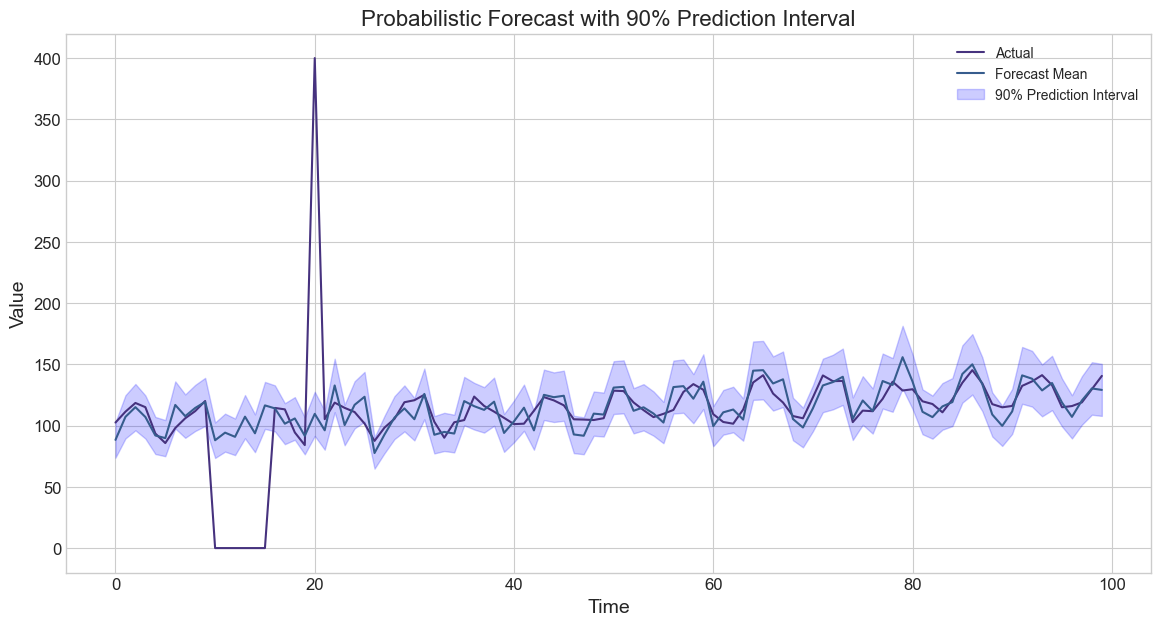

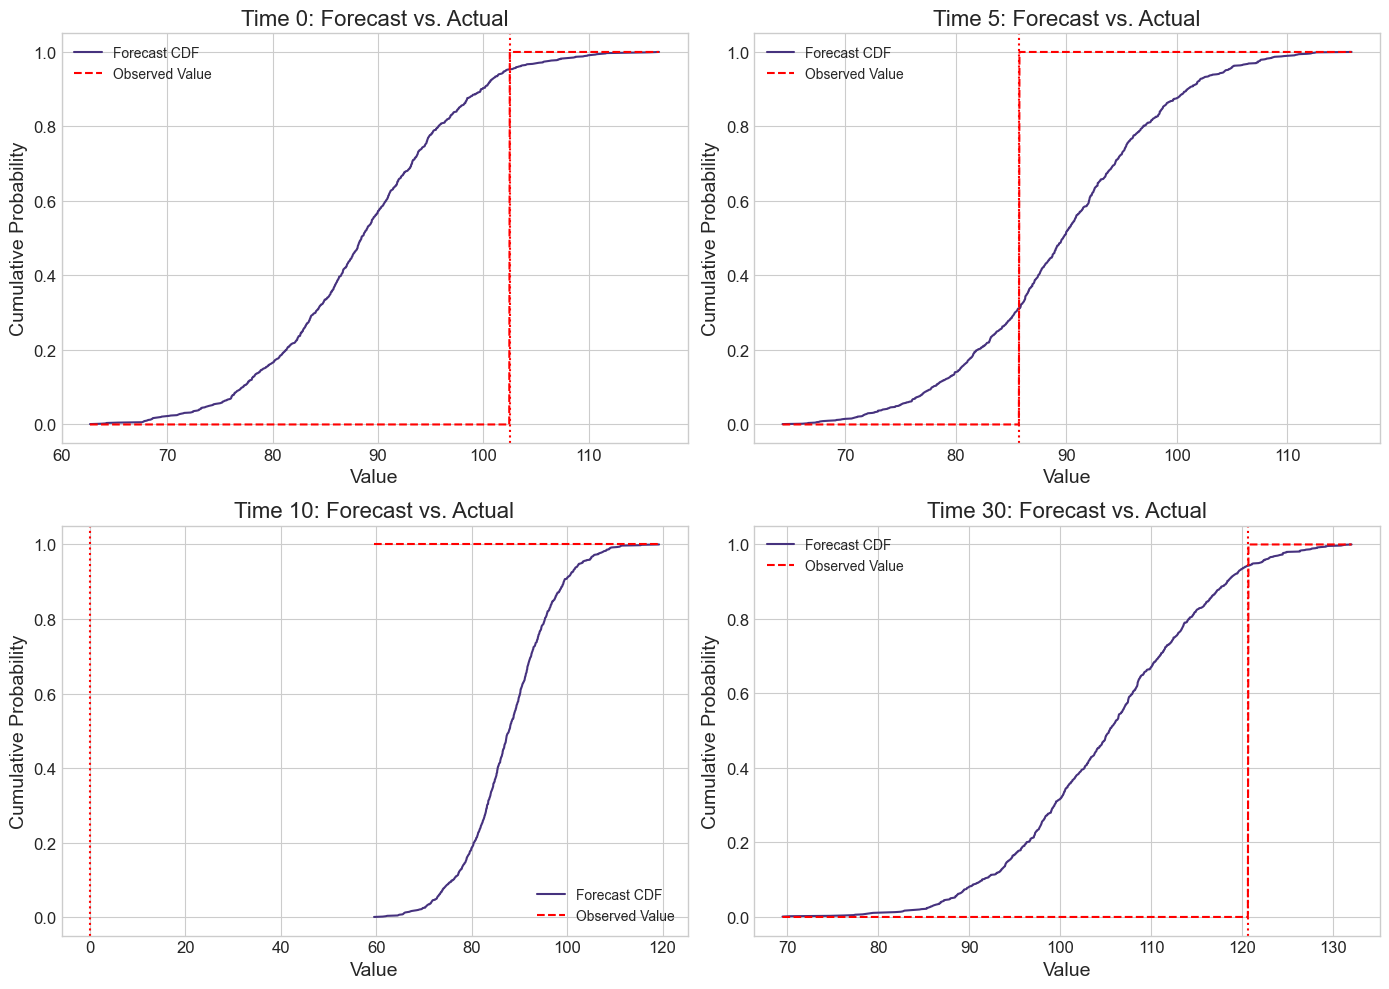

In [45]:
# For CRPS calculation, we'll use a simplified approach using Monte Carlo samples
# In practice, you might use libraries like properscoring or specialized functions

def calculate_crps(actual, forecast_mean, forecast_std, n_samples=1000):
    """Calculate CRPS using Monte Carlo samples from a normal distribution
    
    This is a simplified implementation for educational purposes.
    In practice, use specialized libraries.
    """
    crps_values = []
    
    for i in range(len(actual)):
        # Generate samples from the forecast distribution
        samples = np.random.normal(forecast_mean[i], forecast_std[i], n_samples)
        samples.sort()  # Sort for the empirical CDF
        
        # Calculate the CRPS
        crps_i = 0
        for j in range(n_samples-1):
            # Width of the interval
            width = samples[j+1] - samples[j]
            
            # Height of the squared difference between the CDF and the indicator function
            cdf_value = (j+1) / n_samples
            indicator = 1.0 if samples[j] >= actual[i] else 0.0
            height = (cdf_value - indicator) ** 2
            
            # Add the area to the integral
            crps_i += width * height
            
        crps_values.append(crps_i)
    
    return np.mean(crps_values)

# Let's assume our forecast has a standard deviation proportional to the forecast value
forecast_std = data['forecast_good'] * 0.1  # 10% of the forecast value

# Calculate CRPS
crps = calculate_crps(data['actual'], data['forecast_good'], forecast_std)
print(f"CRPS: {crps:.4f}")

# Visualize a probabilistic forecast with prediction intervals
plt.figure(figsize=(14, 7))
plt.plot(data['actual'], label='Actual')
plt.plot(data['forecast_good'], label='Forecast Mean')

# Add 90% prediction interval
upper_90 = data['forecast_good'] + 1.645 * forecast_std
lower_90 = data['forecast_good'] - 1.645 * forecast_std
plt.fill_between(range(len(data['forecast_good'])), lower_90, upper_90, alpha=0.2, color='blue', label='90% Prediction Interval')

plt.title('Probabilistic Forecast with 90% Prediction Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Let's show the empirical CDF for a few time points
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, idx in enumerate([0, 5, 10, 30]):
    if idx < len(data['actual']):
        # Generate samples for the empirical CDF
        samples = np.random.normal(data['forecast_good'][idx], forecast_std[idx], 1000)
        samples.sort()
        
        # Plot the empirical CDF
        cdf = np.arange(1, len(samples) + 1) / len(samples)
        axes[i].plot(samples, cdf, label='Forecast CDF')
        
        # Plot the actual observation as a step function
        x_values = np.linspace(min(samples), max(samples), 1000)
        y_values = np.where(x_values >= data['actual'][idx], 1, 0)
        axes[i].plot(x_values, y_values, 'r--', label='Observed Value')
        
        # Mark the actual observation
        axes[i].axvline(data['actual'][idx], color='r', linestyle=':')
        
        axes[i].set_title(f'Time {idx}: Forecast vs. Actual')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Cumulative Probability')
        axes[i].grid(True)
        axes[i].legend()

plt.tight_layout()
plt.show()

#### SPIEGAZIONE DEL CODICE SOPRA

In sintesi:
Questo codice mostra come calcolare il CRPS per una previsione probabilistica utilizzando un metodo basato su Monte Carlo, visualizzando sia la distribuzione probabilistica delle previsioni (con intervalli di previsione) che la CDF empirica per determinati punti temporali. Questo approccio aiuta a comprendere meglio l'incertezza associata alle previsioni e a visualizzare la qualità della previsione probabilistica rispetto ai valori osservati.

## 7. Metriche specifiche per il tempo <a id="time-specific"></a>

Le serie temporali hanno spesso caratteristiche speciali come stagionalità, tendenze o importanza variabile in diversi periodi di tempo. Le metriche specifiche per il tempo tengono conto di queste caratteristiche.

### 7.1 MAPE ponderato

Il MAPE ponderato (WMAPE) assegna pesi diversi a periodi di tempo diversi, consentendoci di enfatizzare periodi specifici che sono più importanti per la nostra analisi.

$$\text{WMAPE} = \frac{\sum_{i=1}^{n} w_i |y_i - \hat{y}_i|}{\sum_{i=1}^{n} w_i |y_i|}$$

Dove:
- $w_i$ è il peso assegnato al periodo di tempo $i$
- $y_i$ è il valore effettivo
- $\hat{y}_i$ è il valore previsto

**Spiegazione del WMAPE:**
- Calcolo dell'errore assoluto: Per ciascun periodo $i$, calcoliamo la differenza assoluta tra il valore osservato ($y_i$) e il valore previsto ($\hat{y}_i$), ossia $|y_i - \hat{y}_i|$.
- Pesi associati agli errori: Ogni errore assoluto è poi ponderato con un peso $w_i$. Quindi, invece di trattare ogni errore allo stesso modo (come nel MAPE standard), i periodi di tempo più importanti (con pesi più alti) avranno un impatto maggiore nel calcolo finale del WMAPE.
- Somma degli errori ponderati: Si sommano gli errori ponderati per tutti i periodi di tempo.
- Normalizzazione: La somma degli errori ponderati è poi divisa per la somma dei valori assoluti osservati $|y_i|$ ponderati per i pesi. Questo assicura che la misura di errore rimanga nella stessa scala dei dati, come nel caso del MAPE.

**PERCHE' USARE IL WMAPE**
- Enfatizzare periodi più critici: In alcune analisi, potrebbero esserci periodi che sono più importanti rispetto ad altri (ad esempio, durante periodi di alta domanda in una serie temporale di vendite). Assegnando pesi maggiori a questi periodi, il WMAPE penalizza di più gli errori in quei periodi chiave.
- Flessibilità: Il WMAPE consente di aggiungere una maggiore flessibilità nel modellare l'importanza relativa delle diverse osservazioni. Questo è utile quando alcuni dati (come durante picchi stagionali o eventi speciali) hanno un significato maggiore rispetto ad altre

**Vantaggi:**
- Riflette meglio l'importanza dei periodi: A differenza del MAPE tradizionale, che tratta tutte le osservazioni allo stesso modo, il WMAPE permette di enfatizzare errori significativi durante periodi più critici.
- Maggiore flessibilità: Può essere utilizzato in scenari dove alcune osservazioni (o periodi) sono più rilevanti per l'analisi, migliorando l'interpretazione dell'errore.

**Svantaggi**
- Scelta dei pesi: La principale difficoltà nell'uso del WMAPE sta nella scelta dei pesi. Questi devono essere scelti con attenzione per evitare che l'errore sia troppo influenzato da pochi periodi di tempo. La selezione dei pesi potrebbe essere soggettiva.
- Meno intuitivo: Rispetto al MAPE tradizionale, che è semplice da interpretare, il WMAPE richiede di comprendere il motivo per cui vengono assegnati determinati pesi a ciascun periodo.

**Conclusione**

Il WMAPE è una versione più avanzata e flessibile del MAPE, che consente di dare maggiore importanza ad alcune osservazioni o periodi, e può essere particolarmente utile in contesti dove determinate fasi temporali (ad esempio, eventi, stagioni, o periodi critici) sono più significative rispetto ad altri.


In [46]:
# Define the weighted MAPE function
def wmape(y_true, y_pred, weights=None):
    """Calculate Weighted Mean Absolute Percentage Error.
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    weights (array-like, optional): Weights for each observation
    
    Returns:
    float: Weighted MAPE value
    """
    if weights is None:
        weights = np.ones_like(y_true)
        
    # Avoid division by zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    
    return np.sum(weights[mask] * np.abs(y_true[mask] - y_pred[mask])) / np.sum(weights[mask] * np.abs(y_true[mask]))

# Let's create some custom weights
# For example, we might want to emphasize recent observations more
n = data.shape[0]
recency_weights = np.linspace(0.5, 1.5, n)  # Increasing weights over time

# Calculate standard MAPE (equal weights)
standard_mape = wmape(data['actual'], data['forecast_good'])

# Calculate weighted MAPEs
recency_wmape = wmape(data['actual'], data['forecast_good'], recency_weights)

print(f"Standard MAPE: {standard_mape:.4f}")
print(f"Recency-Weighted MAPE: {recency_wmape:.4f}")

Standard MAPE: 0.0885
Recency-Weighted MAPE: 0.0790


#### SPIEGAZIONE CODICE SOPRA
Questo codice definisce e calcola il Weighted Mean Absolute Percentage Error (WMAPE), una versione modificata del MAPE, che consente di assegnare pesi differenti alle osservazioni per enfatizzare determinate osservazioni, come quelle recenti.

<a id='real-world'></a>
## 9. Esempio reale

In questa sezione, applicheremo le metriche apprese a un set di dati reale. Utilizzeremo un set di dati sulle vendite al dettaglio, che è uno scenario comune di previsione delle serie temporali nell'analisi aziendale.

In [50]:
# Carichiamo un dataset di vendite al dettaglio nel mondo reale
# Utilizzando un campione del dataset di vendita al dettaglio online
# Puoi sostituirlo con il tuo dataset

# Per questo esempio, genereremo un set di dati realistico sulle vendite al dettaglio
np.random.seed(42)
date_rng = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])

# Crea livello base
level = 1000
# Aggiungi trend
trend = np.linspace(0, 500, len(date_rng))
# Aggiungere stagionalità (settimanale e annuale)
weekly = 50 * np.sin(np.arange(len(date_rng)) * (2 * np.pi / 7))
yearly = 300 * np.sin(np.arange(len(date_rng)) * (2 * np.pi / 365))
# Aggiungi rumore casuale
noise = np.random.normal(0, 50, len(date_rng))

# Combina tutti i componenti
df['sales'] = level + trend + weekly + yearly + noise
df['sales'] = df['sales'].clip(lower=0)  # Ensure no negative sales

# Usa la data come indice
df.set_index('date', inplace=True)

# Mostra le prime 5 righe
print("Dataset preview:")
df.head()

Dataset preview:


,sales
date,
2019-01-01,1024.836
2019-01-02,1037.685
2019-01-03,1092.142
2019-01-04,1114.359
2019-01-05,988.609


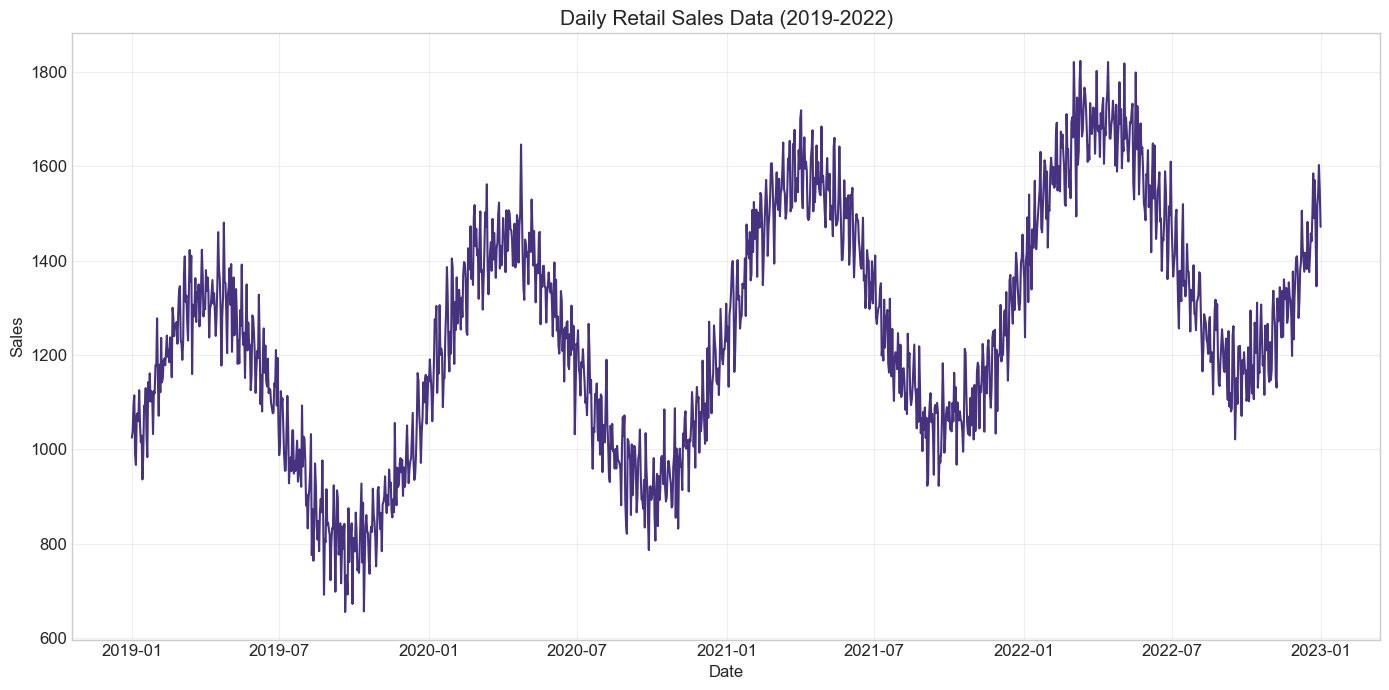

In [49]:
# Visualizza il set di dati completo
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sales'])
plt.title('Daily Retail Sales Data (2019-2022)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.1 Preparazione dei dati e suddivisione di training-test

Prima di applicare i modelli di previsione, dobbiamo suddividere i nostri dati in set di training e test. Nella previsione delle serie temporali, in genere utilizziamo periodi precedenti per il training e periodi successivi per il test, rispettando la natura temporale dei dati.

Training data: 1369 days
Testing data: 92 days


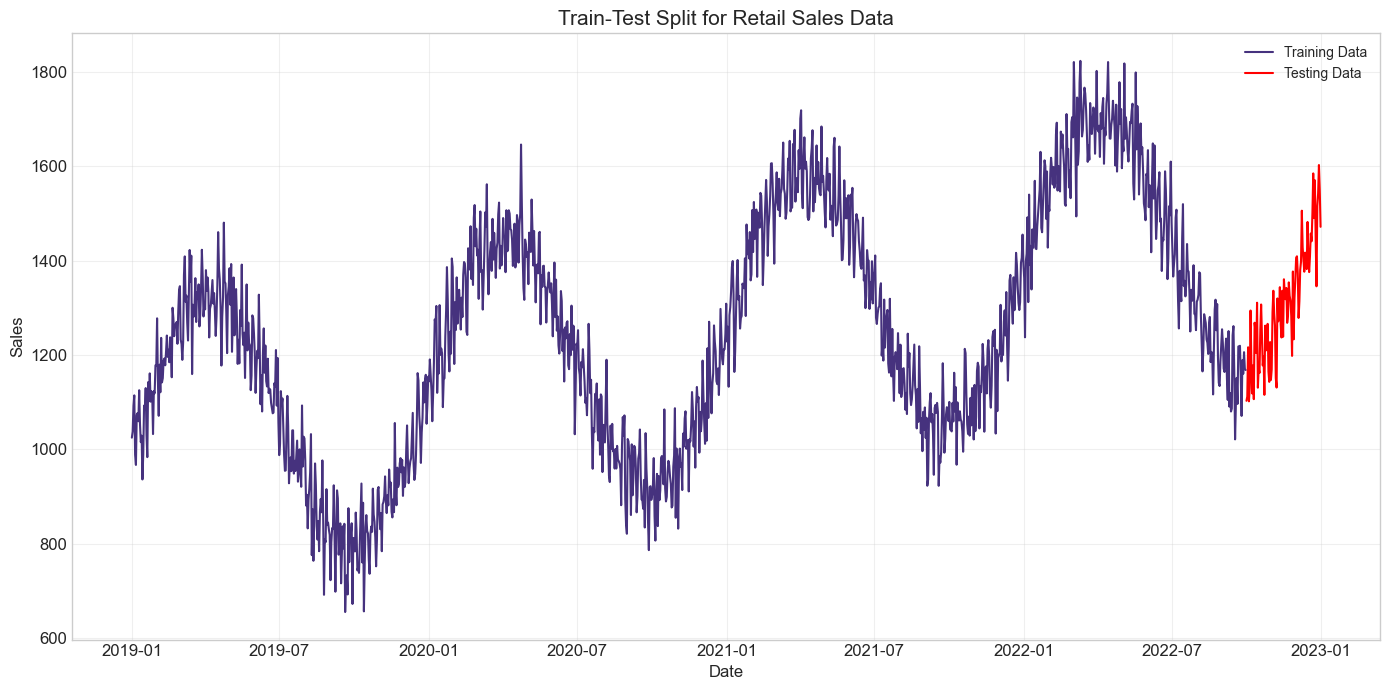

In [51]:
# Suddividere i dati in set di addestramento e di test (ultimi 3 mesi per i test)
train = df[:'2022-09-30']
test = df['2022-10-01':]

print(f"Training data: {train.shape[0]} days")
print(f"Testing data: {test.shape[0]} days")

# Visualizza la divisione train-test
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['sales'], label='Training Data')
plt.plot(test.index, test['sales'], label='Testing Data', color='red')
plt.title('Train-Test Split for Retail Sales Data', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Implementazione dei modelli di previsione

Implementiamo e confrontiamo diversi modelli di previsione:
1. Previsione ingenua (ultimo valore osservato)
2. Ingenua stagionale (stesso valore della stagione scorsa)
3. Smoothing esponenziale
4. Modello ARIMA

### 9.2 Implementazione dei modelli di previsione

Nella previsione delle serie temporali, esistono vari modelli che vanno dall'uso di approcci semplici e intuitivi, come la **previsione ingenua**, fino a modelli più complessi, come **ARIMA**. Di seguito ti spiego in dettaglio ciascuno di questi modelli:

### 1. **Previsione Ingenua (Ultimo Valore Osservato)**

La previsione ingenua è uno dei metodi più semplici per la previsione delle serie temporali. In questo approccio, la previsione per il periodo successivo è semplicemente uguale all'ultimo valore osservato. 

#### Formula:
$$ \hat{y}_{t+1} = y_t $$

- **Vantaggi**:
  - Molto semplice da implementare.
  - Non richiede alcuna modellizzazione complessa dei dati.
  
- **Svantaggi**:
  - Funziona bene solo quando i dati non mostrano tendenze, stagionalità o altri pattern complessi.
  - Non adatto a dati che evolvono nel tempo.

**Esempio di applicazione**:
Se le vendite di oggi sono 1000, la previsione per domani sarà anche 1000.

### 2. **Previsione Ingenua Stagionale (Stesso Valore della Stagione Scorsa)**

In questo caso, la previsione per il prossimo periodo (ad esempio, il prossimo giorno, settimana o mese) è uguale al valore osservato nella stessa stagione (o periodo) dell'anno precedente. Questo approccio è utile quando ci sono forti pattern stagionali nei dati.

#### Formula:
$$ \hat{y}_{t+1} = y_{t - m} $$

Dove:
- \( m \) è il periodo stagionale (ad esempio, 7 per le previsioni settimanali, 365 per le previsioni annuali).

- **Vantaggi**:
  - Molto utile per dati con forti pattern stagionali.
  - Facile da implementare.
  
- **Svantaggi**:
  - Non tiene conto di eventuali tendenze o cambiamenti a lungo termine.
  - Funziona solo quando il pattern stagionale è stabile nel tempo.

**Esempio di applicazione**:
Se le vendite di una determinata settimana dell'anno scorso erano 1200, la previsione per la settimana corrente sarà anche 1200.

### 3. **Smoothing Esponenziale (Exponential Smoothing)**

Lo **smoothing esponenziale** è un metodo di previsione che pesa maggiormente i dati recenti e meno quelli passati. Esistono vari tipi di smoothing esponenziale, ma uno dei più comuni è il **modello di smoothing esponenziale semplice**. 

#### Formula:
$$ \hat{y}_{t+1} = \alpha y_t + (1 - \alpha) \hat{y}_t $$

Dove:
- \( \alpha \) è il parametro di smoothing, compreso tra 0 e 1.
  - \( \alpha \) definisce quanto peso dare all'osservazione più recente: un valore di \( \alpha = 1 \) dà tutto il peso al valore più recente, mentre un valore di \( \alpha = 0 \) dà uguale peso a tutte le osservazioni passate.
- \( \hat{y}_t \) è la previsione per il periodo \( t \).
  
- **Vantaggi**:
  - Considera le osservazioni recenti con maggiore peso.
  - Facile da implementare e può adattarsi rapidamente ai cambiamenti nei dati.
  
- **Svantaggi**:
  - Non considera stagionalità o tendenze nei dati (salvo se esteso al **modello di Holt-Winters** che include anche tendenze e stagionalità).
  - Potrebbe non essere ideale per dati con pattern complessi.

**Esempio di applicazione**:
Se \( \alpha = 0.5 \) e il valore attuale è 1000, la previsione per il prossimo periodo sarà una combinazione di 50% di 1000 e 50% della previsione precedente.

### 4. **Modello ARIMA (AutoRegressive Integrated Moving Average)**

Il modello **ARIMA** è uno dei modelli più potenti e completi per la previsione delle serie temporali. Si basa su tre componenti principali:
1. **AutoRegressivo (AR)**: Dipendenza lineare dai valori passati.
2. **Integrato (I)**: Differenziazione dei dati per renderli stazionari (ad esempio, per rimuovere tendenze).
3. **Moving Average (MA)**: Media mobile dei residui passati.

#### Formula:
$$ y_t = \alpha + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t $$

Dove:
- \( \phi_i \) sono i coefficienti autoregressivi,
- \( \theta_j \) sono i coefficienti della media mobile,
- \( \epsilon_t \) è l'errore (rumore) del modello.

**Componenti di ARIMA**:
- **AR(p)**: Rappresenta la dipendenza lineare dai valori passati.
- **I(d)**: La differenziazione per rendere la serie stazionaria.
- **MA(q)**: Media mobile dei residui.

- **Vantaggi**:
  - Può catturare sia la stagionalità che le tendenze nei dati.
  - È molto flessibile e può modellare vari tipi di comportamento nelle serie temporali.

- **Svantaggi**:
  - È più complesso da implementare rispetto ad altri modelli.
  - Richiede che i dati siano stazionari o che vengano differenziati per renderli stazionari.
  
**Esempio di applicazione**:
Se il modello ARIMA identifica una tendenza nei dati delle vendite e una certa dipendenza tra le vendite di un giorno e quelle dei giorni precedenti, utilizzerà queste informazioni per fare previsioni per i giorni futuri.

---

### Confronto dei Modelli

| **Modello**                | **Adatto per**                                           | **Semplicità** | **Precisione**   | **Esempio di Applicazione** |
|----------------------------|----------------------------------------------------------|----------------|------------------|----------------------------|
| **Previsione Ingenua**      | Dati stazionari senza tendenze o stagionalità            | Molto semplice | Bassa            | Prevedere il valore di domani come quello di oggi. |
| **Ingenua Stagionale**      | Dati con stagionalità forte e stabile                    | Semplice       | Media            | Prevedere le vendite di oggi come quelle della stessa settimana dell'anno scorso. |
| **Smoothing Esponenziale**  | Dati con tendenze e cambiamenti improvvisi               | Semplice       | Media-Alta       | Prevedere i prossimi valori considerando il trend recente. |
| **ARIMA**                   | Dati con tendenze, stagionalità e strutture complesse    | Complesso      | Alta             | Prevedere le vendite considerando trend, stagionalità e altri pattern complessi. |

### Implementazione dei Modelli

L'implementazione pratica di questi modelli dipenderà dai dati a disposizione, ma in generale esistono librerie Python come `statsmodels` per ARIMA, e `ExponentialSmoothing` per il smoothing esponenziale, che rendono facili da usare questi approcci.

In [57]:
# Initialize a DataFrame to store all forecasts
forecasts = pd.DataFrame(index=test.index)
forecasts['actual'] = test['sales']

# 1. Naive Forecast (using last observed value)
forecasts['naive'] = train['sales'].iloc[-1]

# 2. Seasonal Naive (using value from same day in the previous week)
forecasts['seasonal_naive'] = [train['sales'].iloc[-(i % 7 + 7)] for i in range(len(test))]

# 3. Exponential Smoothing
# Using Triple Exponential Smoothing (Holt-Winters) with weekly seasonality
hw_model = ExponentialSmoothing(
    train['sales'],
    seasonal_periods=7,
    trend='add',
    seasonal='add',
    use_boxcox=True
)
hw_fit = hw_model.fit(optimized=True)
forecasts['exponential_smoothing'] = hw_fit.forecast(len(test))

# 4. ARIMA model
# Using ARIMA(1,1,1)(1,1,0)7 for weekly seasonality
arima_model = ARIMA(
    train['sales'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 7)
)
arima_fit = arima_model.fit()
forecasts['arima'] = arima_fit.forecast(len(test))

# Display first few rows of forecasts
forecasts.head()

,actual,naive,seasonal_naive,exponential_smoothing,arima
date,,,,,
2022-10-01,1102.904,1168.048,1152.746,1114.238,1074.780
2022-10-02,1111.854,1168.048,1219.420,1081.864,1068.840
2022-10-03,1216.239,1168.048,1217.131,1106.549,1156.676
2022-10-04,1101.737,1168.048,1217.886,1137.490,1115.169
2022-10-05,1129.421,1168.048,1096.245,1173.907,1197.721


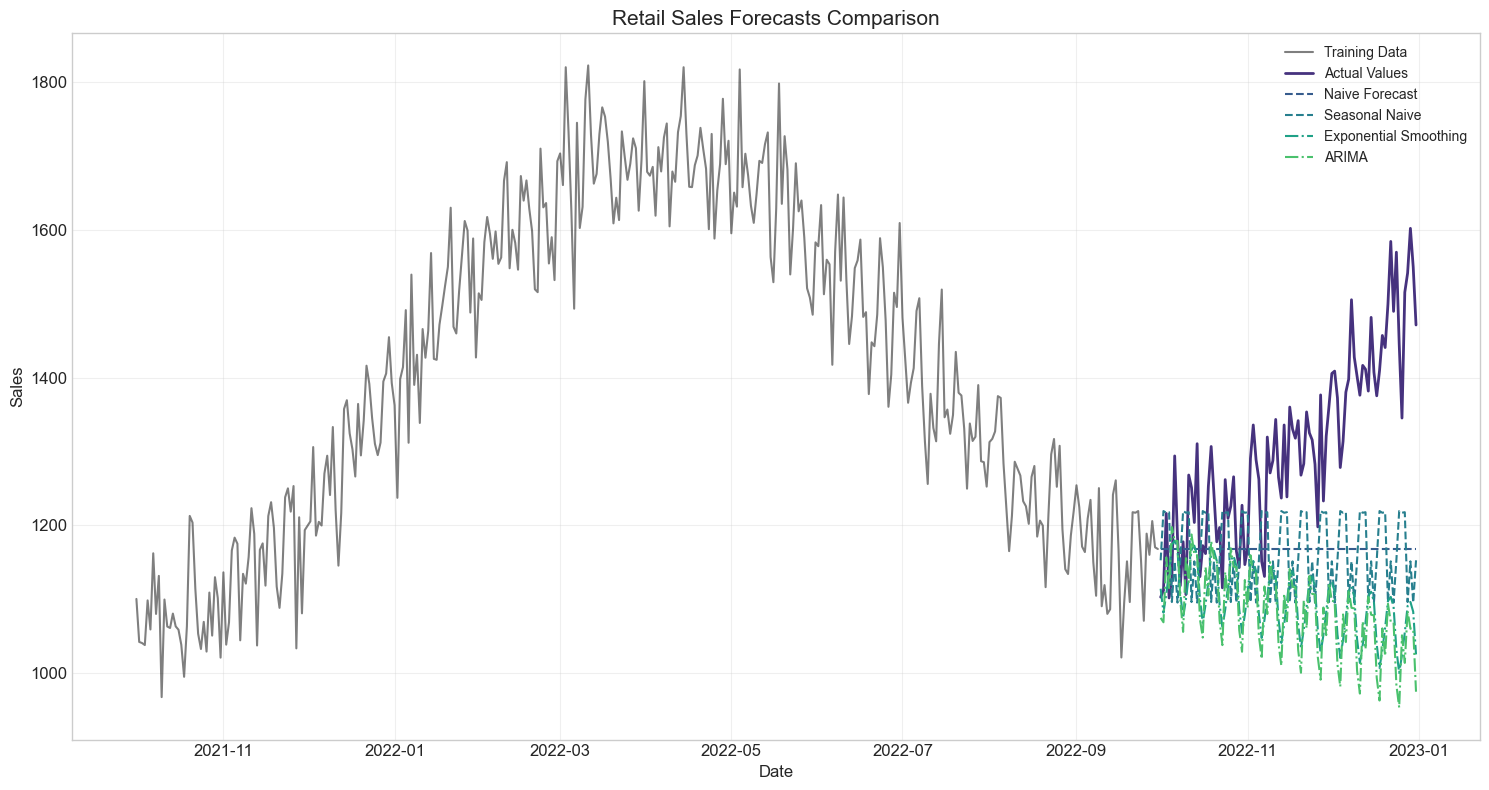

In [58]:
# Visualize the forecasts
plt.figure(figsize=(15, 8))

# Show the last 365 days of training data for context
plt.plot(train.index[-365:], train['sales'][-365:], label='Training Data', color='black', alpha=0.5)

# Plot actual values and forecasts
plt.plot(forecasts.index, forecasts['actual'], label='Actual Values', linewidth=2)
plt.plot(forecasts.index, forecasts['naive'], label='Naive Forecast', linestyle='--')
plt.plot(forecasts.index, forecasts['seasonal_naive'], label='Seasonal Naive', linestyle='--')
plt.plot(forecasts.index, forecasts['exponential_smoothing'], label='Exponential Smoothing', linestyle='-.')
plt.plot(forecasts.index, forecasts['arima'], label='ARIMA', linestyle='-.')

plt.title('Retail Sales Forecasts Comparison', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.3 Valutazione delle previsioni con più metriche

Ora valutiamo le prestazioni di ciascun modello utilizzando le metriche apprese in questo tutorial.

In [59]:
# Define a function to calculate all metrics
def calculate_all_metrics(actual, predicted, name):
    # For MASE calculation, we need the in-sample naive forecast errors
    naive_errors = np.abs(train['sales'].diff().dropna()).mean()
    
    # Calculate metrics
    results = {
        'Model': name,
        'MAE': mean_absolute_error(actual, predicted),
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100,
        'SMAPE': 200 * np.mean(np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))),
        'MASE': mean_absolute_error(actual, predicted) / naive_errors,
    }
    
    return results

# Calculate metrics for each model
metrics = []
for column in forecasts.columns:
    if column != 'actual':
        metrics.append(calculate_all_metrics(forecasts['actual'], forecasts[column], column))

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics).set_index('Model')

# Display all metrics
metrics_df

,MAE,MSE,RMSE,MAPE,SMAPE,MASE
Model,,,,,,
naive,150.656,34484.666,185.700,10.890,11.789,2.459
seasonal_naive,164.136,40833.187,202.072,11.951,13.002,2.679
exponential_smoothing,214.034,64793.910,254.546,15.586,17.418,3.494
arima,225.331,72816.875,269.846,16.408,18.485,3.678


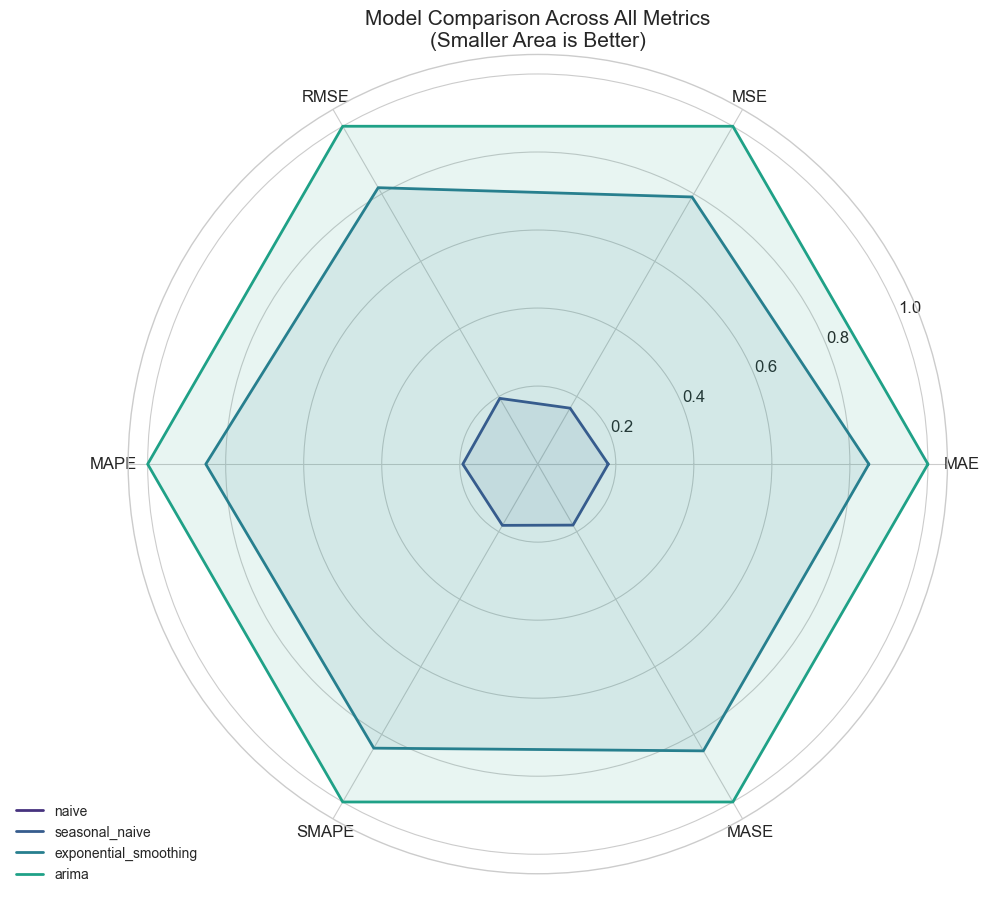

In [60]:
# Visualize the metrics comparison
# Let's create radar charts for model comparison

# Normalize metrics for radar chart (lower is better for all metrics)
# We'll invert Directional Accuracy since higher is better
radar_metrics = metrics_df.copy()
radar_metrics = radar_metrics.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x / x.max())

# Setup radar chart
categories = list(radar_metrics.columns)
N = len(categories)

# Create angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Add axis labels
plt.xticks(angles[:-1], categories, size=12)

# Draw one line per model and fill area
for idx, model in enumerate(radar_metrics.index):
    values = radar_metrics.loc[model].values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Comparison Across All Metrics\n(Smaller Area is Better)', size=15)
plt.tight_layout()
plt.show()

#### SPIEGAZIONE CODICE SOPRA

Il codice che hai condiviso crea un **grafico radar** (o grafico a ragnatela) per confrontare diversi modelli di previsione basati su variabili metriche. Ecco come funziona e cosa rappresenta il grafico:

### Cosa fa il codice:

1. **Normalizzazione delle metriche:**
   - Ogni metrica (ad esempio, MAPE, RMSE, ecc.) è normalizzata in modo che tutti i valori siano tra 0 e 1. La normalizzazione viene effettuata sottraendo il valore minimo di ogni metrica e dividendo per la differenza tra il valore massimo e minimo della metrica.
   - **Eccezione:** La metrica "Directional Accuracy" è invertita, poiché un valore più alto è migliore (ma la normalizzazione tipica funziona meglio con valori più bassi). Quindi, viene "invertita" per uniformarsi con le altre metriche, in modo che valori più bassi siano sempre migliori.

2. **Preparazione del grafico radar:**
   - Le **categorie** sono i nomi delle metriche (come MAPE, MSE, ecc.), e ciascuna metrica diventa un "asse" nel grafico.
   - Ogni modello sarà rappresentato da un "poligono" che si adatta al grafico radar. Ogni angolo del grafico rappresenta una metrica, e ogni valore di una metrica per un dato modello viene visualizzato lungo l'asse corrispondente.

3. **Creazione e visualizzazione:**
   - Il grafico radar ha **N angoli** (dove N è il numero di metriche) e mostra un "poligono" per ogni modello di previsione. Ogni poligono è disegnato collegando i valori normalizzati delle metriche.
   - I modelli sono rappresentati da linee, e ogni linea è colorata con un'etichetta che identifica il modello.

4. **Significato del grafico:**
   - **L'area più piccola è migliore:** Poiché i valori sono normalizzati, un modello che ha **area più piccola** nel grafico radar ha avuto **migliori prestazioni** rispetto agli altri modelli. Questo perché le metriche che misurano errori più piccoli (come MAPE basso o RMSE basso) saranno più vicine al centro del grafico.
   - Ogni "spicchio" del grafico rappresenta una metrica. La posizione di ogni modello in quello spicchio riflette il valore della metrica per quel modello.

### Come leggere il grafico radar:

- Ogni **spicchio del grafico** rappresenta una metrica.
  - Ad esempio, un angolo potrebbe essere MAPE (errore percentuale medio assoluto), un altro potrebbe essere RMSE (errore quadratico medio), e così via.
- Ogni **linea** nel grafico rappresenta un modello di previsione.
  - Il modello con l'area più piccola (ossia la linea più vicina al centro) è il miglior modello per tutte le metriche.
- I modelli che si avvicinano al centro del grafico hanno prestazioni migliori nelle metriche normalizzate.

### In sintesi:
Il grafico radar è uno strumento utile per confrontare **visivamente** diversi modelli su molteplici metriche. Le aree più piccole indicano migliori prestazioni complessive, mentre le aree più grandi suggeriscono che il modello non ha performato altrettanto bene rispetto agli altri modelli.

Se hai bisogno di ulteriori chiarimenti sul grafico o su come interpretare specifici modelli o metriche, fammi sapere!